# 2. CAD Feature Recognition through Visual Question Answering with LLM Models

Project Objective:
- Evaluate the performance of various state-of-the-art visual question answering (VQA) models on CAD images.
- Assess these models' capabilities in **recognizing features** and **selecting appropriate high-level manufacturing processes**.
- Design **effective prompts** to determine the **most suitable manufacturing process** for the parts depicted in the CAD images.

### Notebook 1b. Further prompt engineering

In this notebook, the goal is to compare 3 of the most important LLMs (`closed source`) and analyse their capabilities of manufacturing feature recognition from complex CAD models.

In this notebook different calls are made to Anthropic and OpenAI APIs.
We are comparing these following Multimodal LLMs:

- **claude-3-5-sonnet-20240620** 
- **claude-3-opus-20240229** 
- **gpt-4o** 

This comes with costs charged by the APIs.

- Author: [Chen Lequn](https://www.linkedin.com/in/lequn-chen-433040159)

In [1]:
import torch
import json
import os, sys, requests, argparse

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(DEVICE)

cuda


In [2]:
torch.cuda.empty_cache()

In [3]:
import gc
gc.collect()

0

In [4]:
torch.cuda.memory_summary(device=None, abbreviated=False)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |      0 B   |      0 B   |      0 B   |      0 B   |\n|       from large pool |      0 B   |      0 B   |      0 B   |      0 B   |\n|       from small pool |      0 B   |      0 B   |      0 B   |      0 B   |\n|---------------------------------------------------------------------------|\n| Active memory         |      0 B   |      0 B   |      0 B   |      0 B   |\n|       from large pool |      0 B   |      0 B   |

## Get API Keys

In [5]:
## Below is Lequn's API Key, Please replace it with your own API
CLAUDE_API_KEY = 
OPENAI_API_KEY = 

import openai
openai.api_key = OPENAI_API_KEY

import anthropic

### Helper functions

In [6]:
def save_response_to_json(response, filename):
    try:
        response_dict = json.loads(response)
        with open(filename, 'w') as file:
            json.dump(response_dict, file, indent=2)
        print(f"Response saved to {filename}")
    except json.JSONDecodeError as e:
        print(f"Failed to decode JSON response: {e}")

In [7]:
# Function to post-process the response
def post_process_response(response):
    try:
        response_dict = json.loads(response)
        print("Successfully decoded JSON")
        consolidated_features = [feature for feature in response_dict['identified_features'] if feature['exists']]
        print(f"Consolidated Features: {consolidated_features}")
        return json.dumps({"identified_features": consolidated_features}, indent=2)
    except json.JSONDecodeError as e:
        print(f"Failed to decode JSON response: {e}")
        return None

In [8]:
Result_dir = os.path.join('..', 'Results')

## Load Test CAD Images

### Define the location of the images from various testing case:
- Convert the PNG images to **base64 encoded** strings

In [9]:
# Define the relative path to the Test_Cases_STEP_Images folder
IMAGE_PATH = os.path.join('../Dataset', 'Test_Cases_STEP_Images')

# Criteria: 
# The part has only 1-2 features types (i.e., normally Machining or Extrusion features)
# No challenging features such as Sheet Metal Features. 
# All the features can be clearly seen by human.
easy_test_case = ["easy_2",
                  "easy_13",
                  "easy_18",
                  "easy_19",
                  "easy_20",
                  "easy_21",
                  "easy_22",
                  "easy_23",
                  "easy_24",
                  "easy_25",
                  "easy_26",
                  "easy_27",
                  "easy_28",
                  "easy_29",
                  "easy_30",
                  "easy_31",
                  "easy_32",
                  "easy_33"
                 ]


# Criteria: 
# Everything in between easy and hard.
# Moderate number of features types (>=2), 
# Does not contain challenging feature such as sheet metal features.
middle_test_case = ["medium_9",
                    "medium_12",
                    "medium_21",
                    "medium_22",
                    "medium_23",
                    "medium_24",
                    "medium_25",
                    "medium_26",
                    "medium_27",
                    "medium_28",
                    "medium_29",
                    "medium_30",
                    "medium_31",
                    "medium_32",
                    "medium_33"
                   ]


# Criteria: 
# Extremely complex features. Many feature types, or many qunatity.
# Difficult to predict by human without domain expertise. 
# Mostly Real-life parts.
challenging_test_case = ["hard_6",
                         "hard_11",
                         "hard_13",
                         "hard_16",
                         "hard_17",
                         "hard_18",
                         "hard_19",
                         "hard_20",
                         "hard_21",
                         "hard_22",
                         "hard_23",
                         "hard_24",
                         "hard_25",
                         "hard_26",
                         "hard_27",
                         "hard_28",
                         "hard_29",
                         "hard_30",
                         "hard_31",
                         "hard_32",
                         "hard_33",
                         "hard_34"
                        ]


All_test_cases = easy_test_case + middle_test_case + challenging_test_case


test_cases = ["easy_18",
              "easy_22",
              "easy_27",
              "easy_30",
              "easy_33",
              "medium_21",
              "medium_23",
              "medium_26",
              "medium_29",
              "medium_32",
              "hard_16",
              "hard_20",
              "hard_24",
              "hard_31",
              "hard_34"
             ]


print (len(test_cases), len(easy_test_case), len(middle_test_case), len(challenging_test_case), len(All_test_cases))

15 18 15 22 55


In [22]:
import os
from PIL import Image
import io
import base64

# Dictionary to store base64 encoded images
base64_encoded_images = {}

# Function to convert image to base64
def convert_image_to_base64(image_path, max_size=(1024, 1024), quality=100):
    try:
        image = Image.open(image_path).convert('RGB')
        if image.size[0] > max_size[0] or image.size[1] > max_size[1]:
            image.thumbnail(max_size, Image.Resampling.LANCZOS)
        image_data = io.BytesIO()
        image.save(image_data, format='PNG', optimize=True, quality=quality)
        image_data.seek(0)
        return base64.b64encode(image_data.getvalue()).decode('utf-8')
    except FileNotFoundError:
        print(f"Image not found at path: {image_path}")
        return None


# Load and convert all images to base64
for test_case in All_test_cases:
    img_path = os.path.join(IMAGE_PATH, test_case + "_view_1.png")
    base64_image = convert_image_to_base64(img_path)
    if base64_image:
        base64_encoded_images[test_case] = base64_image
        print(f"Loaded and encoded image for {test_case}")

# Example: Accessing a base64 encoded image from the dictionary
# base64_img_1 = base64_encoded_images["Part1"]

Loaded and encoded image for easy_2
Loaded and encoded image for easy_13
Loaded and encoded image for easy_18
Loaded and encoded image for easy_19
Loaded and encoded image for easy_20
Loaded and encoded image for easy_21
Loaded and encoded image for easy_22
Loaded and encoded image for easy_23
Loaded and encoded image for easy_24
Loaded and encoded image for easy_25
Loaded and encoded image for easy_26
Loaded and encoded image for easy_27
Loaded and encoded image for easy_28
Loaded and encoded image for easy_29
Loaded and encoded image for easy_30
Loaded and encoded image for easy_31
Loaded and encoded image for easy_32
Loaded and encoded image for easy_33
Loaded and encoded image for medium_9
Loaded and encoded image for medium_12
Loaded and encoded image for medium_21
Loaded and encoded image for medium_22
Loaded and encoded image for medium_23
Loaded and encoded image for medium_24
Loaded and encoded image for medium_25
Loaded and encoded image for medium_26
Loaded and encoded image

In [23]:
len(All_test_cases)

55

In [24]:
# New dictionary to store all four images for each part
all_images_base64 = {}

# Load and convert all images to base64
for test_case in All_test_cases:
    images = {}
    views = ['view_1', 'view_2', 'view_3']
    for view in views:
        img_path = os.path.join(IMAGE_PATH, f"{test_case}_{view}.png")
        base64_image = convert_image_to_base64(img_path)
        if base64_image:
            images[view] = base64_image
            print(f"Loaded and encoded {view} image for {test_case}")

    if images:
        all_images_base64[test_case] = images

Loaded and encoded view_1 image for easy_2
Loaded and encoded view_2 image for easy_2
Loaded and encoded view_3 image for easy_2
Loaded and encoded view_1 image for easy_13
Loaded and encoded view_2 image for easy_13
Loaded and encoded view_3 image for easy_13
Loaded and encoded view_1 image for easy_18
Loaded and encoded view_2 image for easy_18
Loaded and encoded view_3 image for easy_18
Loaded and encoded view_1 image for easy_19
Loaded and encoded view_2 image for easy_19
Loaded and encoded view_3 image for easy_19
Loaded and encoded view_1 image for easy_20
Loaded and encoded view_2 image for easy_20
Loaded and encoded view_3 image for easy_20
Loaded and encoded view_1 image for easy_21
Loaded and encoded view_2 image for easy_21
Loaded and encoded view_3 image for easy_21
Loaded and encoded view_1 image for easy_22
Loaded and encoded view_2 image for easy_22
Loaded and encoded view_3 image for easy_22
Loaded and encoded view_1 image for easy_23
Loaded and encoded view_2 image for

In [25]:
# Load few-shot examples
few_shot_image_folder = os.path.join(".", 'few_shot_example')
os.makedirs(few_shot_image_folder, exist_ok=True)

few_shot_examples = []

example_images = [os.path.join(few_shot_image_folder, f) for f in os.listdir(few_shot_image_folder) if f.endswith('.png') or f.endswith('.jpeg') or f.endswith('.jpg')]
# Process each STEP file
for images_path in example_images:
    try:
        base64_image = convert_image_to_base64(images_path)
        few_shot_examples.append(base64_image)
        print(f"Loaded image for {images_path}")
    except FileNotFoundError:
        print(f"Image for {images_path} not found at path")

Loaded image for ./few_shot_example/example_2.png
Loaded image for ./few_shot_example/example_1.jpeg


/home/chenlequn/anaconda3/envs/vlm_afr/lib/python3.9/site-packages/PIL/Image.py:3406: DecompressionBombWarning: Image size (135419040 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Loaded image for ./few_shot_example/example_3.png


In [27]:
single_image_test_case_base64_encoded = base64_encoded_images["medium_30"]

Displaying image for easy_2:


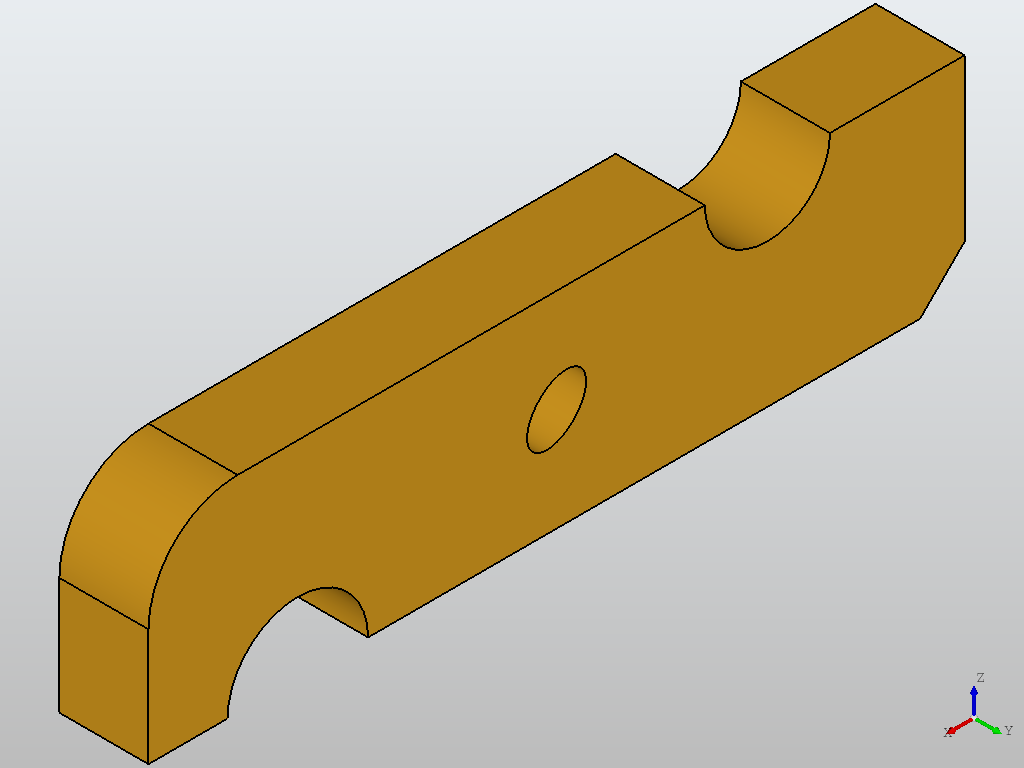

Displaying image for easy_13:


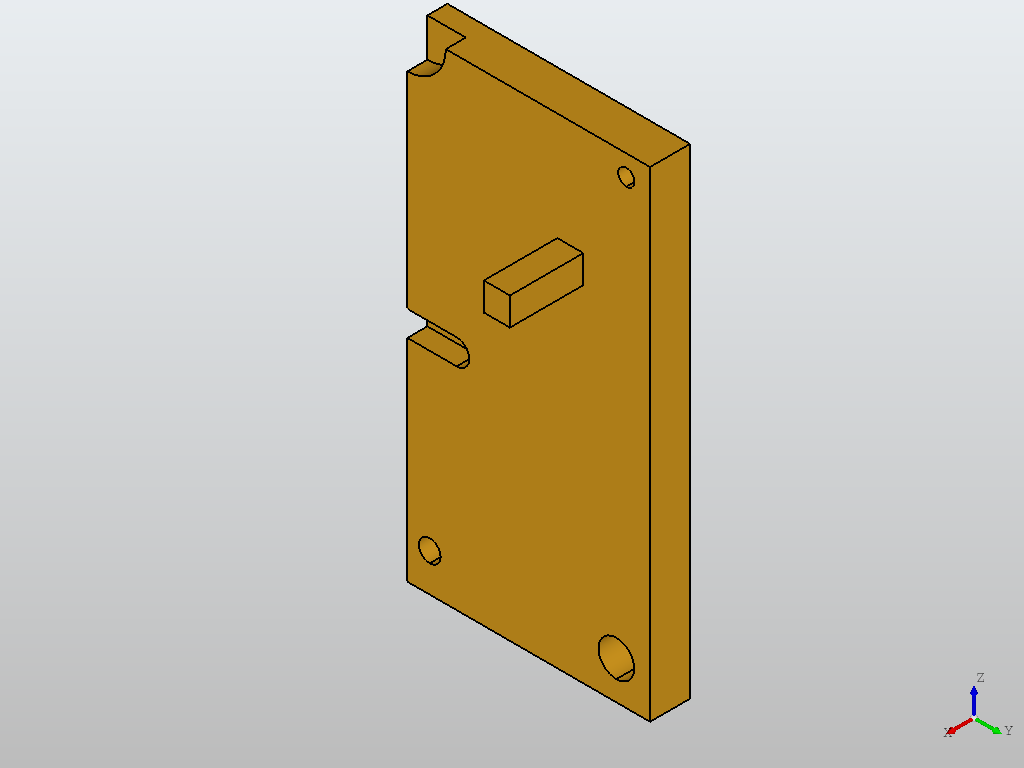

Displaying image for easy_18:


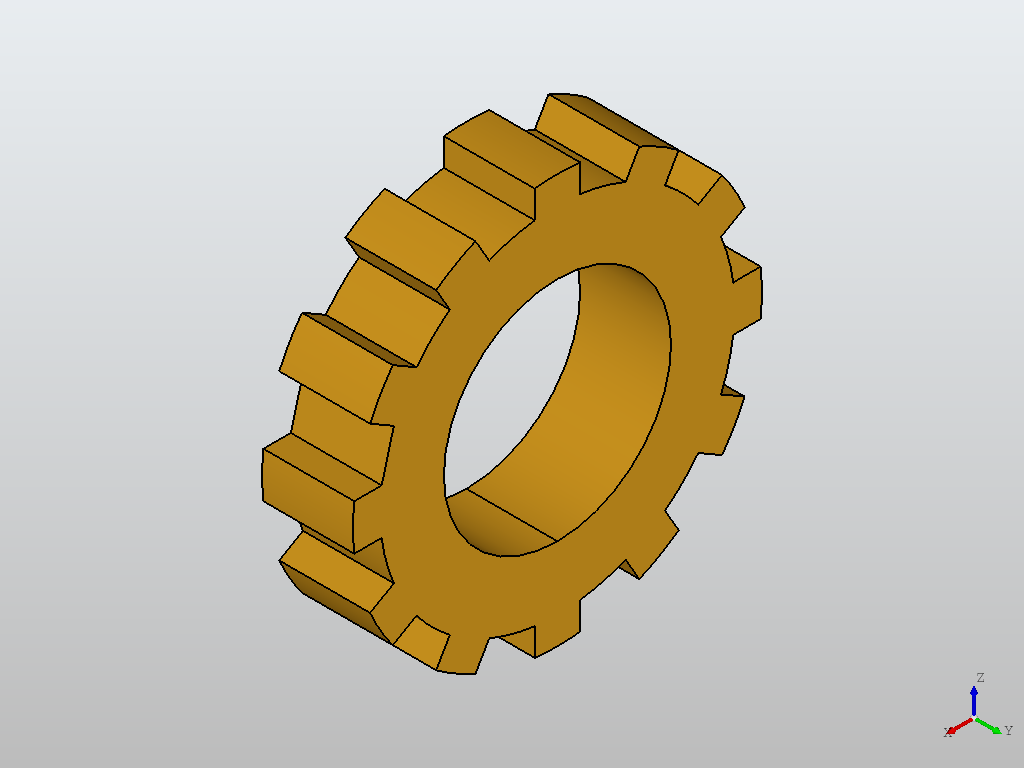

Displaying image for easy_19:


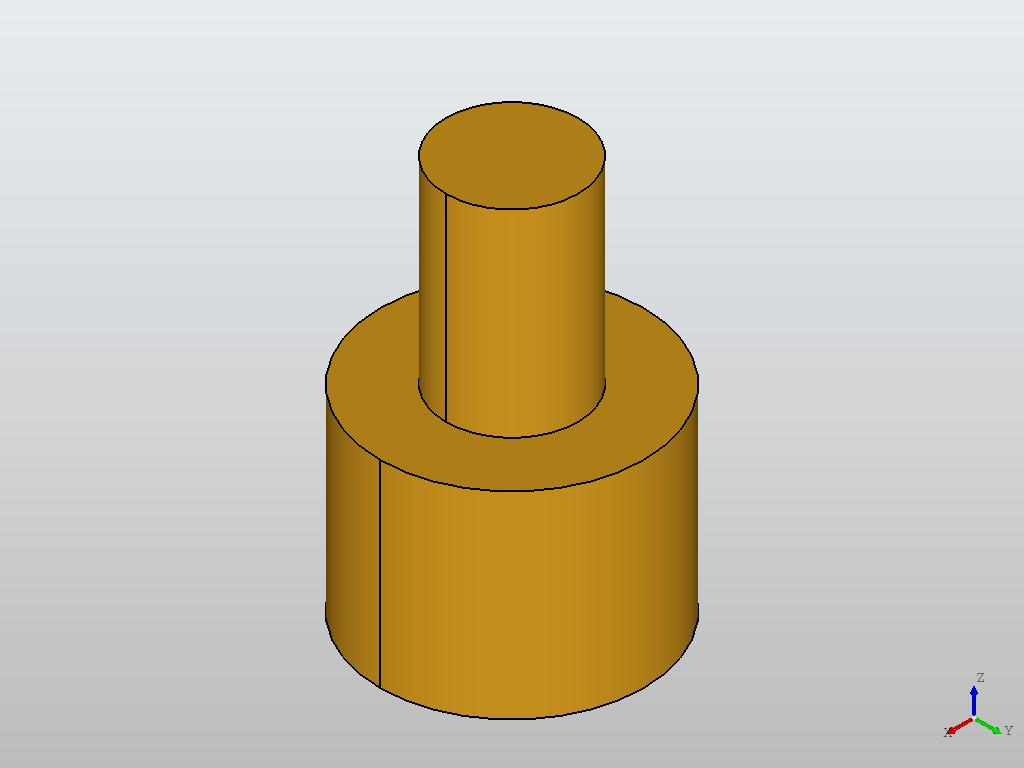

Displaying image for easy_20:


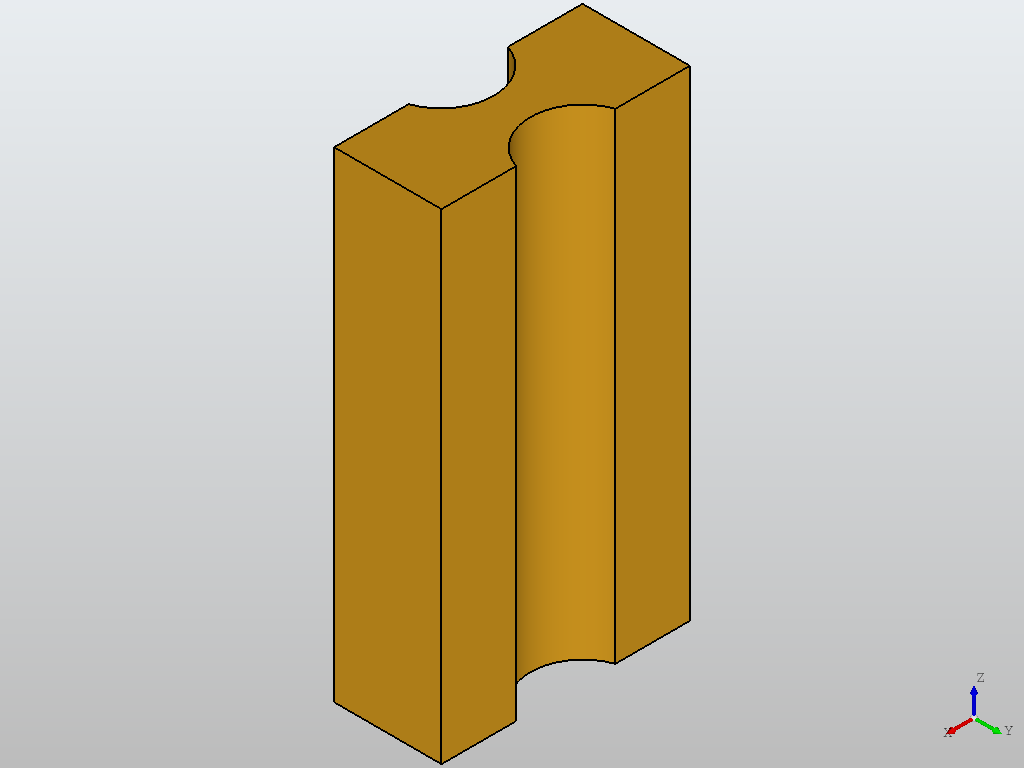

Displaying image for easy_21:


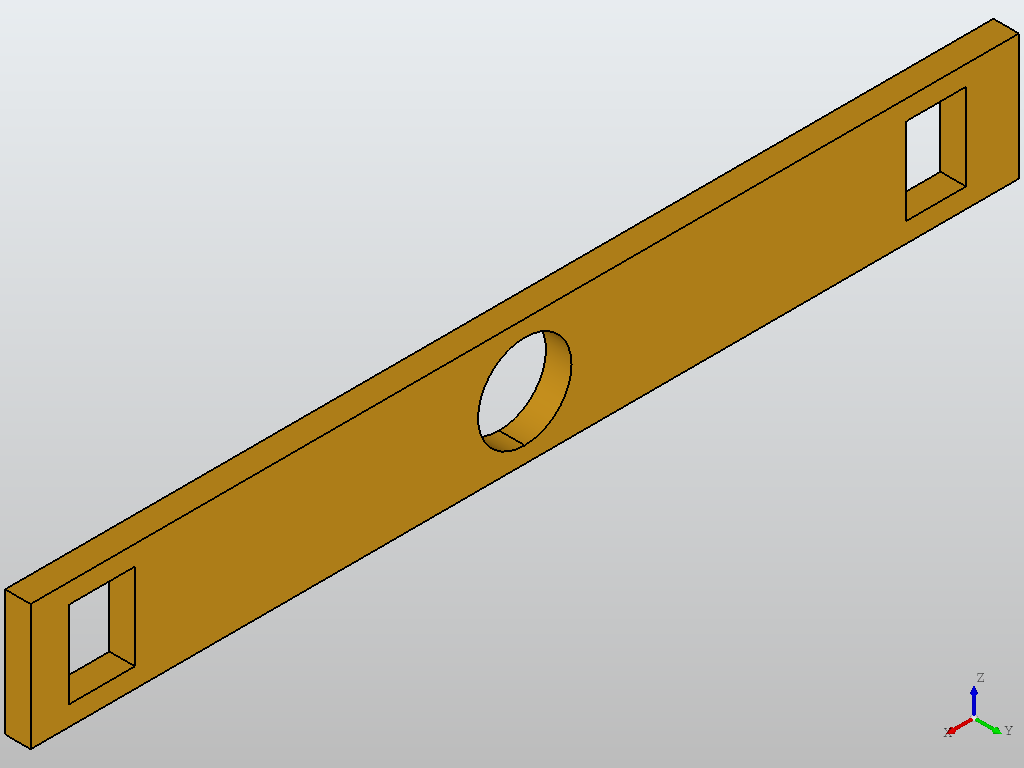

Displaying image for easy_22:


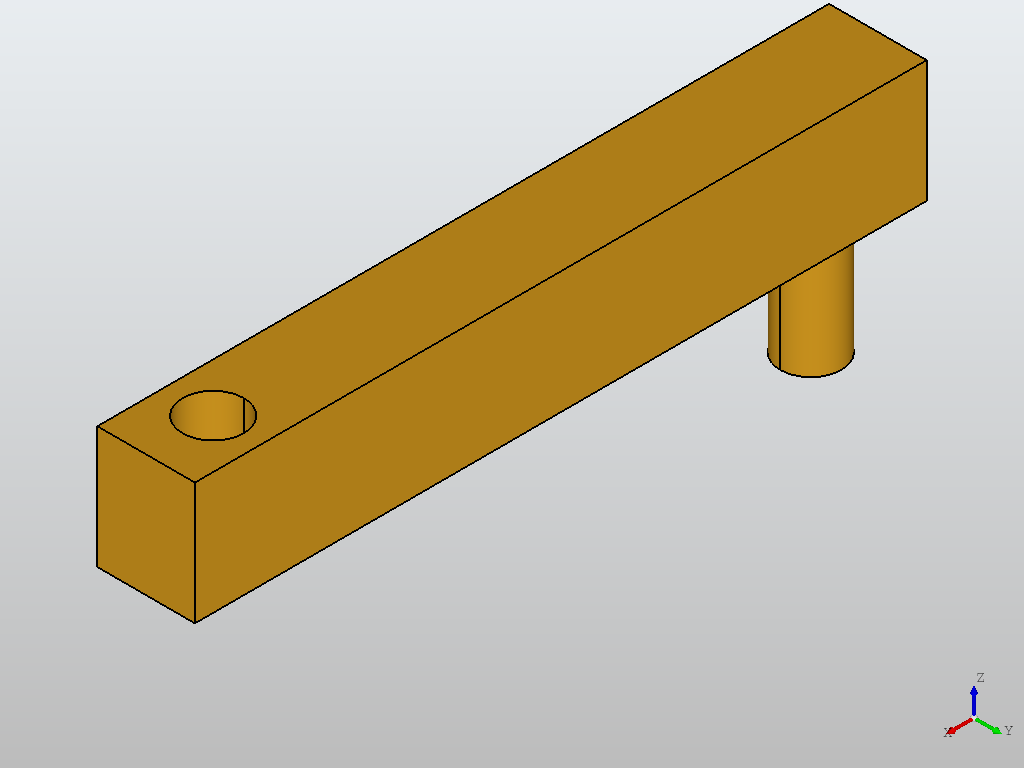

Displaying image for easy_23:


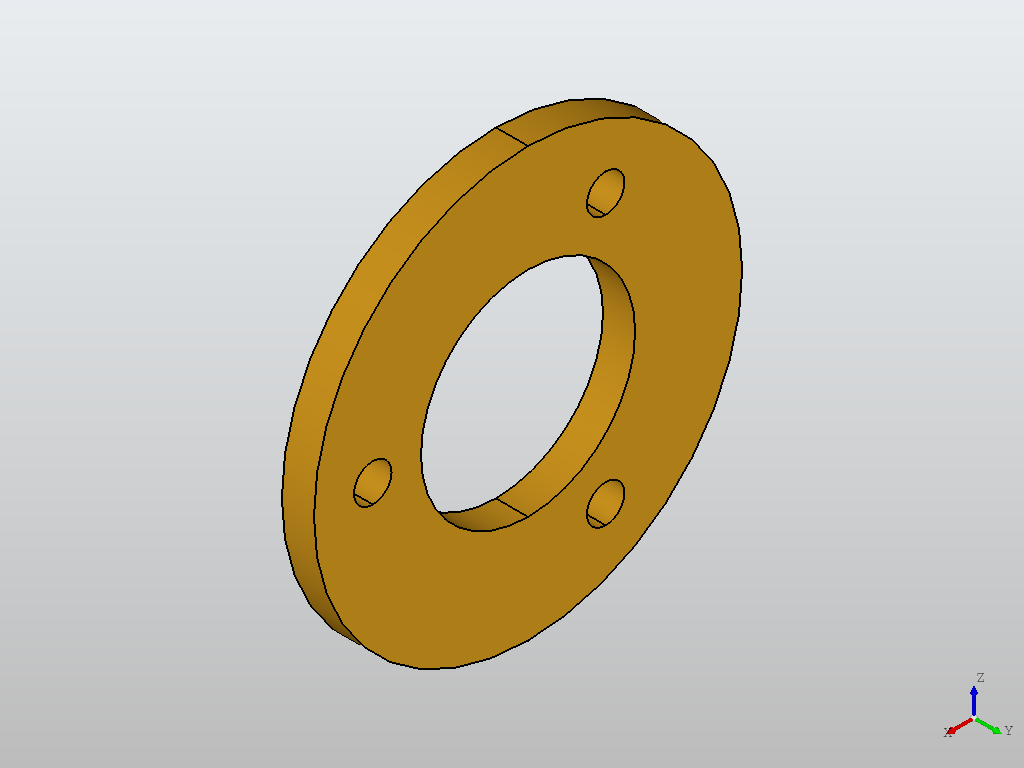

Displaying image for easy_24:


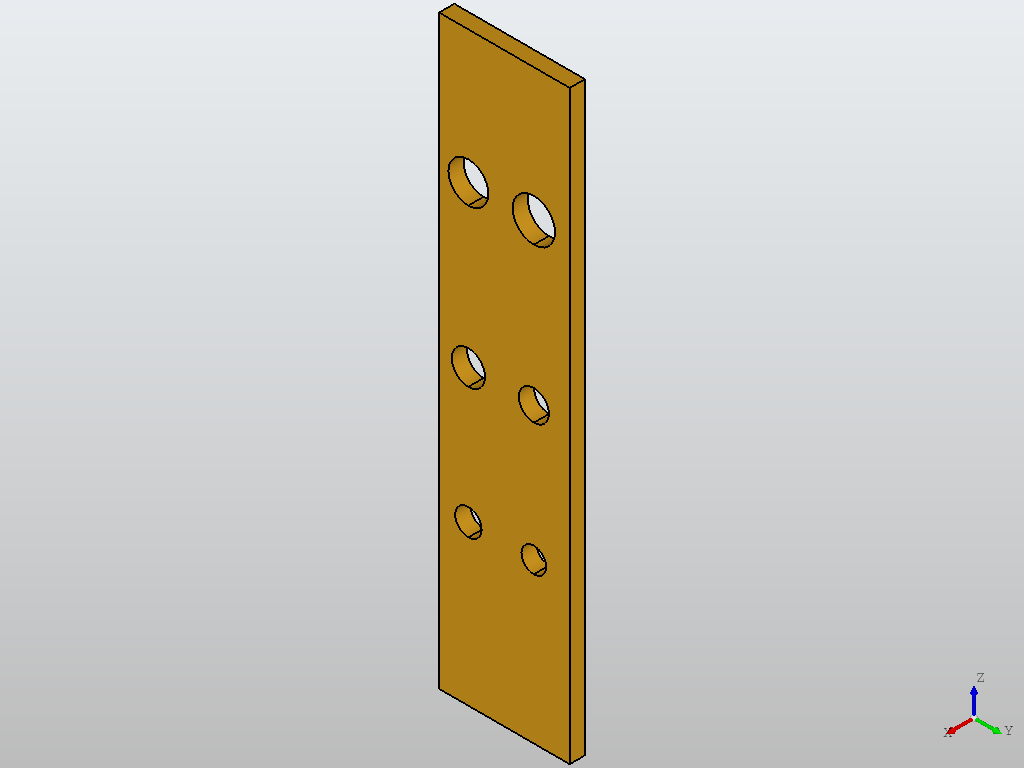

Displaying image for easy_25:


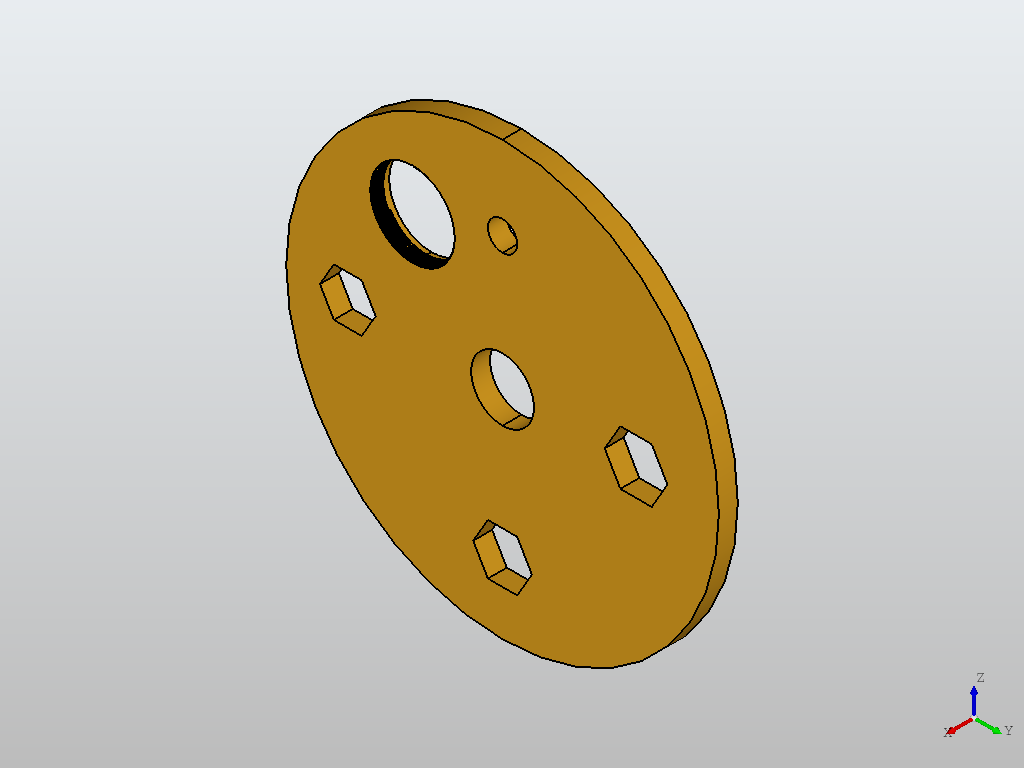

Displaying image for easy_26:


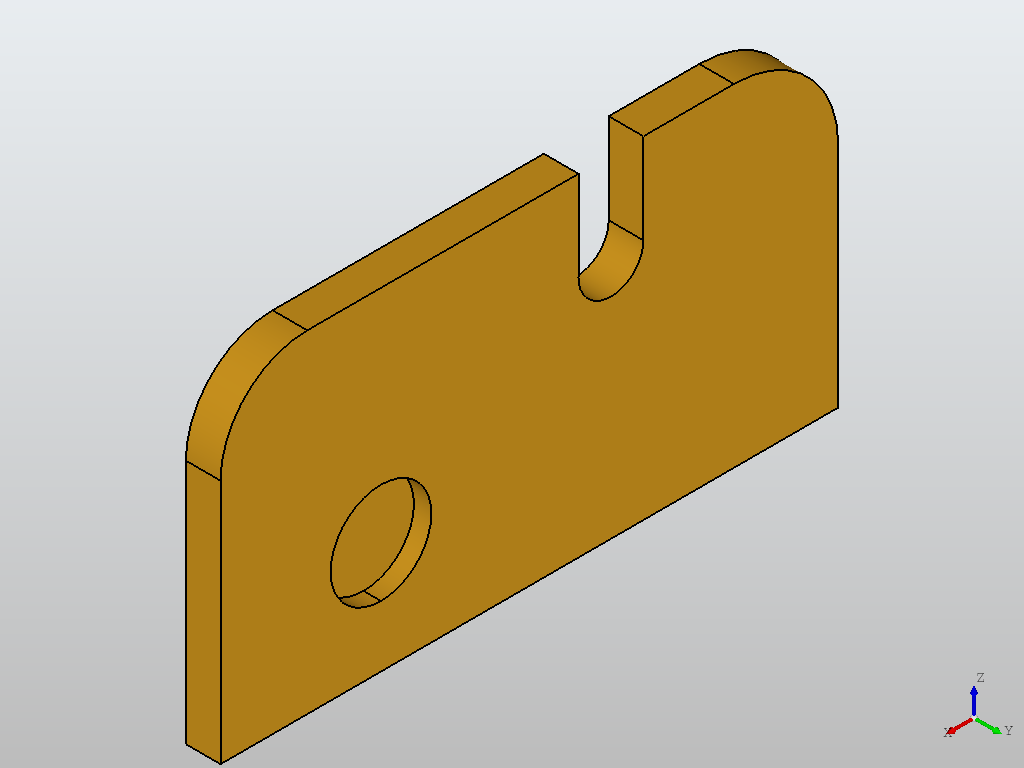

Displaying image for easy_27:


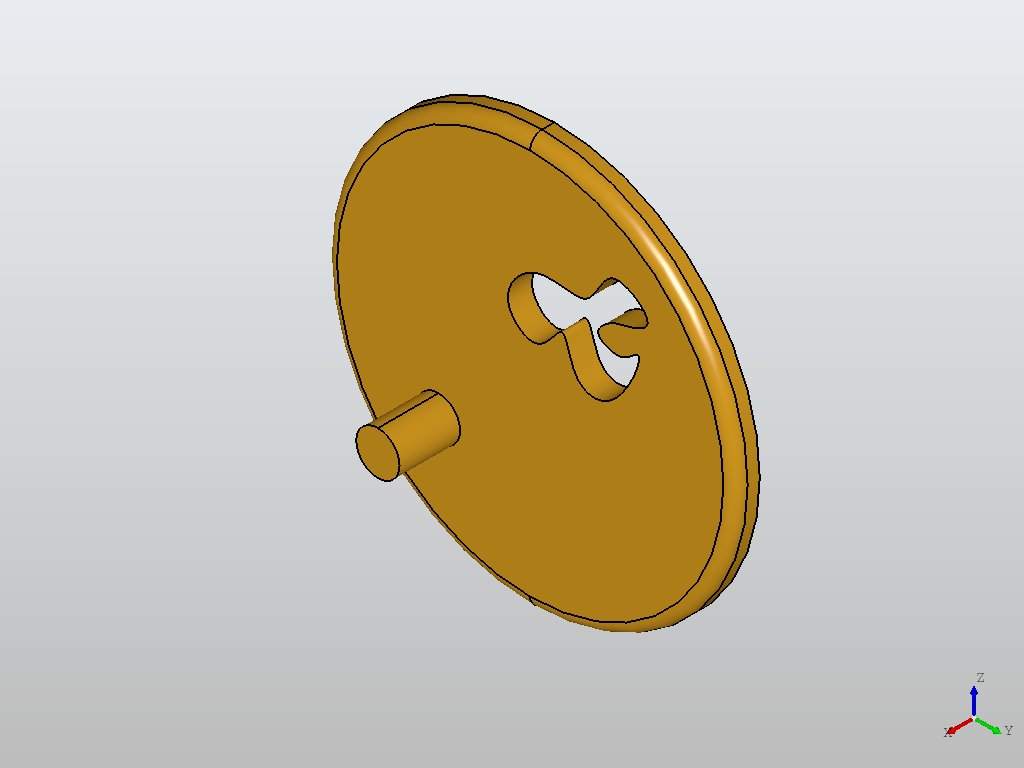

Displaying image for easy_28:


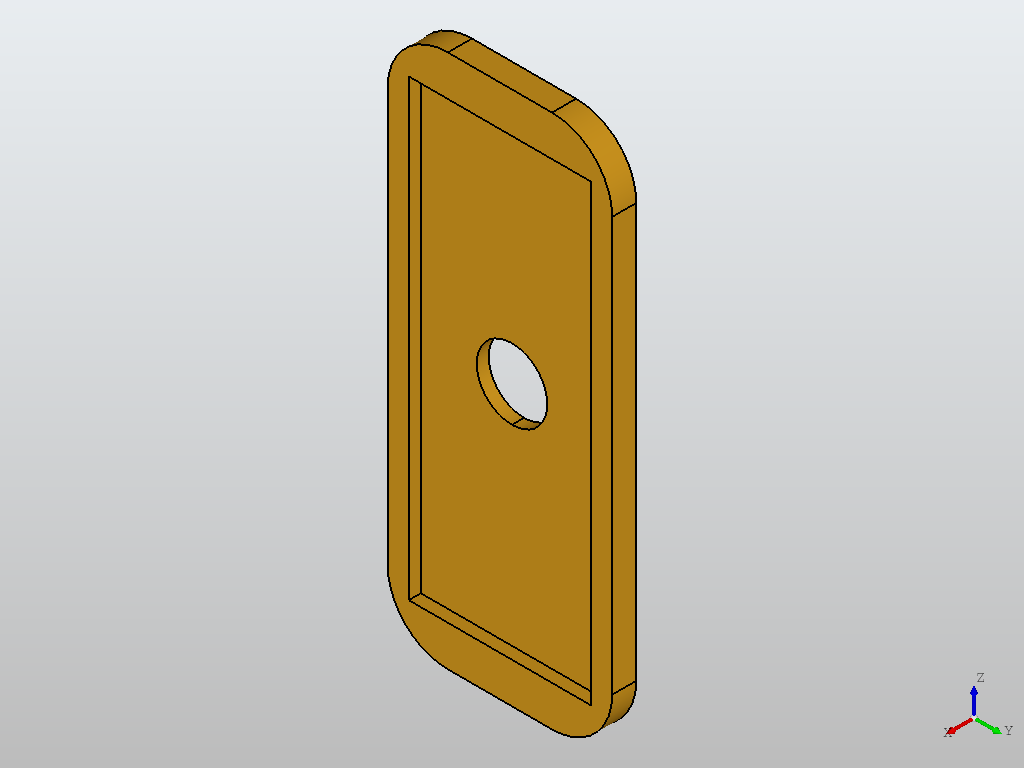

Displaying image for easy_29:


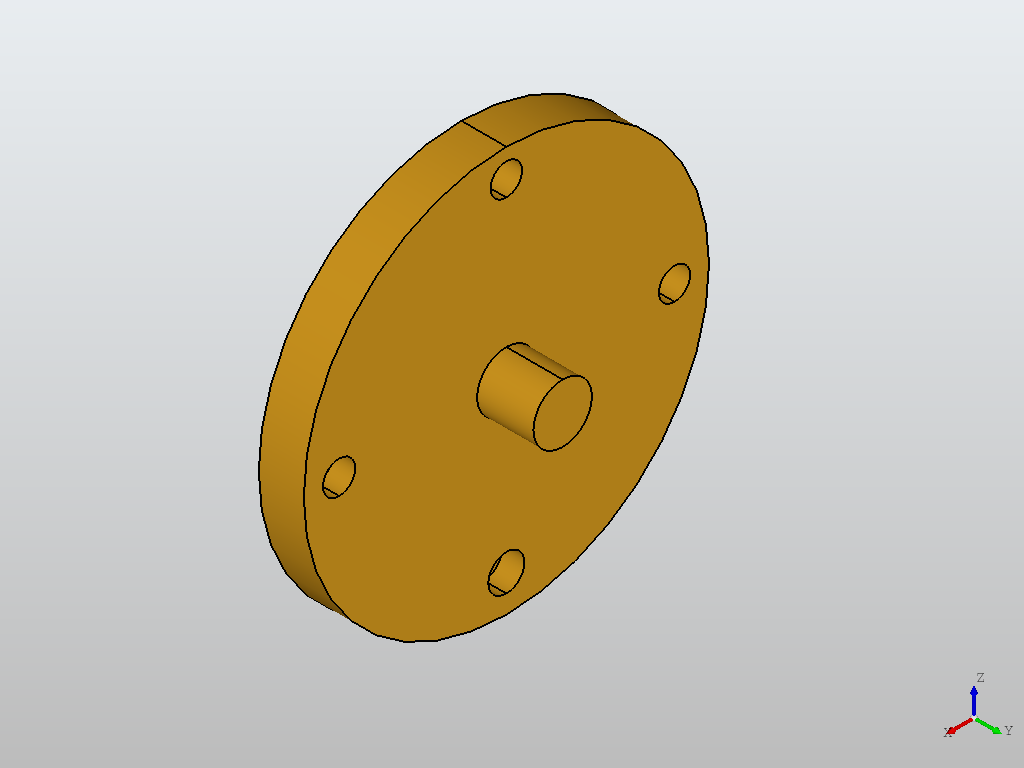

Displaying image for easy_30:


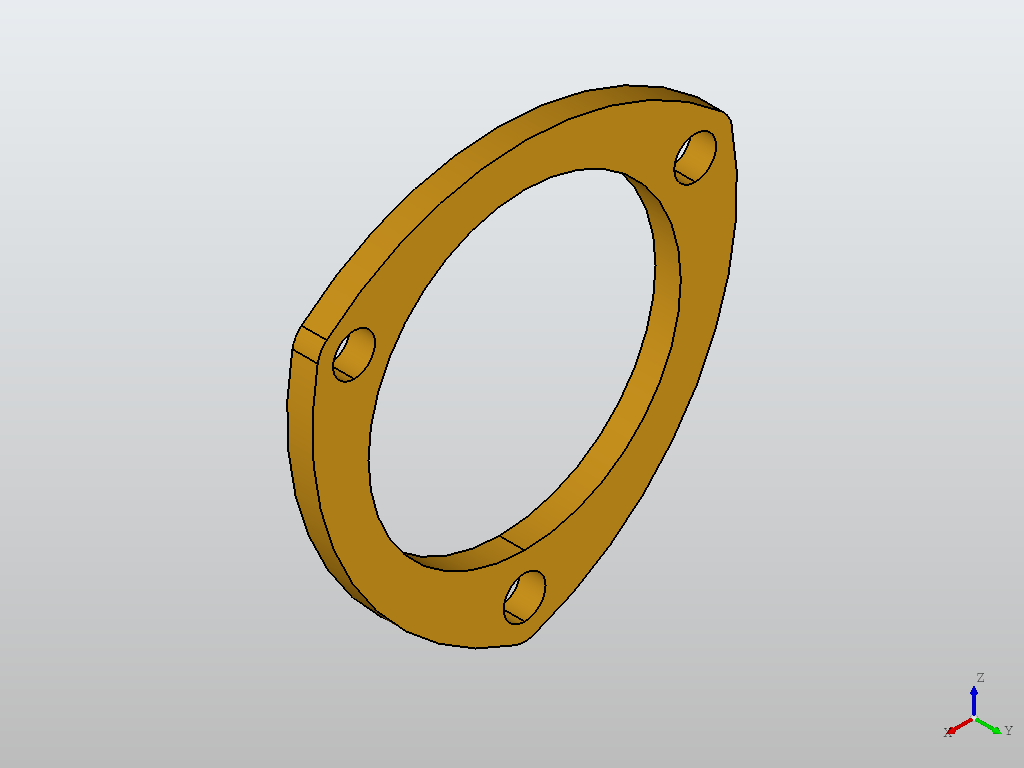

Displaying image for easy_31:


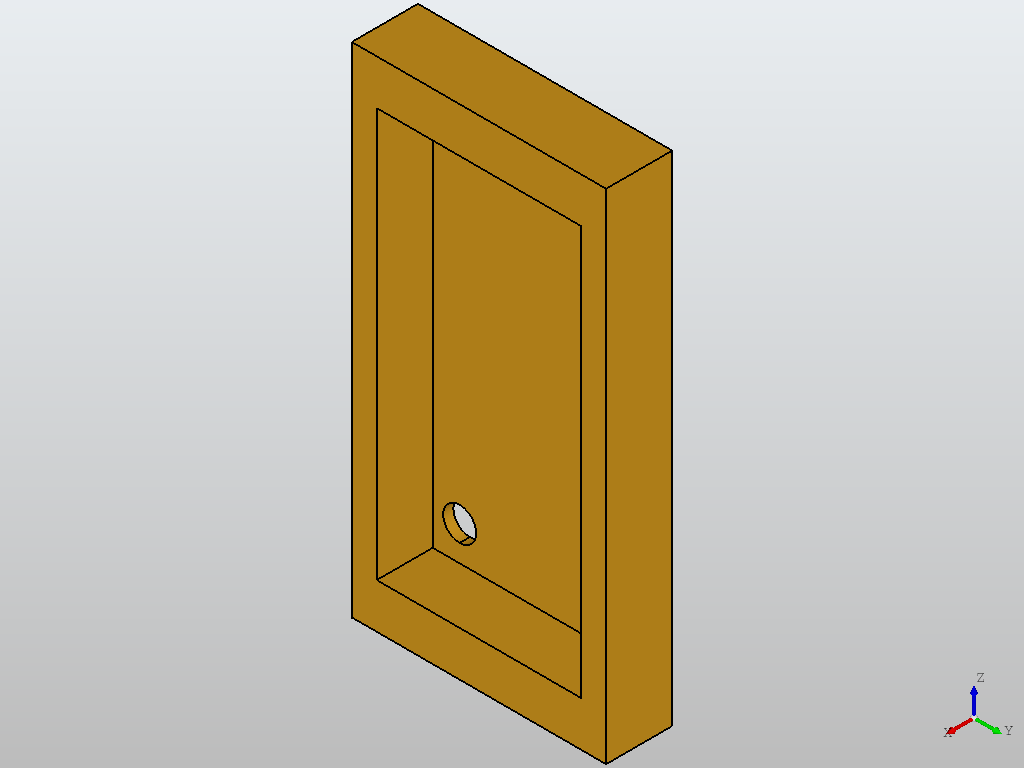

Displaying image for easy_32:


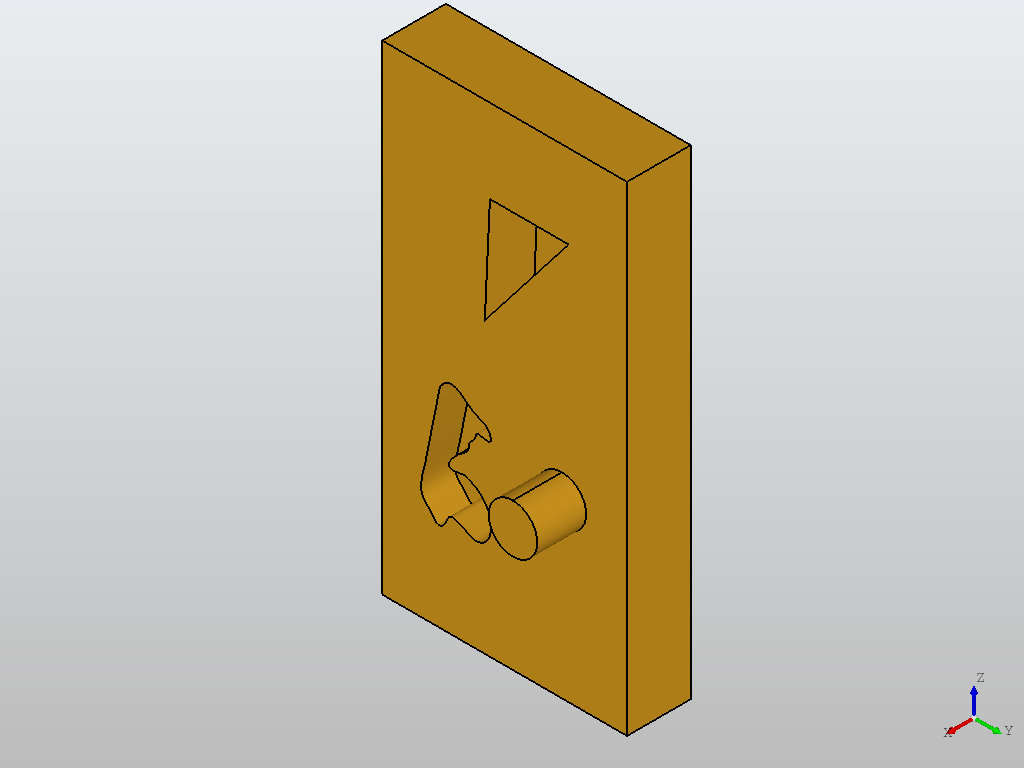

Displaying image for easy_33:


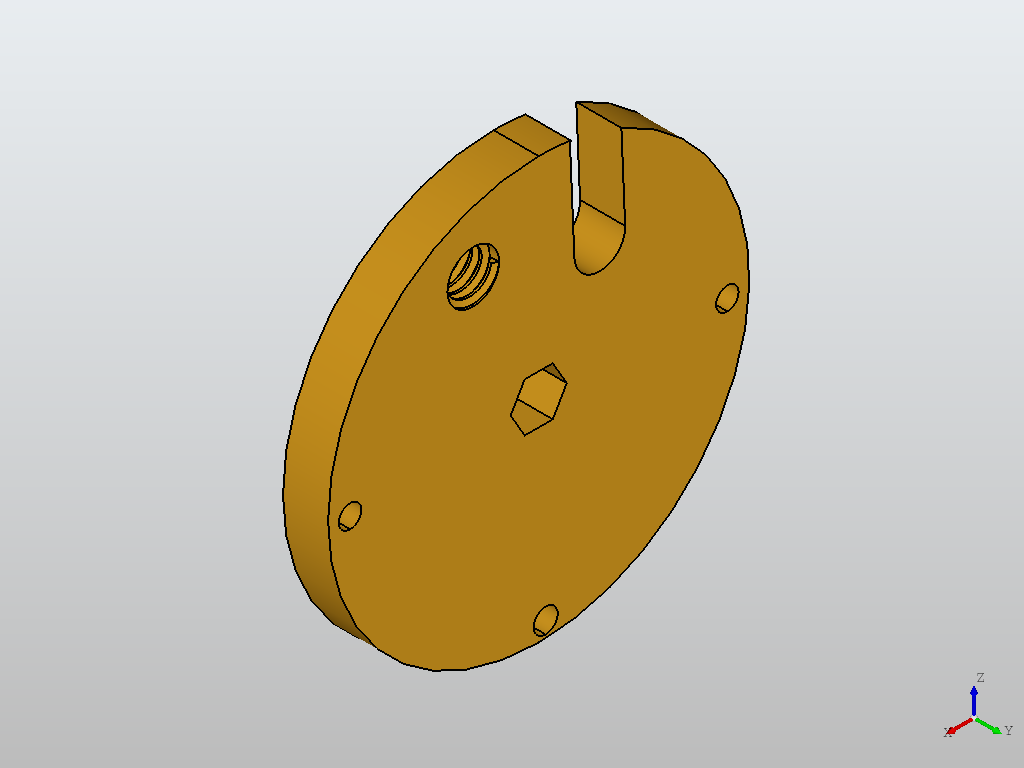

Displaying image for medium_9:


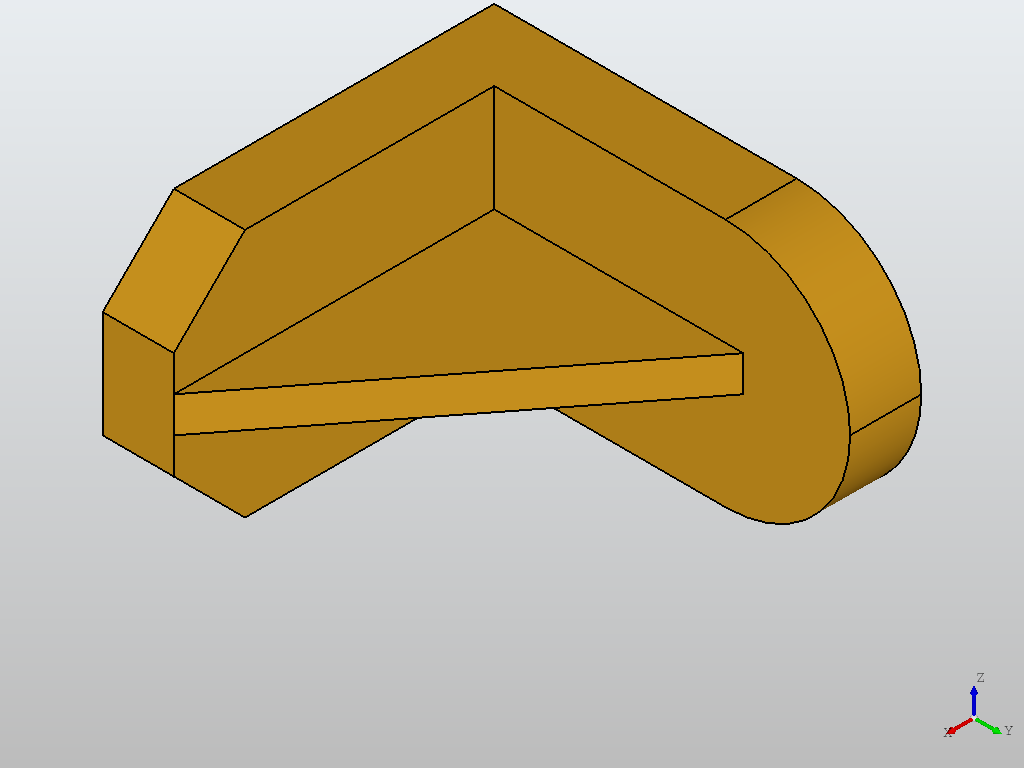

Displaying image for medium_12:


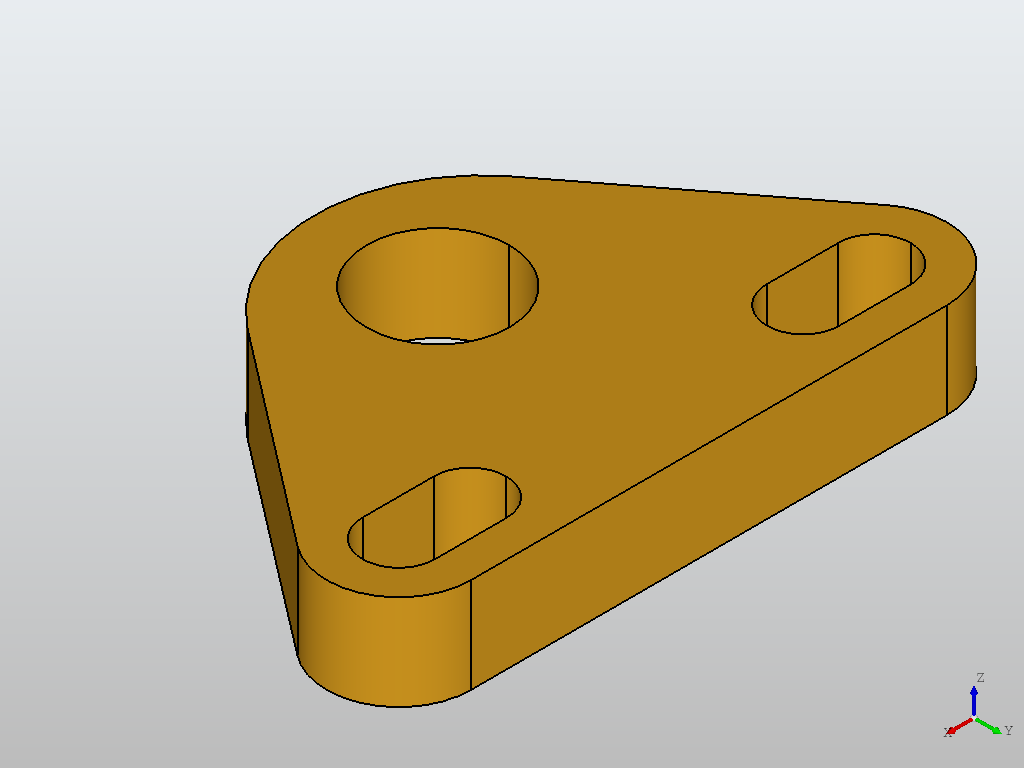

Displaying image for medium_21:


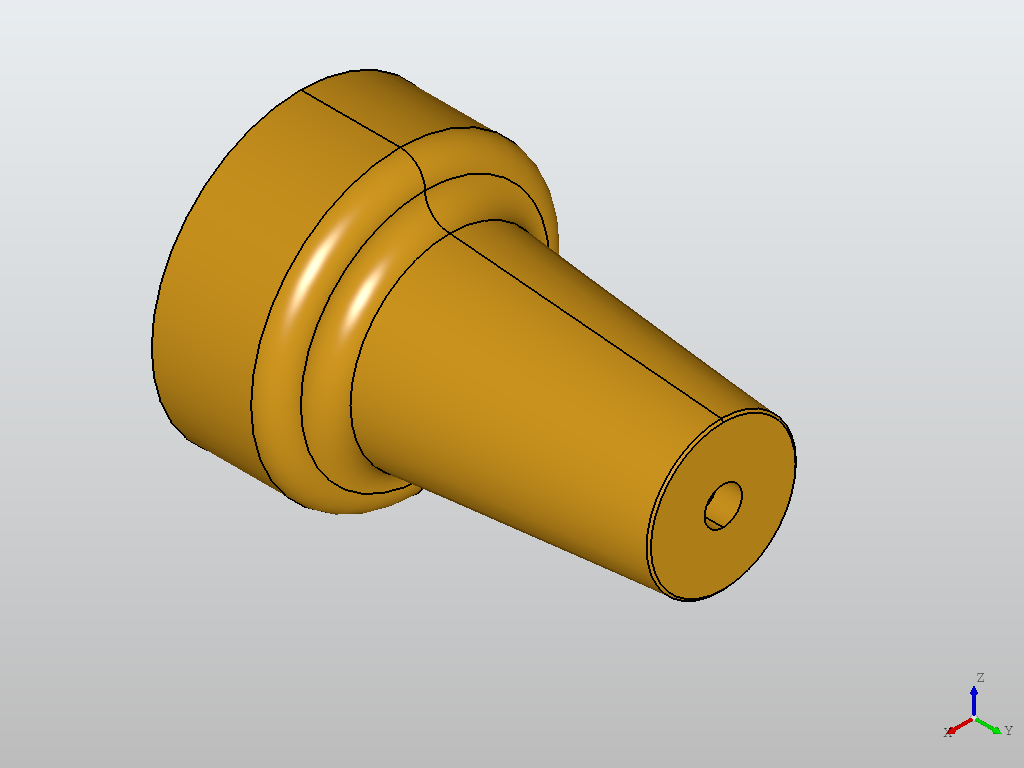

Displaying image for medium_22:


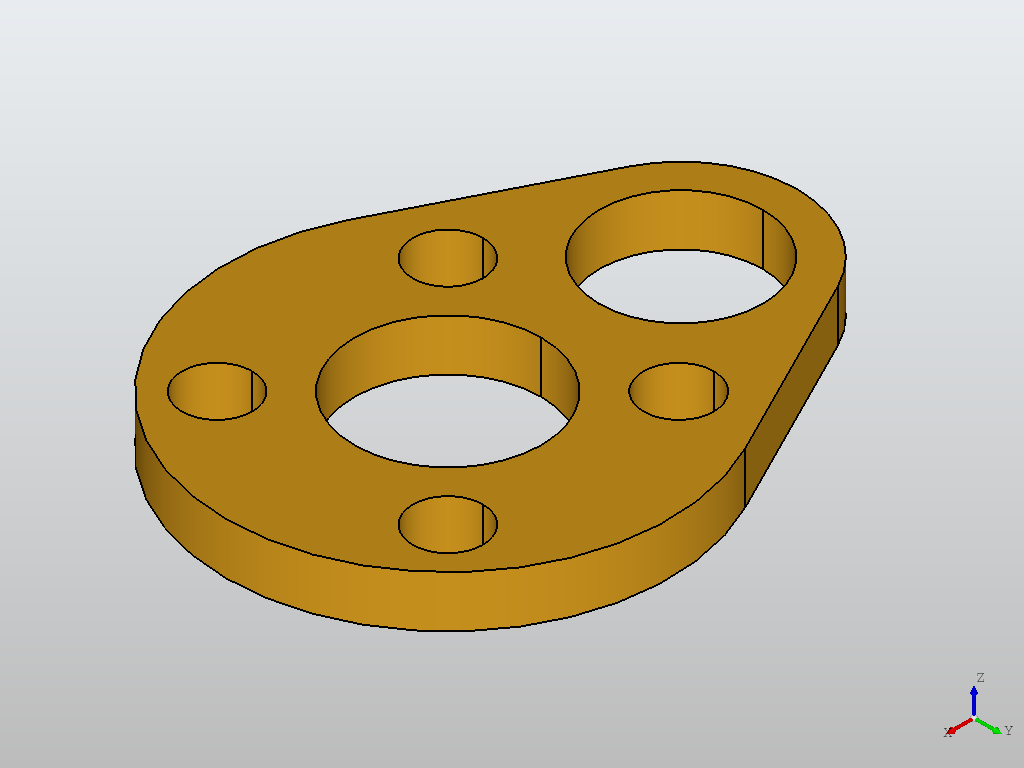

Displaying image for medium_23:


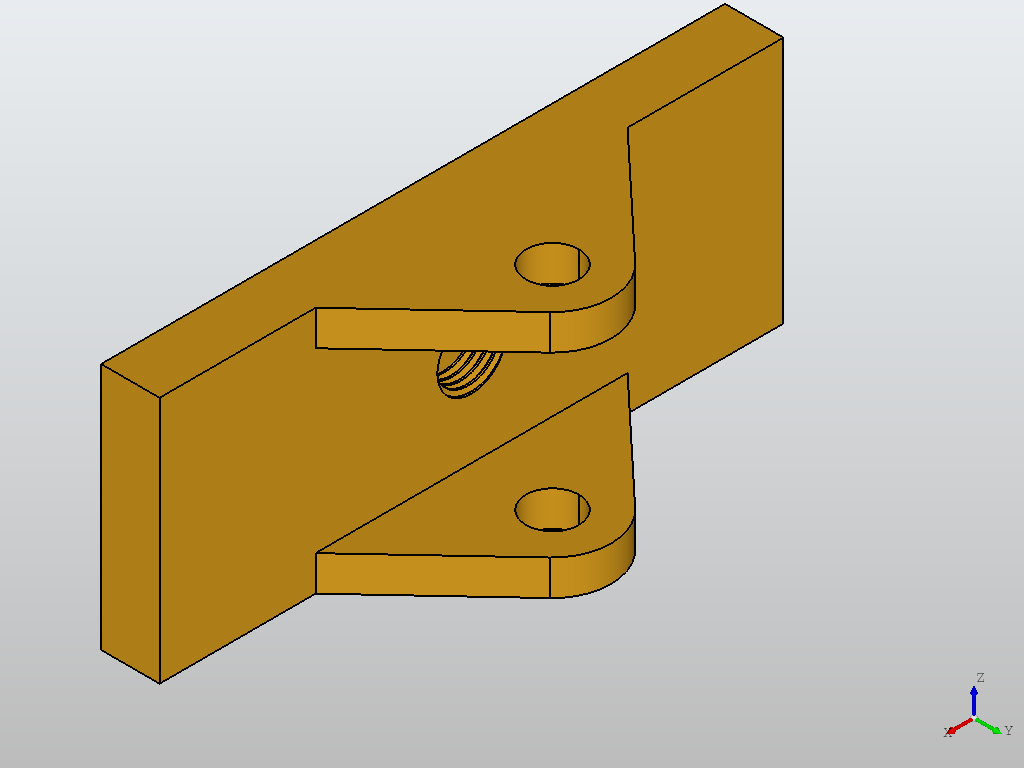

Displaying image for medium_24:


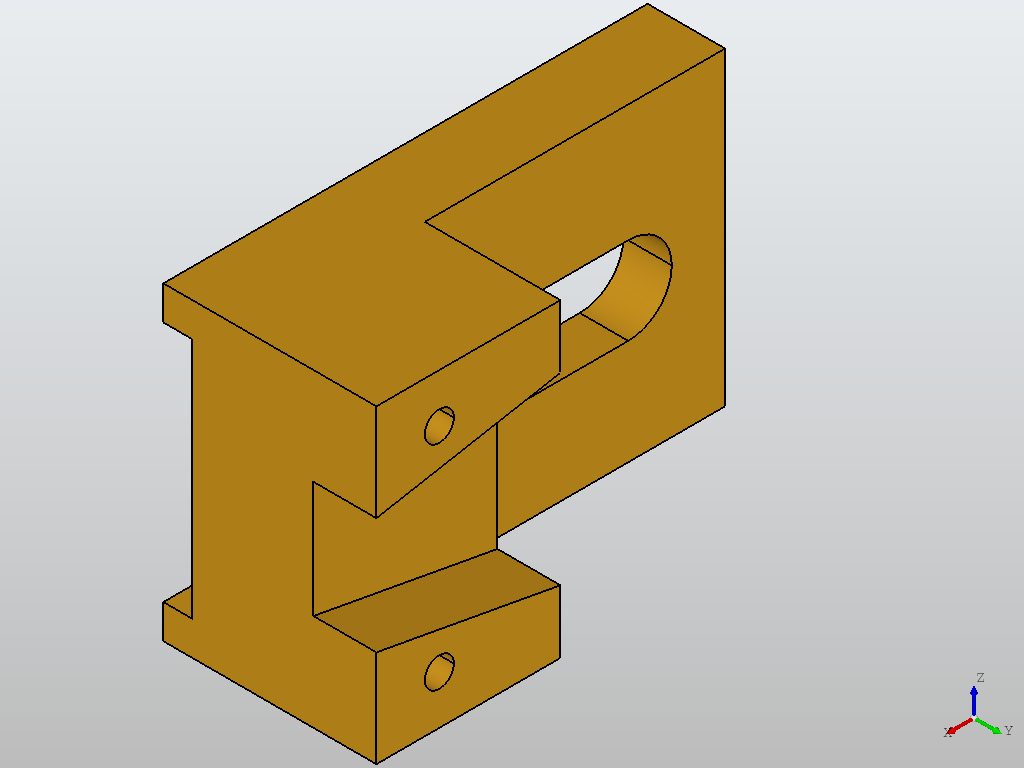

Displaying image for medium_25:


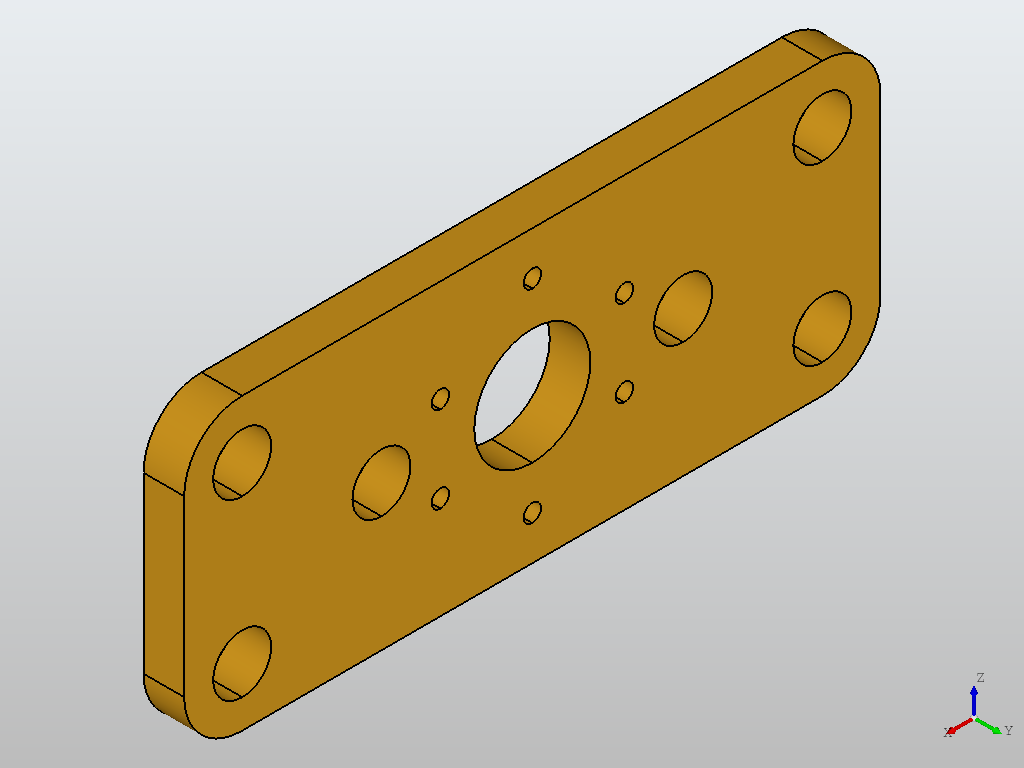

Displaying image for medium_26:


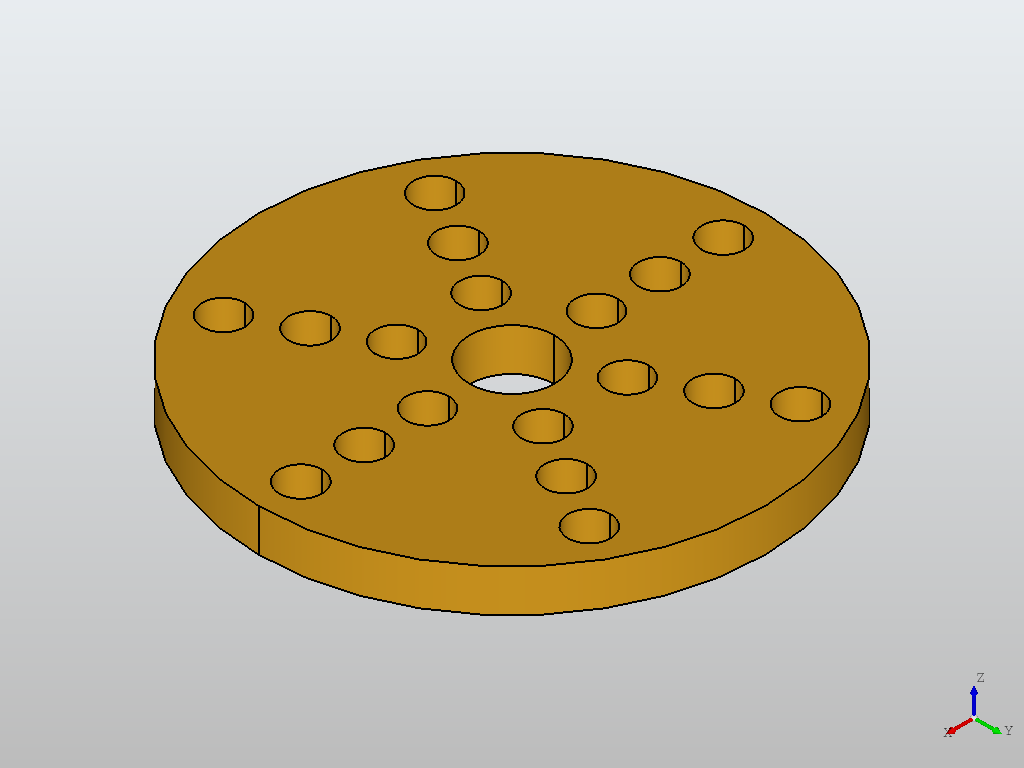

Displaying image for medium_27:


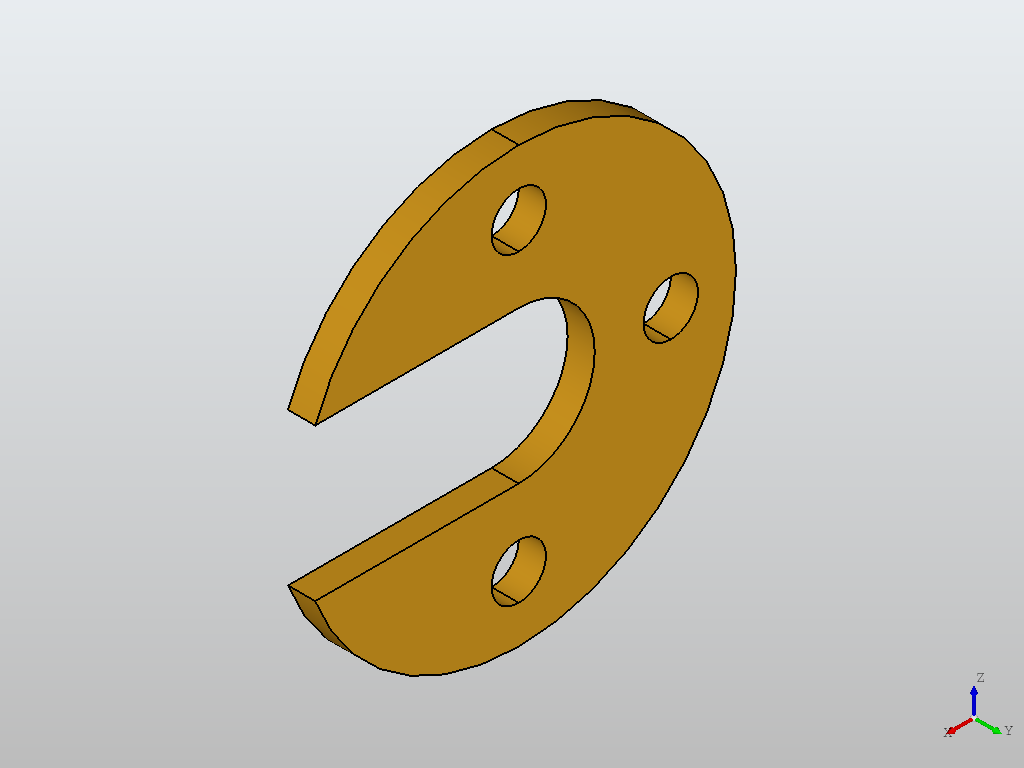

Displaying image for medium_28:


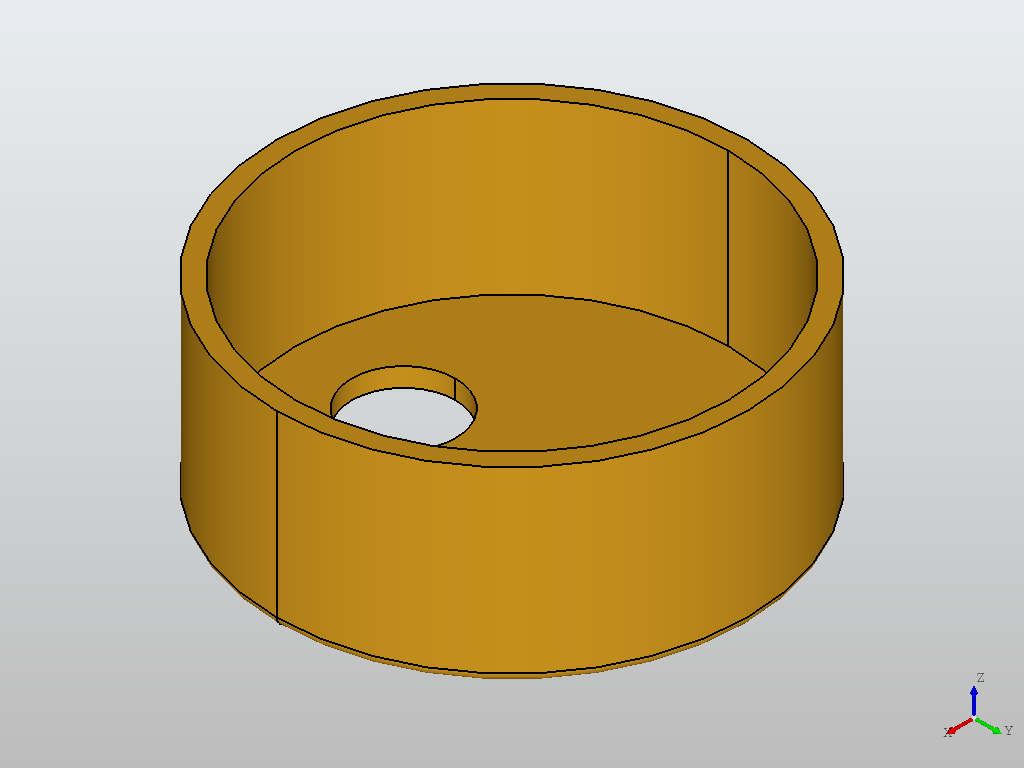

Displaying image for medium_29:


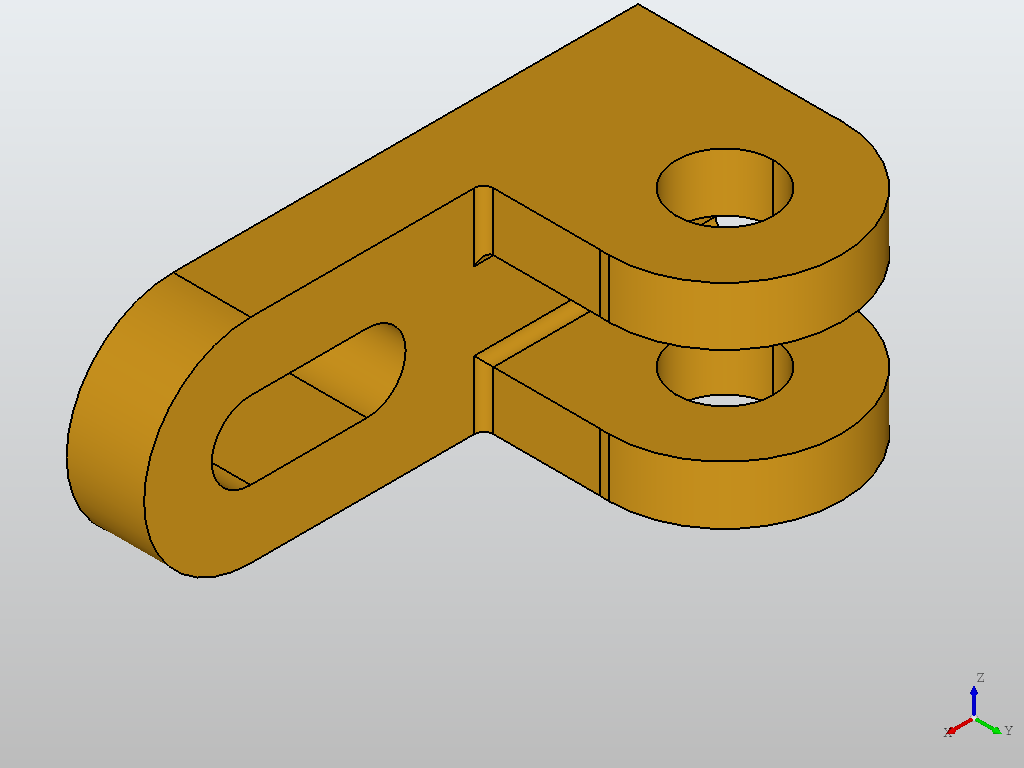

Displaying image for medium_30:


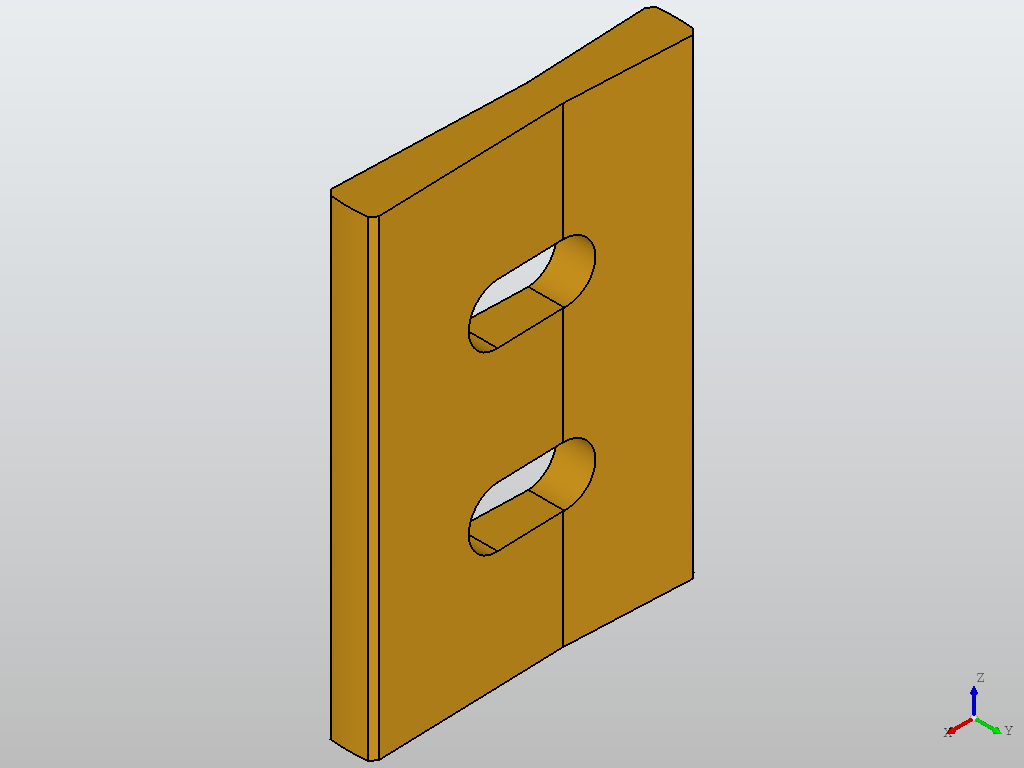

Displaying image for medium_31:


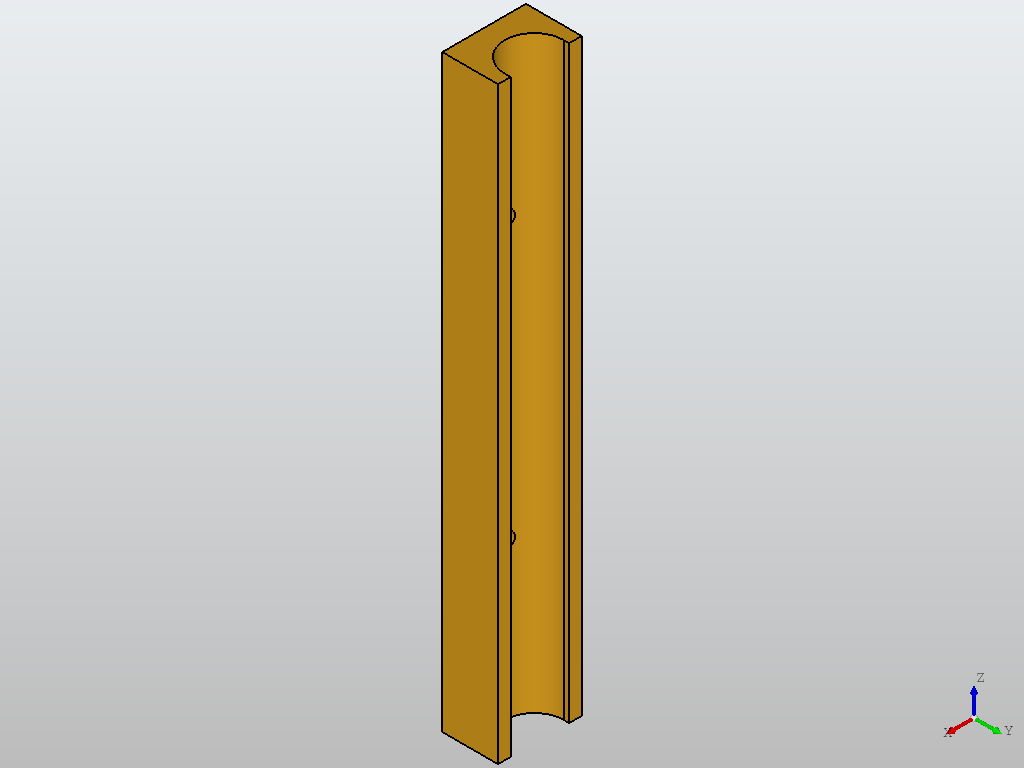

Displaying image for medium_32:


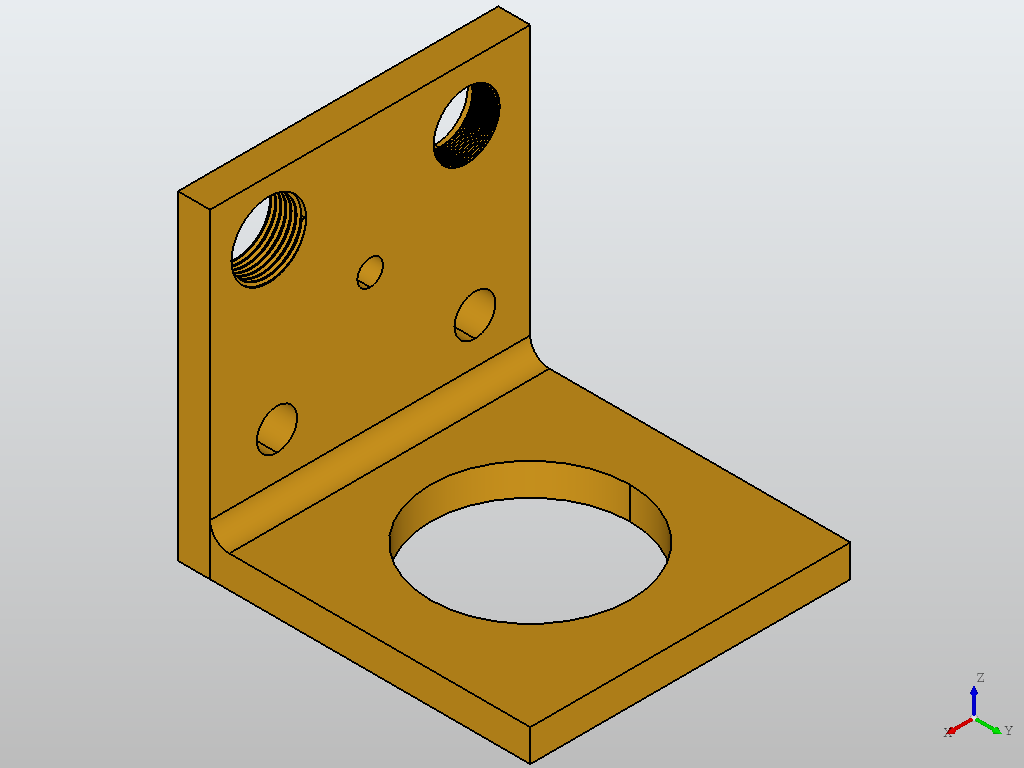

Displaying image for medium_33:


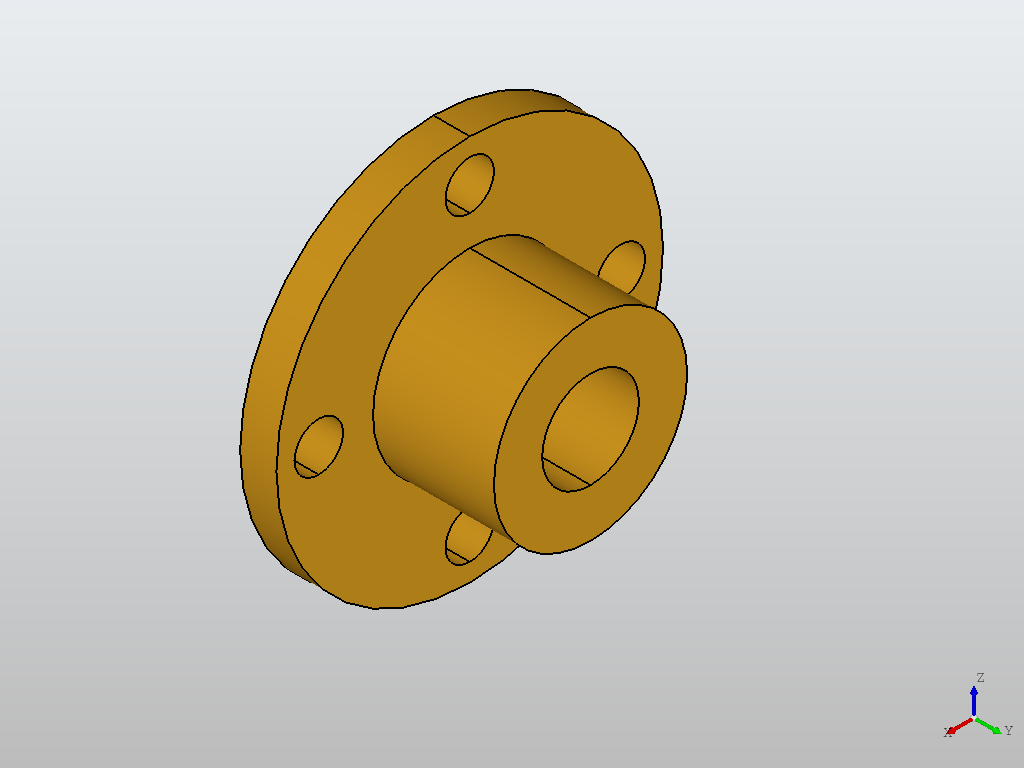

Displaying image for hard_6:


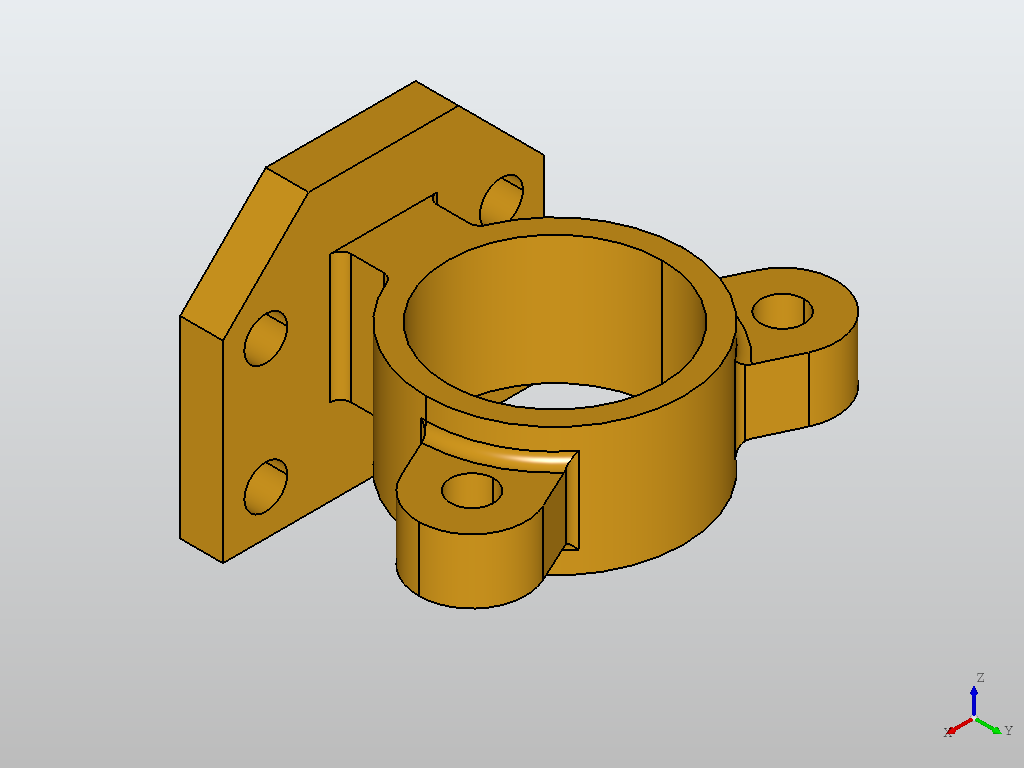

Displaying image for hard_11:


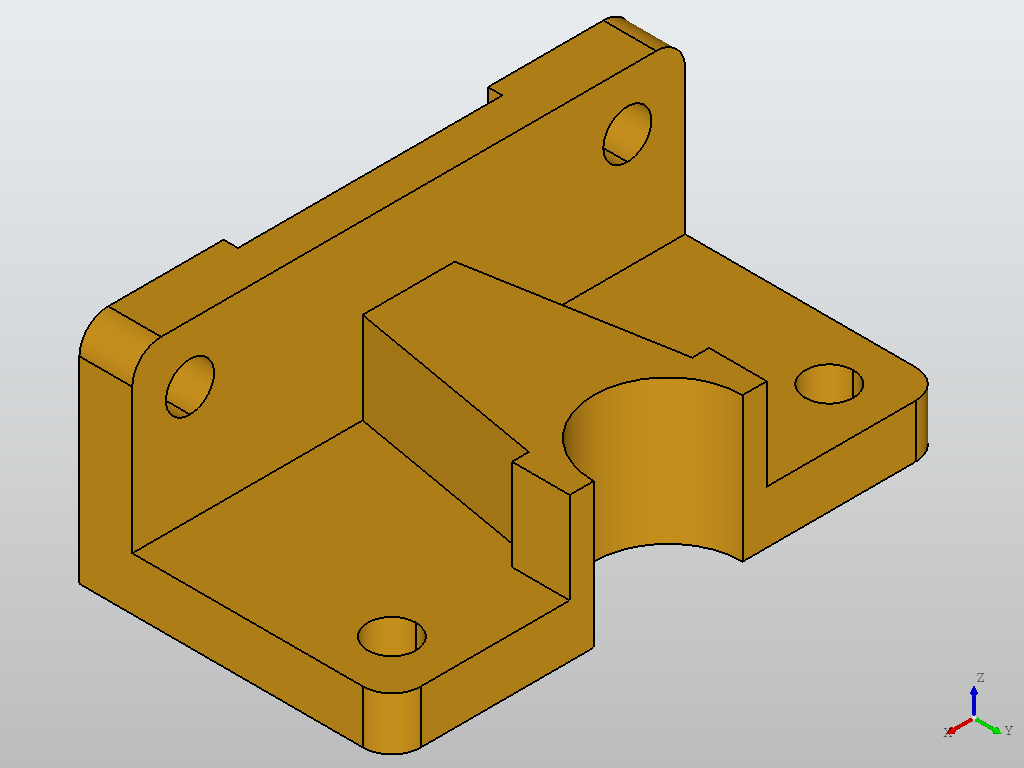

Displaying image for hard_13:


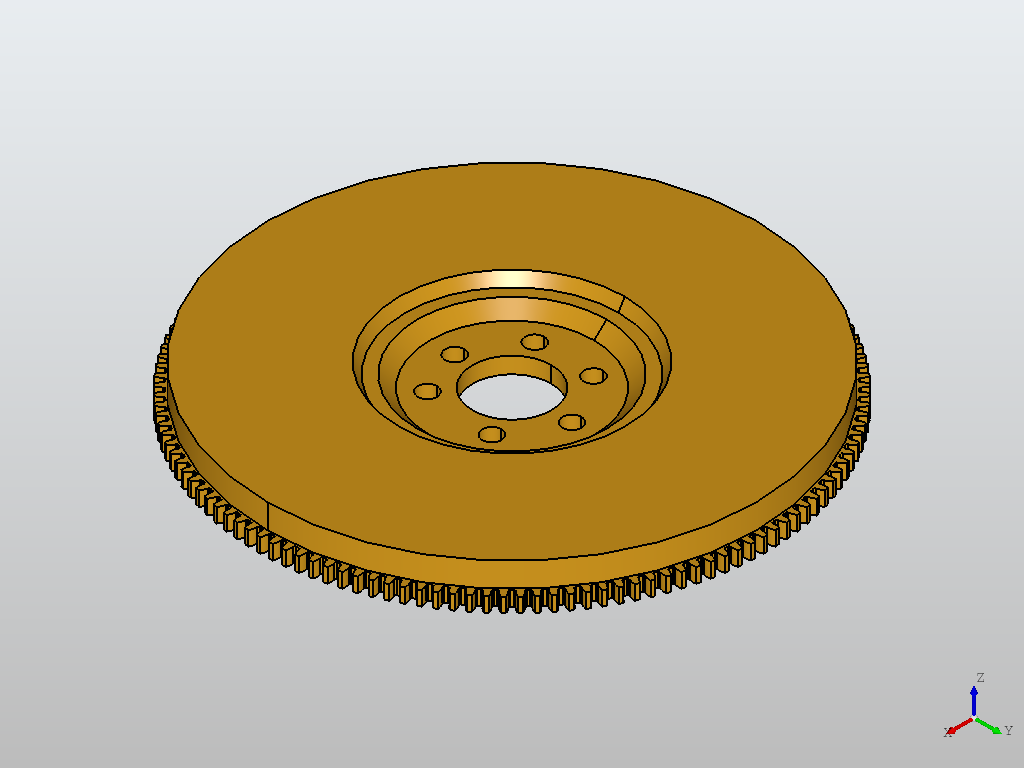

Displaying image for hard_16:


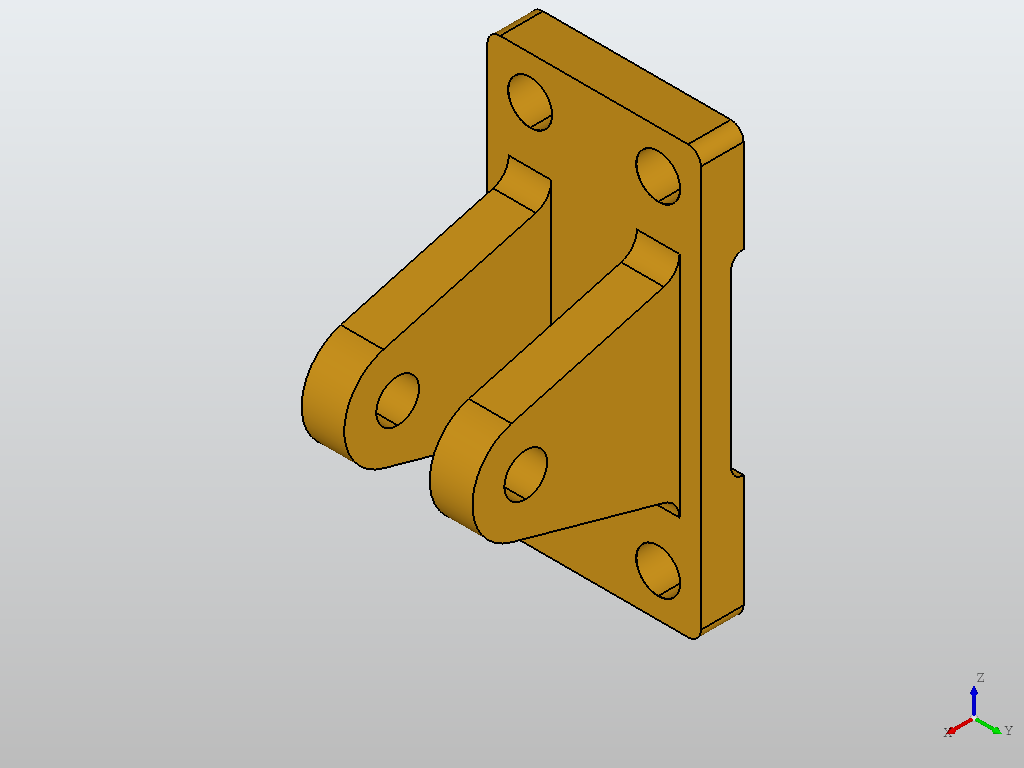

Displaying image for hard_17:


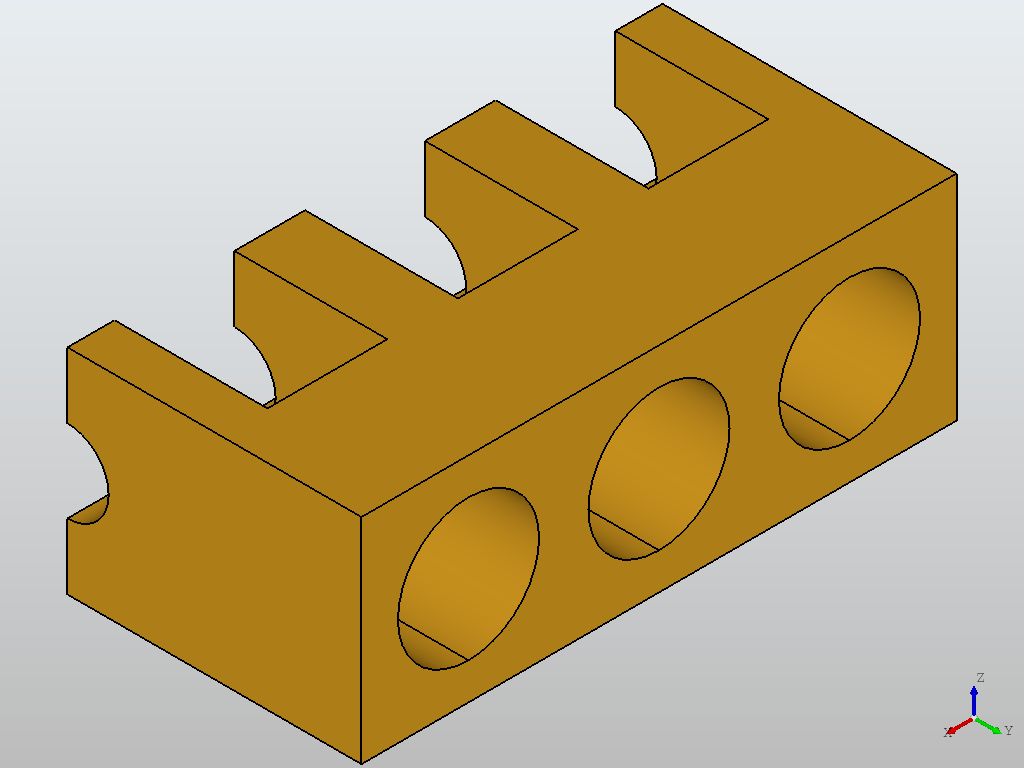

Displaying image for hard_18:


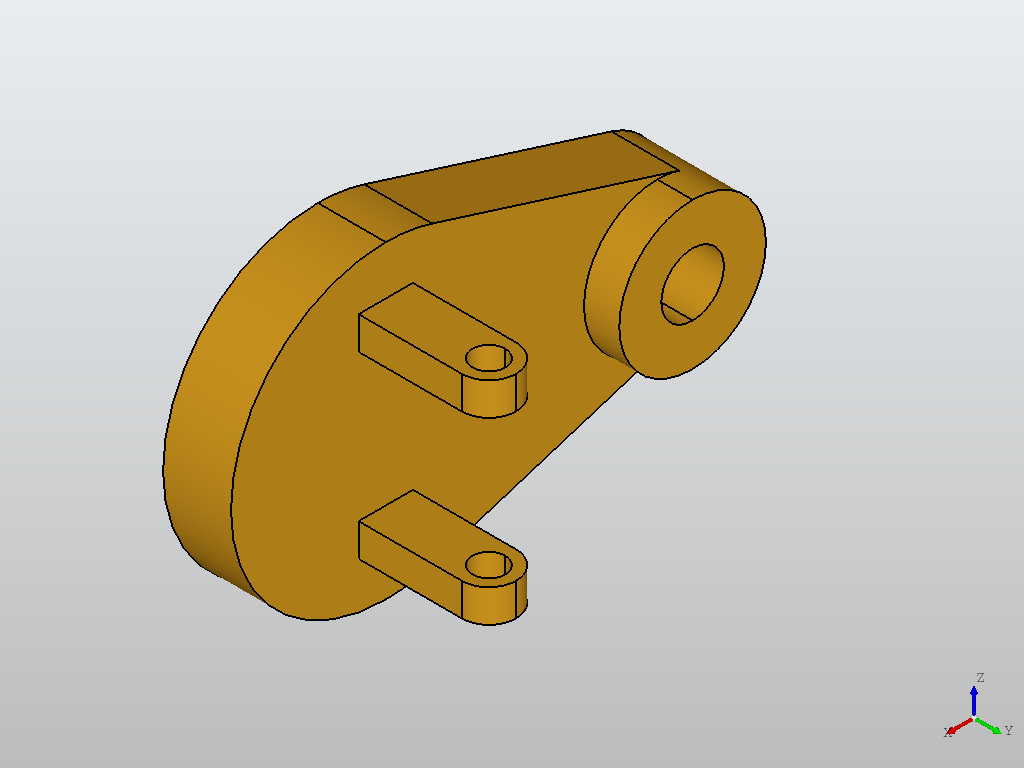

Displaying image for hard_19:


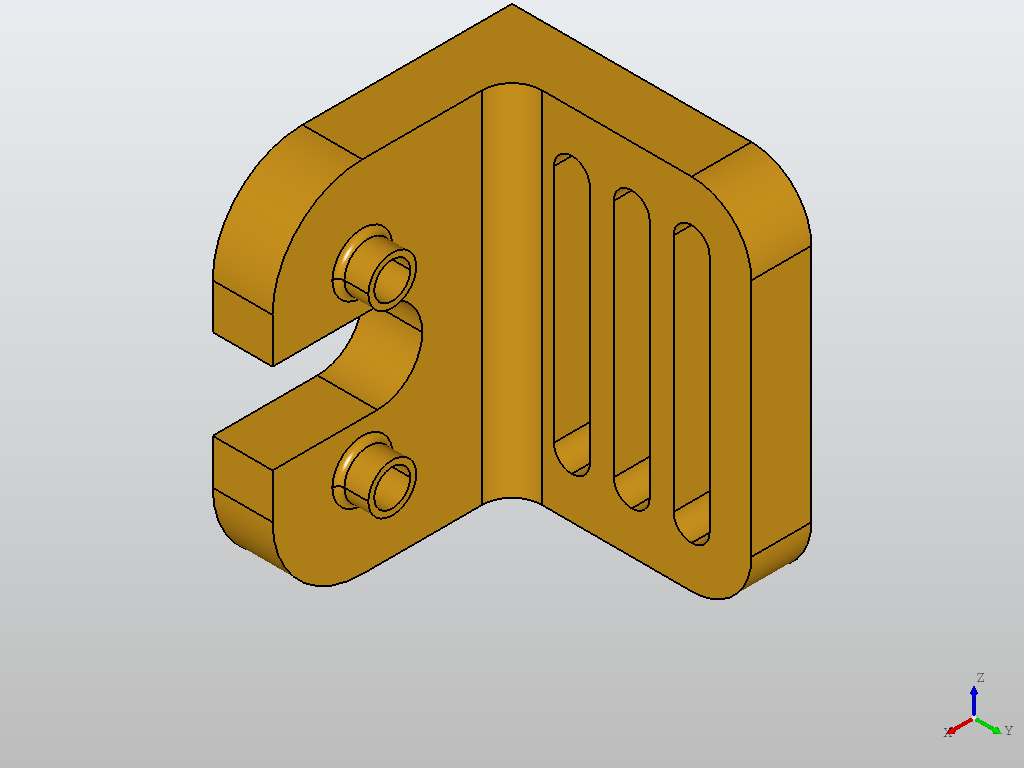

Displaying image for hard_20:


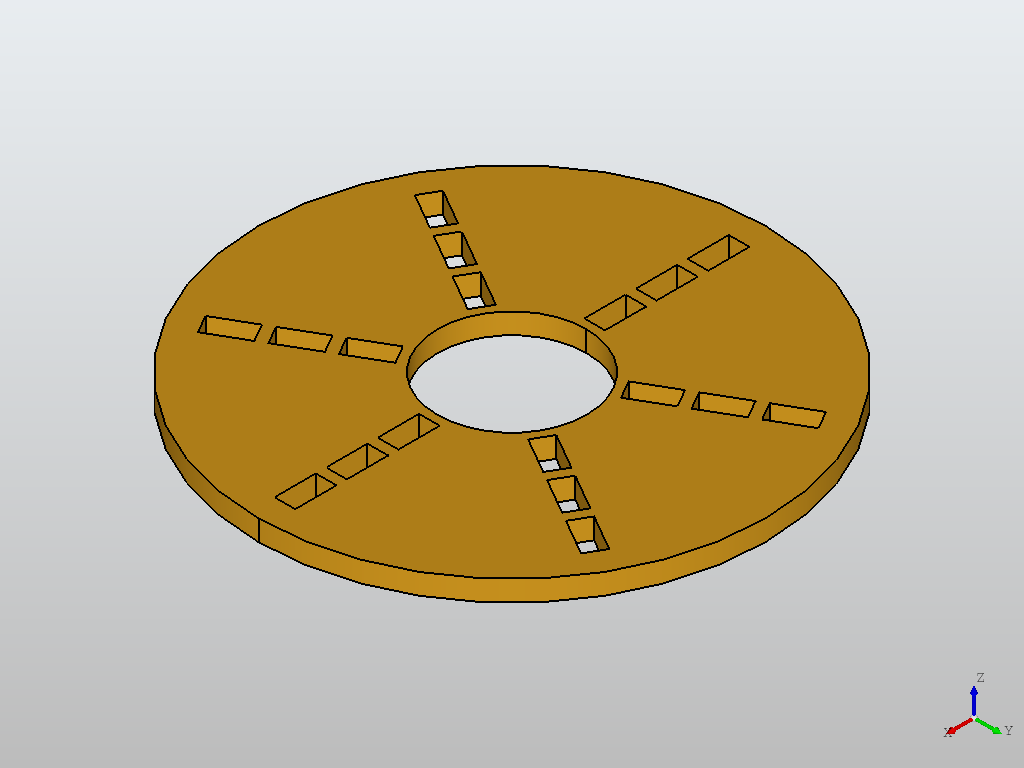

Displaying image for hard_21:


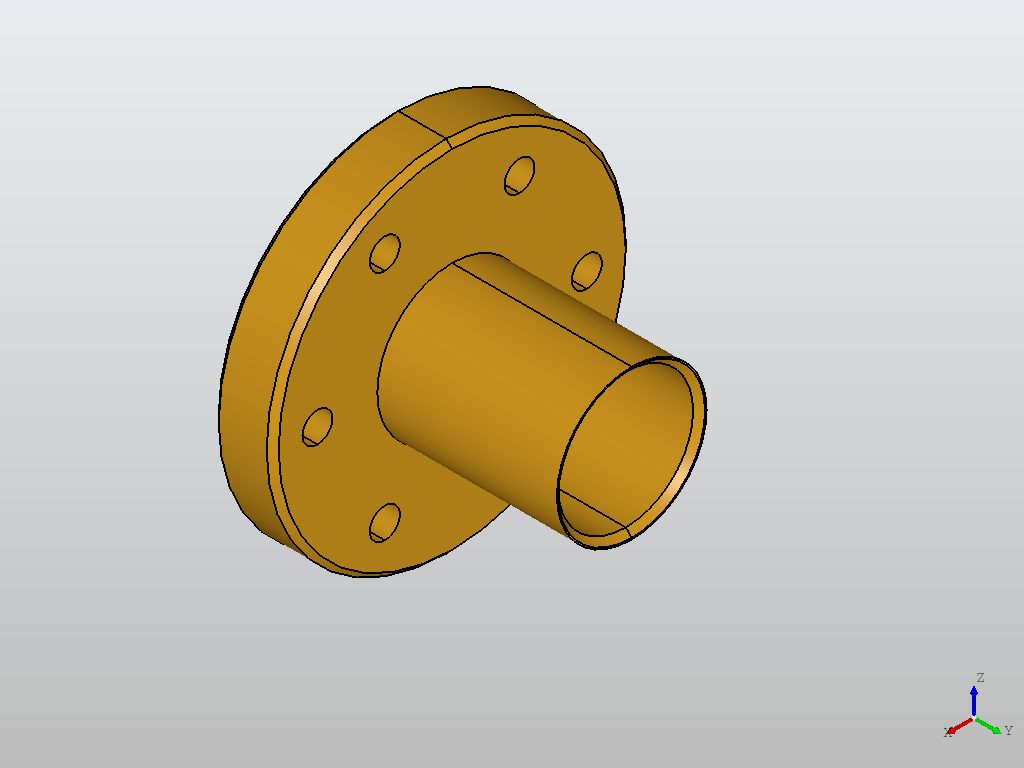

Displaying image for hard_22:


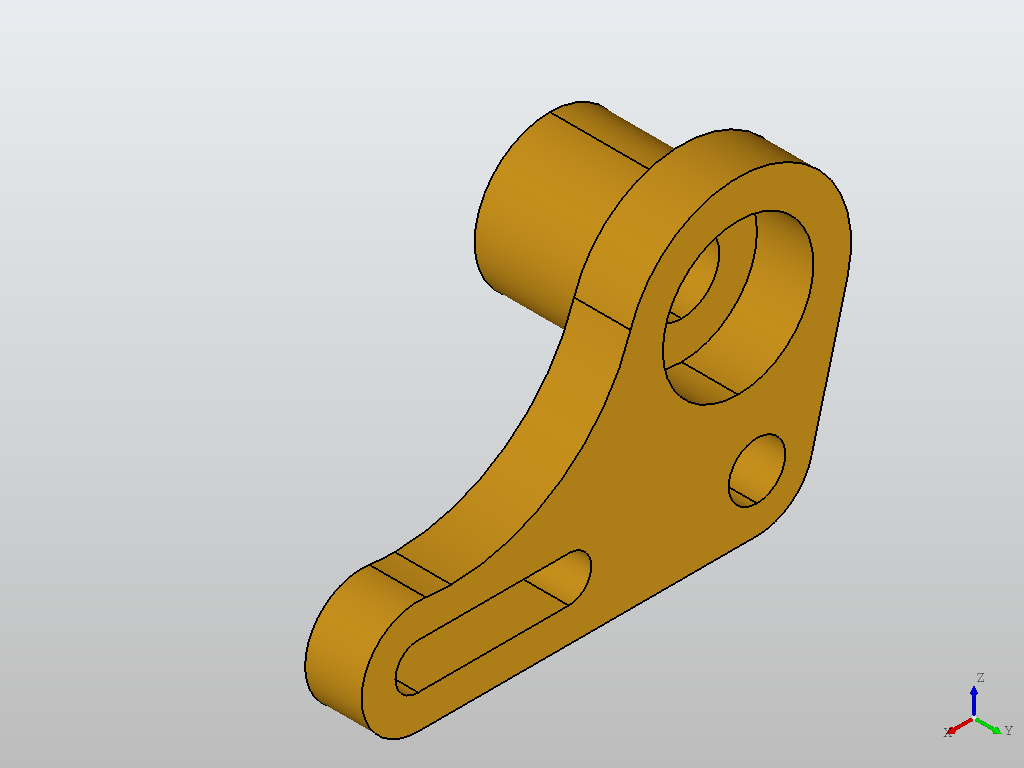

Displaying image for hard_23:


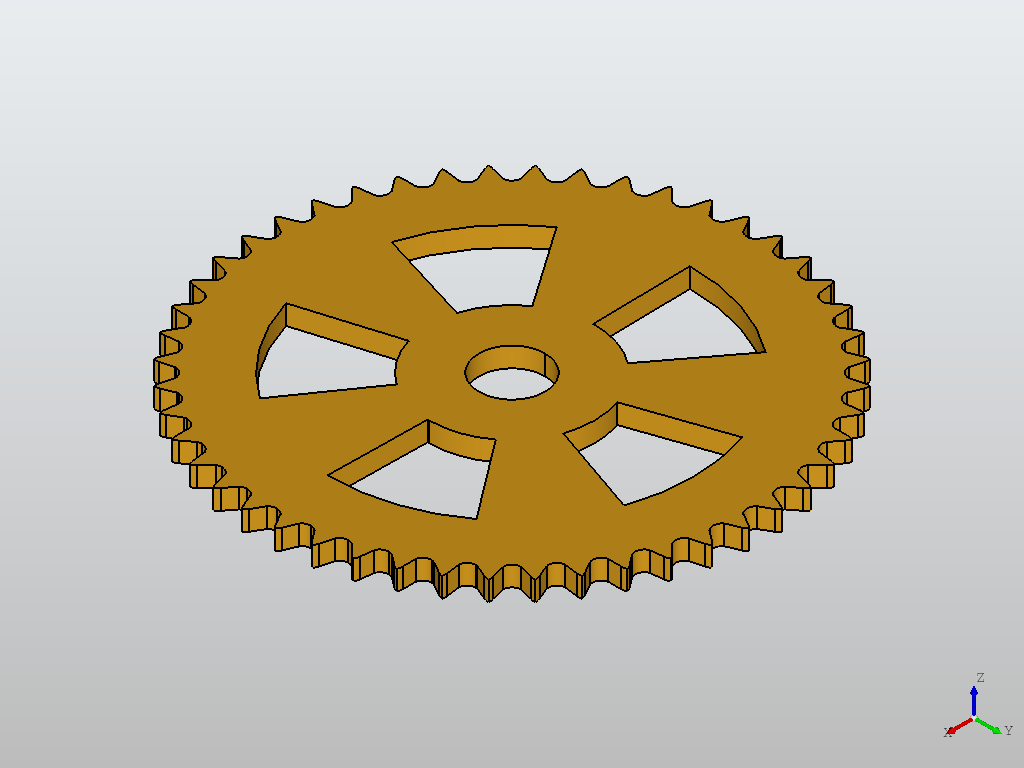

Displaying image for hard_24:


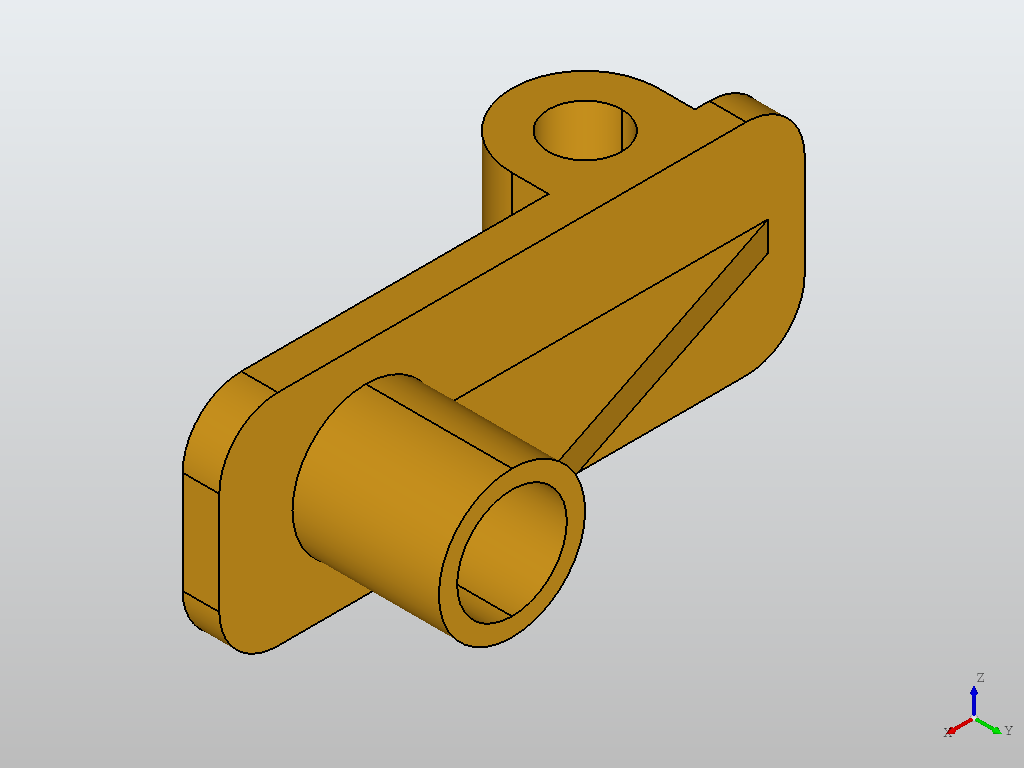

Displaying image for hard_25:


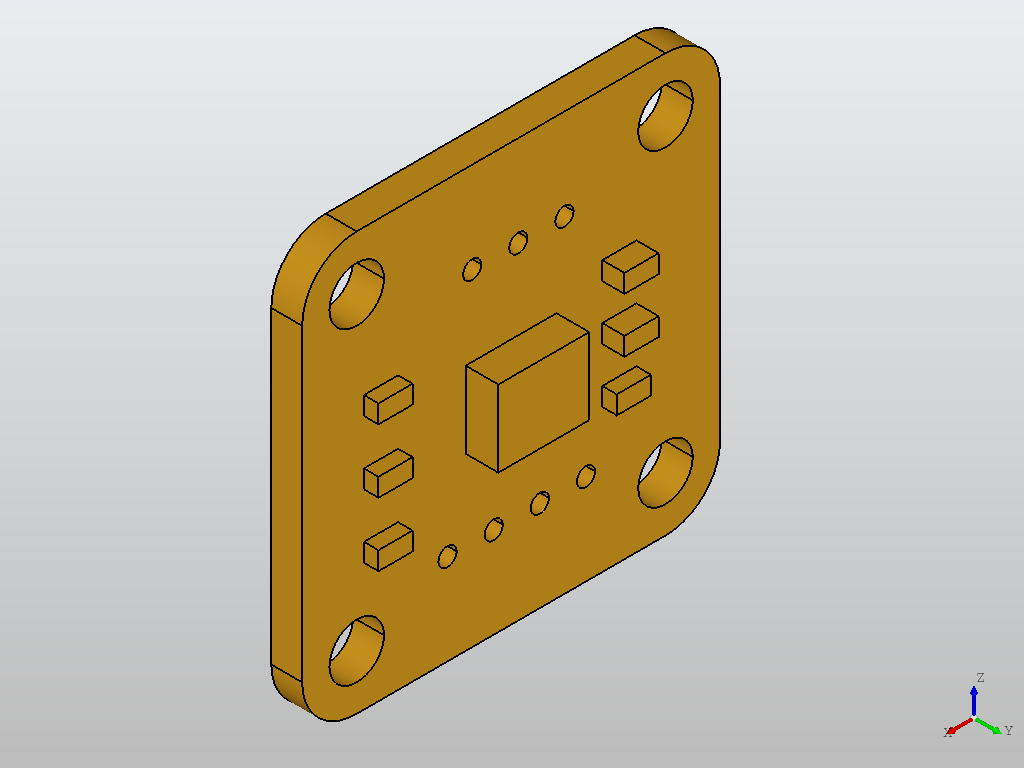

Displaying image for hard_26:


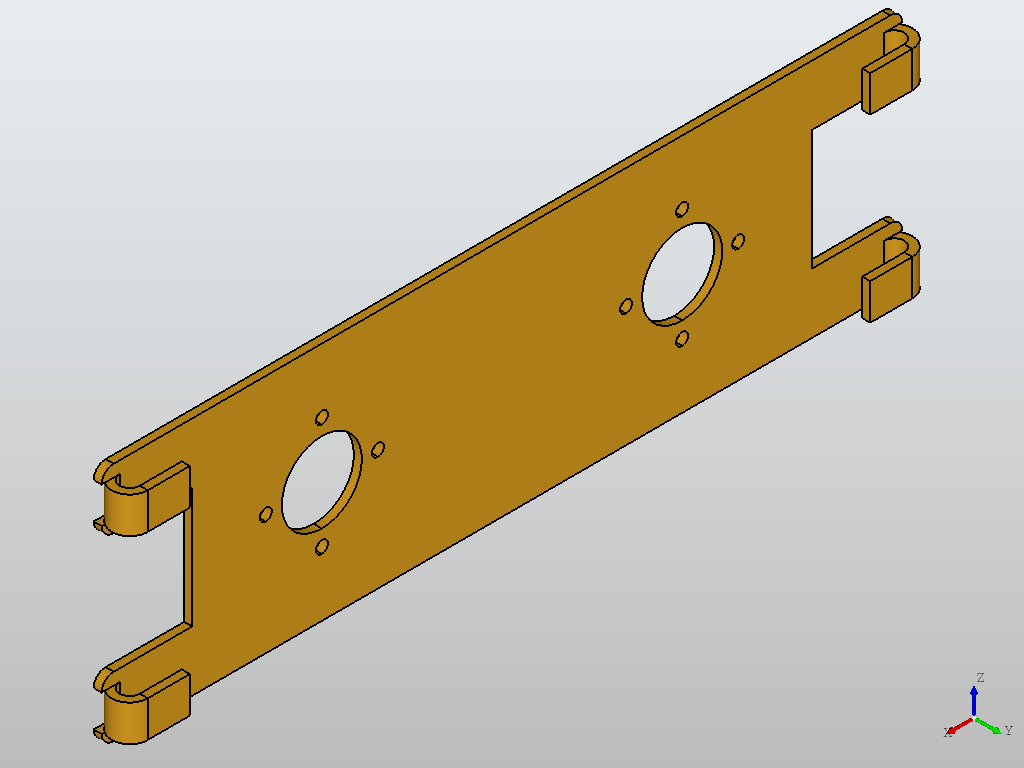

Displaying image for hard_27:


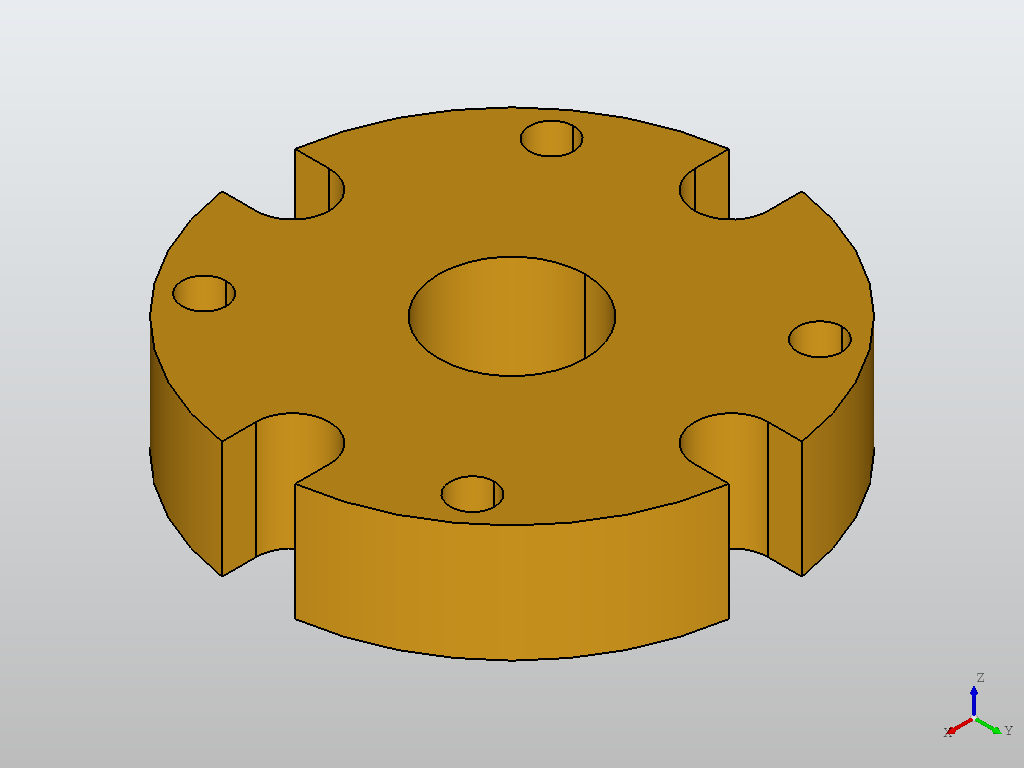

Displaying image for hard_28:


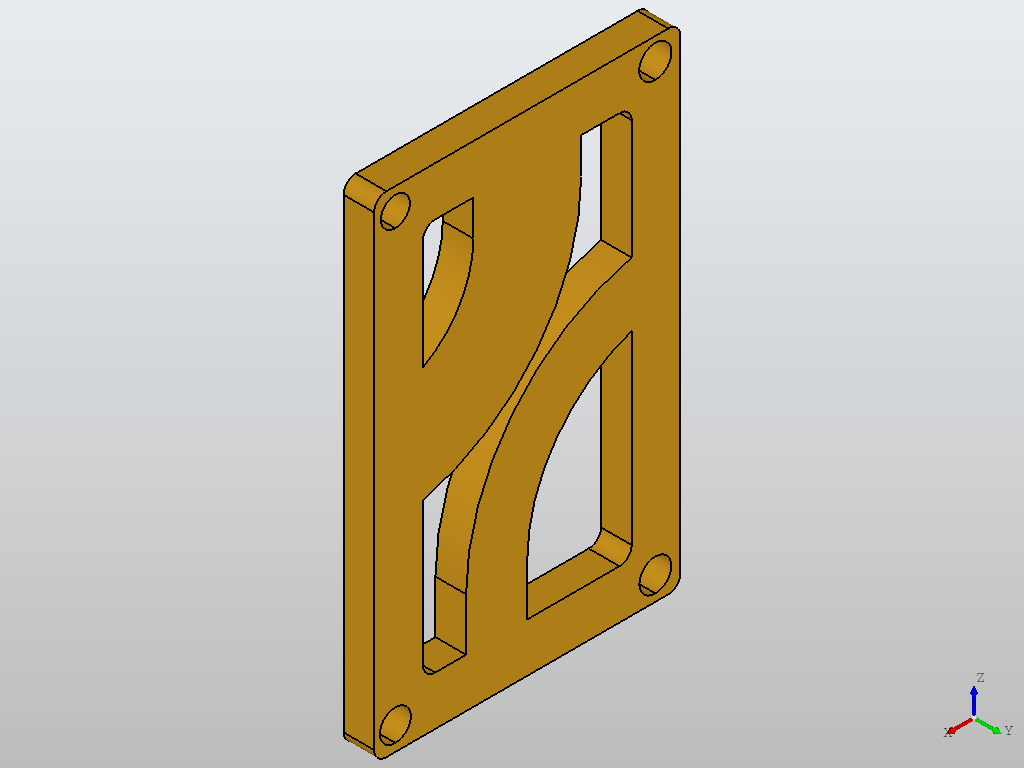

Displaying image for hard_29:


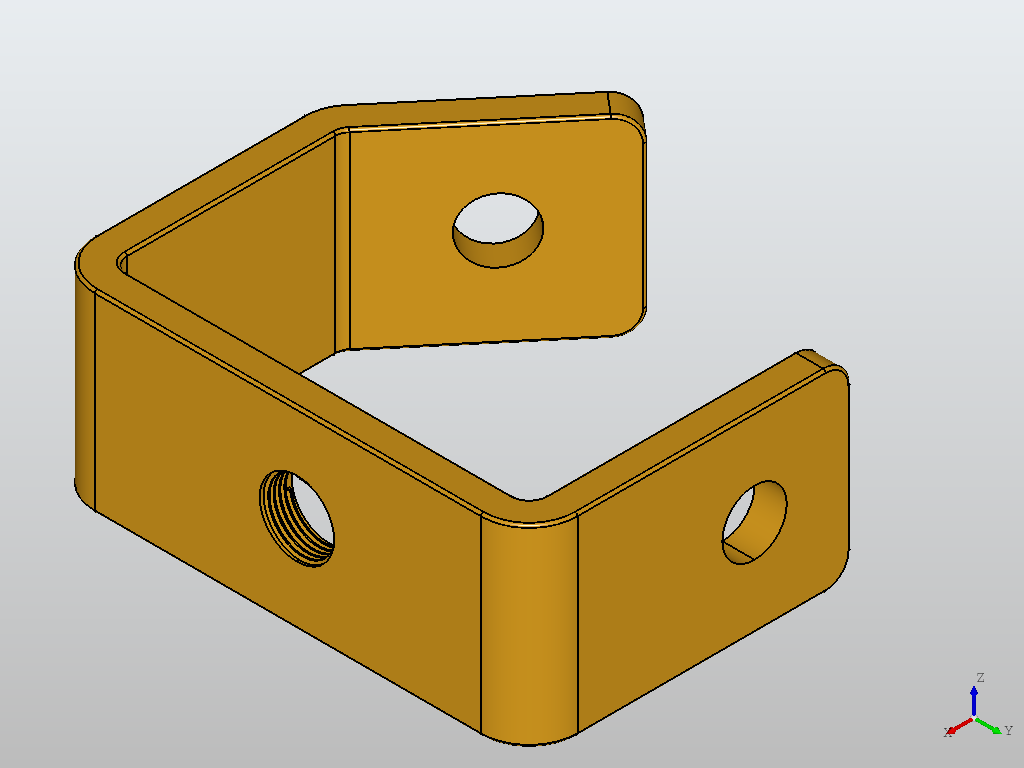

Displaying image for hard_30:


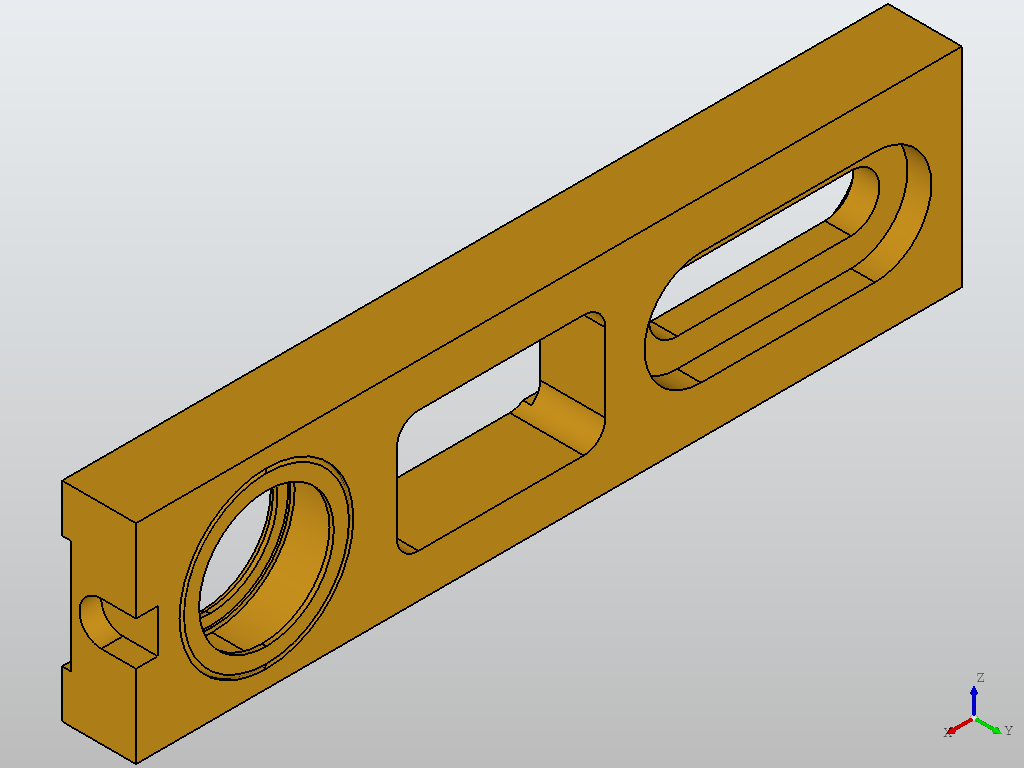

Displaying image for hard_31:


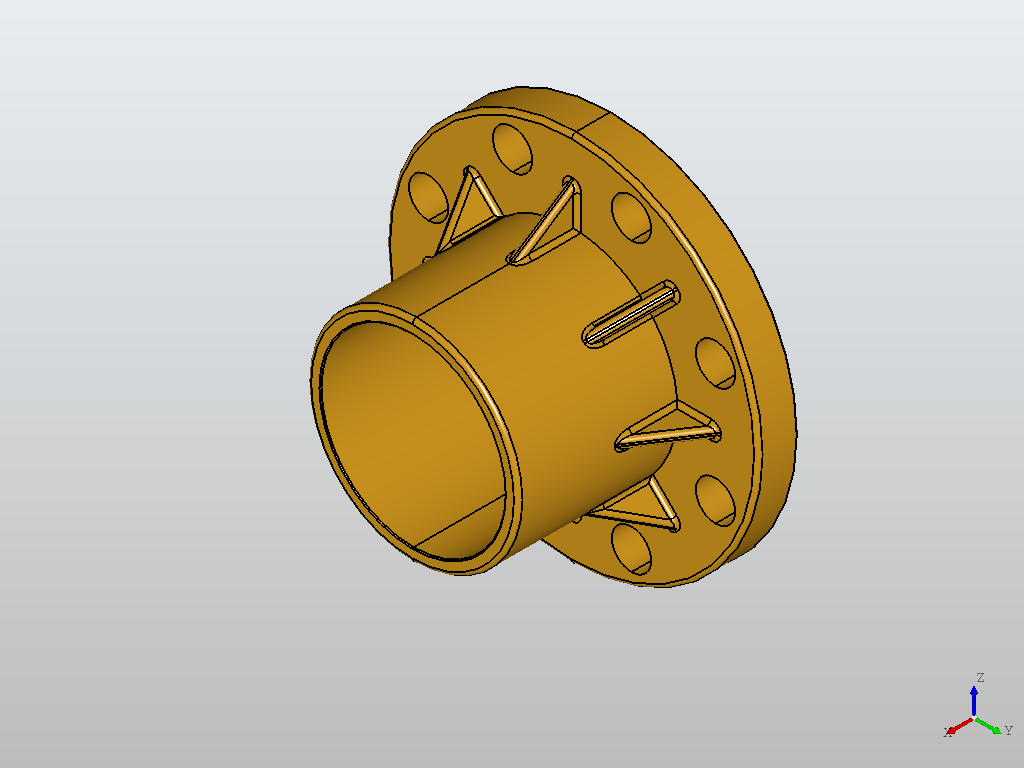

Displaying image for hard_32:


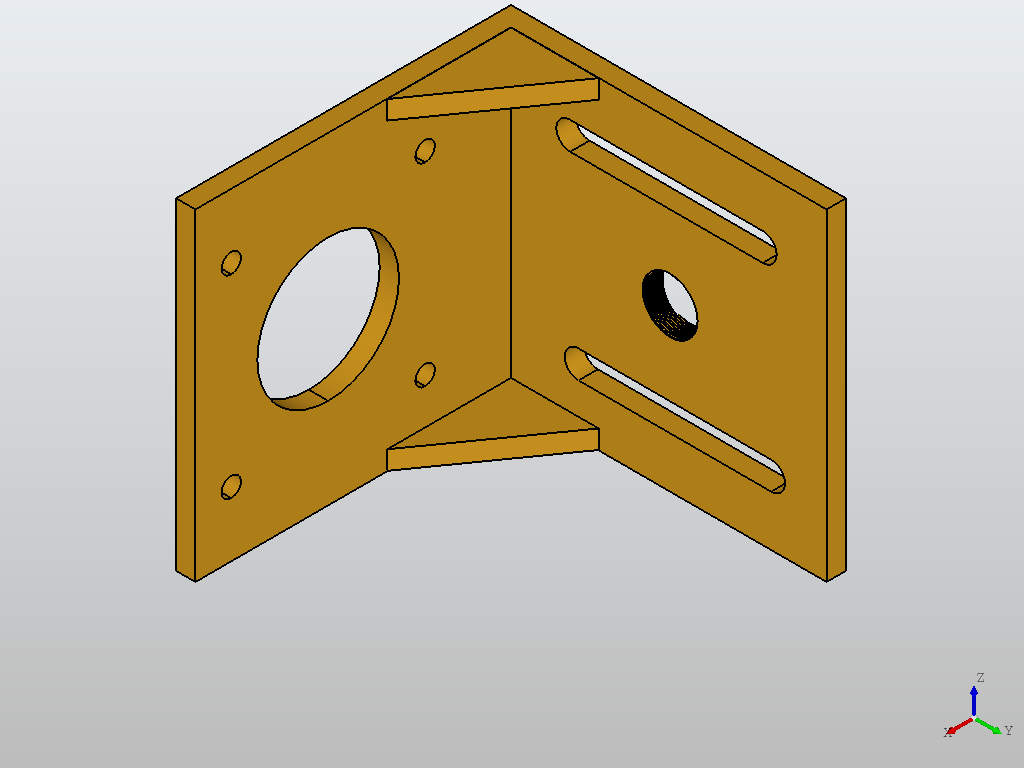

Displaying image for hard_33:


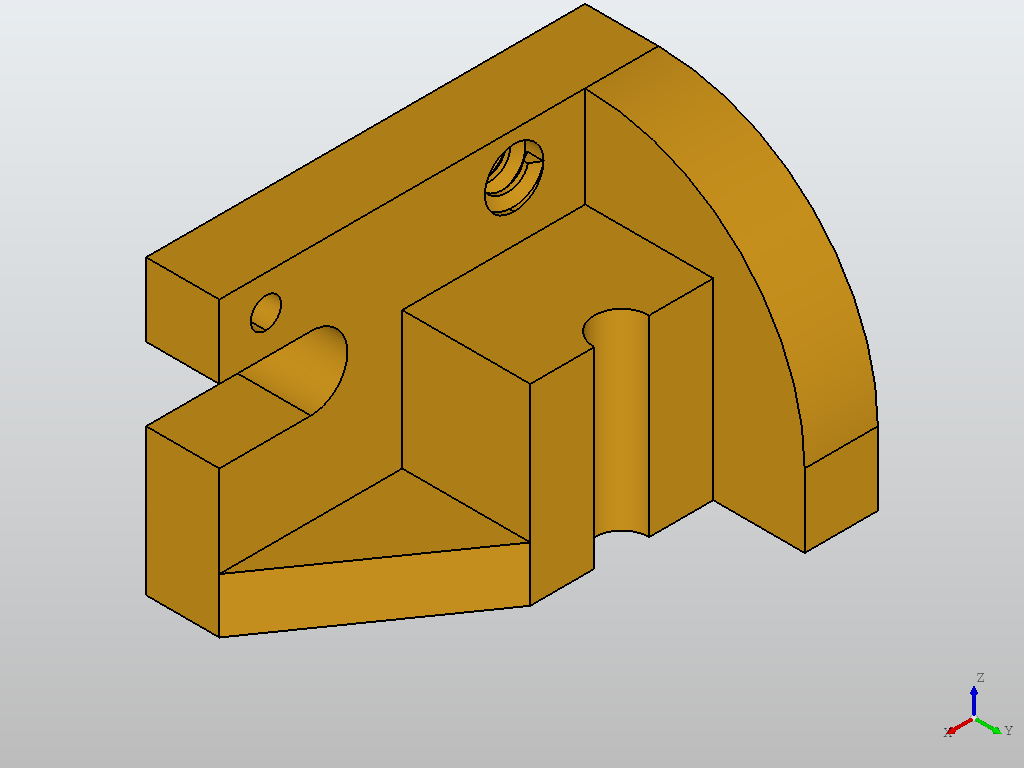

Displaying image for hard_34:


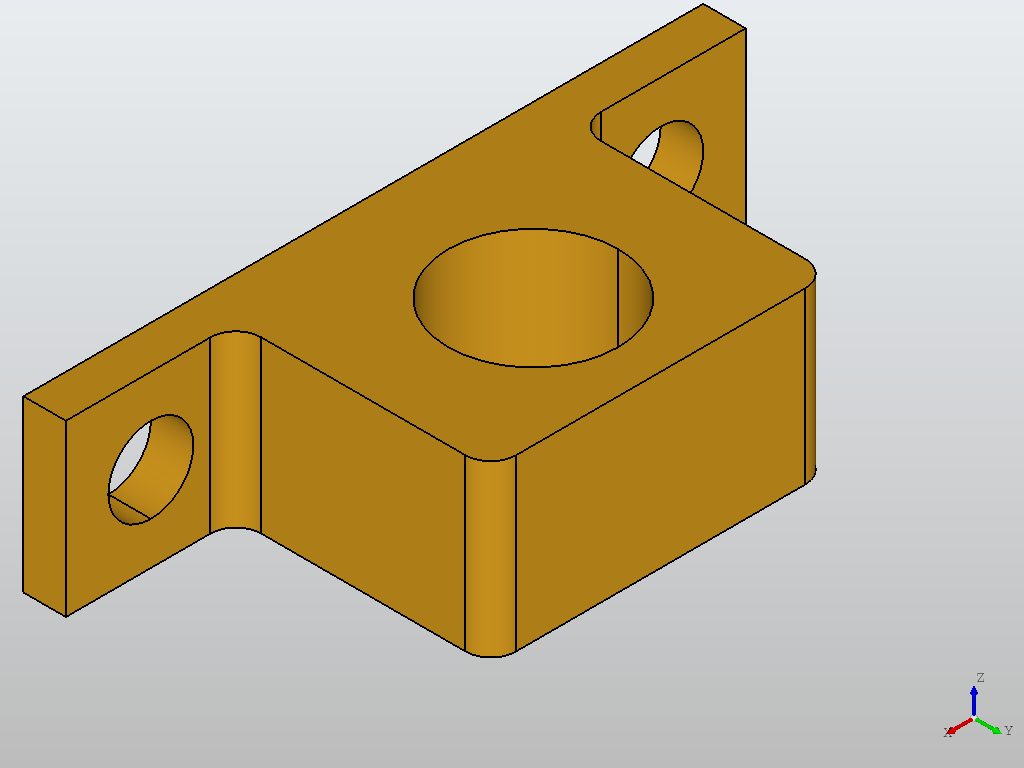

In [28]:
from IPython.display import display, Image

# Function to display base64 encoded image
def display_base64_image(base64_string):
    image_data = base64.b64decode(base64_string)
    display(Image(data=image_data))

# Function to display multiple images
def display_multiple_images(base64_images_dict, test_cases):
    for test_case in test_cases:
        if test_case in base64_images_dict:
            print(f"Displaying image for {test_case}:")
            display_base64_image(base64_images_dict[test_case])
        else:
            print(f"Image for {test_case} not found in the dictionary.")


# Example: Displaying multiple images from the dictionary
display_multiple_images(base64_encoded_images, All_test_cases)

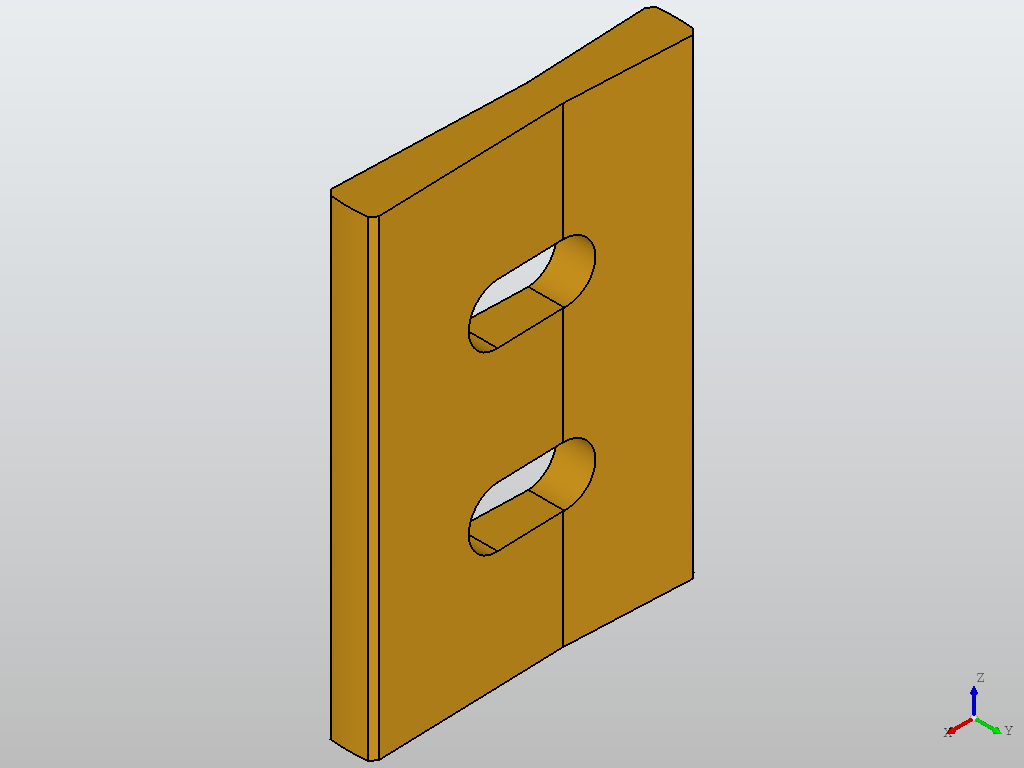

In [29]:
display_base64_image(single_image_test_case_base64_encoded)

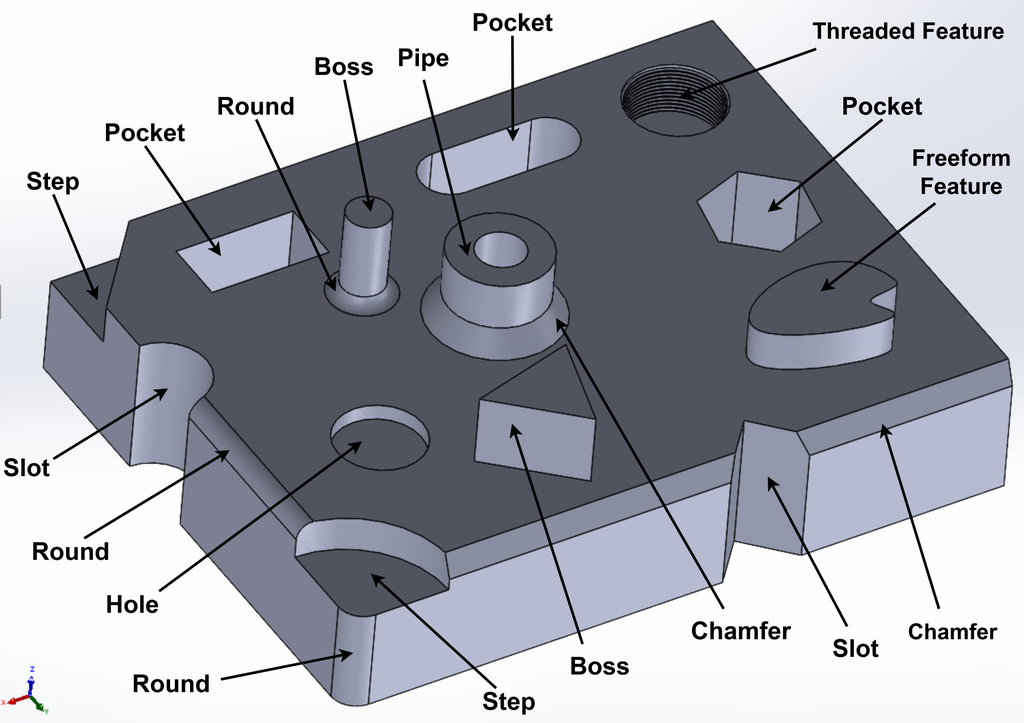

In [30]:
display_base64_image(few_shot_examples[0])

## Prompt engineering

prompts for ***CAD feature recognition***  using a VQA LLM model:

#### Feature Recognition Prompt:

- **Objective**: Ask the VQA LLM model to `identify` and `describe` **manufacturing features** present in the uploaded CAD image. Without considering any other factors such as materials, industry, or other manufacturing requirements. Purely based on appearance. 
- Features to be recognized include: holes, chamfers, fillets, cylindrical pockets, triangular or hexagonal pockets, and free-form curved surfaces, among others.
- The complete **manufacturing feature list** is represented in a hierachical manner, stored in the **JSON file format**
- Since the range of features is broad and somewhat unpredictable, the prompt should be carefully crafted to guide the LLM model effectively, a consistent and less uncertain output. The prompt should enable the LLM to (1) predict **ALL** possible features inside the given part, (2) Answer the features based on the provided list, with the naming conventions **strictly follow** the given list, (2) When refering to the provided list, it only needs to look at the lowest level of the feature names, while its parents are considered as "categories" of the feature. (3) If LLM thinks there are additional features that are shown in the image, but not provided inside the given list, it can suggest that, but needs to specify the category as "Other". (4) Return the final results in a JSON format, with the following information included: an index, the exact feature name, the category of this feature is under, a brief rationel of why. And note that, do not include any other content, including any punctuation around the text

In [32]:
# Define the relative path to the generated_images folder
JSON_FILES_PATH = os.path.join('..', 'JSON_Files')
# File names
feature_list_file = 'Manufacturing_Feature_List_Selected.json'

# Full paths
feature_list_path = os.path.join(JSON_FILES_PATH, feature_list_file)

# Function to read JSON file
def read_json_file(file_path):
    with open(file_path, 'r') as file:
        data = json.load(file)
    return data

# Read the JSON files
manufacturing_features = read_json_file(feature_list_path)

# Print to verify
print(json.dumps(manufacturing_features, indent=2))

{
  "Manufacturing Features": {
    "Machining Features": {
      "Hole (Through / Blind Hole)": [],
      "Slot (Through / Blind / T-Slot / Dovetail)": [],
      "Step (Through / Blind Step)": [],
      "Pocket (Blind / Through / Circular End Pocket)": [],
      "Edges & Contours": {
        "Chamfer / Bevel (Sharp Edge)": [],
        "Fillet / Round (Concave / Convex)": []
      },
      "Threads & Spirals": {
        "Threaded Feature": [],
        "Gear Teeth": []
      },
      "Additional Machining Features": {
        "Neck": []
      }
    },
    "Extrusion Features": {
      "Pipe / Tube": [],
      "Boss (Circular / Obround / Irregular / Rectangular, etc)": []
    },
    "Freeform Features (Depression, Protrusion)": [],
    "Molding & Casting Features": {
      "Rib": [],
      "Gusset": [],
      "Draft": []
    },
    "Sheet Metal Features": []
  }
}


In [35]:
# Function to extract hierarchy
def extract_hierarchy(dictionary, current_path=""):
    result = []
    for key, value in dictionary.items():
        new_path = f"{current_path} > {key}" if current_path else key
        if isinstance(value, dict):
            result.extend(extract_hierarchy(value, new_path))
        elif isinstance(value, list) and not value:
            result.append({
                # "index": len(result) + 1,
                "feature_name": key,
                "hierarchy": new_path
            })
        else:
            for item in value:
                result.append({
                    # "index": len(result) + 1,
                    "feature_name": item,
                    "hierarchy": new_path
                })
    return result

# Function to create name hierarchy dictionaries
def create_name_hierarchy_dicts(manufacturing_features):
    feature_list = extract_hierarchy(manufacturing_features["Manufacturing Features"])
    # process_list = extract_hierarchy(manufacturing_processes["Manufacturing Processes"])
    return feature_list

# Generate name hierarchy dictionaries
manufacturing_features_names = create_name_hierarchy_dicts(manufacturing_features)

# Print to verify
print ("manufacturing_features_names \n\n")
print(json.dumps(manufacturing_features_names, indent=2))


manufacturing_features_names 


[
  {
    "feature_name": "Hole (Through / Blind Hole)",
    "hierarchy": "Machining Features > Hole (Through / Blind Hole)"
  },
  {
    "feature_name": "Slot (Through / Blind / T-Slot / Dovetail)",
    "hierarchy": "Machining Features > Slot (Through / Blind / T-Slot / Dovetail)"
  },
  {
    "feature_name": "Step (Through / Blind Step)",
    "hierarchy": "Machining Features > Step (Through / Blind Step)"
  },
  {
    "feature_name": "Pocket (Blind / Through / Circular End Pocket)",
    "hierarchy": "Machining Features > Pocket (Blind / Through / Circular End Pocket)"
  },
  {
    "feature_name": "Chamfer / Bevel (Sharp Edge)",
    "hierarchy": "Machining Features > Edges & Contours > Chamfer / Bevel (Sharp Edge)"
  },
  {
    "feature_name": "Fillet / Round (Concave / Convex)",
    "hierarchy": "Machining Features > Edges & Contours > Fillet / Round (Concave / Convex)"
  },
  {
    "feature_name": "Threaded Feature",
    "hierarchy": "Machining Featur

#### Tactics Adopted During Feature Engineering
- **Using Delimiters**: Clearly indicated distinct parts of the input by using triple backticks (```) to delimit the provided list of features or processes.
Structured Output (JSON):

- Specified a **structured output format** in JSON to ensure consistency and clarity in the model's responses.

- **One-Shot and Few-Shot Learning**: Provided clear examples within the prompt to guide the model on how to format its output and what details to include.

- **Step-by-Step Instructions**: Instructed the model to go through the complete list of features or processes one by one, encouraging a thorough consideration of each item.

- **Existence Flag**: Added a flag (exists for features, applicable for processes) to indicate whether the feature exists or the process is applicable.

- **Explicit Instructions**: Used clear and detailed instructions to guide the model on how to approach the task and what to consider during its analysis.

- **Emphasis on Naming Conventions**: Stressed the importance of strictly following the provided naming conventions for features and processes to maintain consistency.

- Encouraging Reasoning: Encouraged the model to **"think"** about each feature or process before making a decision, promoting a more deliberate and comprehensive approach.

$\color{red}{\text{This prompt will instruct LLM to identify all features it's seeing in the CAD Image (loaded as an image), and return the results as a JSON}}$ 

### 1. Feature Recognition Prompt

#### (1) Basic Prompt - Zero-shot, Single-Imgae, Single-View, Parallel Processing
- This one will results in high possibility of halluncination

In [36]:
prompt_feature_recognition_1 = f"""
You are provided with a CAD image. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''{manufacturing_features_names}'''

Return the results in JSON format.
**Do not include any other content, including any punctuation around the text.**:
Example output:
{{
    "identified_features": [
        {{
            "feature_name": "Hole (Through / Blind Hole)",
            "exists": true,
            "quantity": 2
        }},
        {{
            "feature_name": "Chamfer / Bevel (Sharp)",
            "exists": true,
            "quantity": 1
        }},
        {{
            "feature_name": "Fillet / Round (Concave / Convex)",
            "exists": false,
            "quantity": 0
        }}
    ]
}}
"""

#### (2) Improved prompts version 2 - Zero-shot, Single-Imgae, Single-View, Sequential Processing

In [37]:
prompt_feature_recognition_2 = f"""
You are provided with a CAD image. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''{manufacturing_features_names}'''

Instructions:
1. **Go through the COMPLETE list of manufacturing features one by one.**
2. **Think about whether each particular feature exists in the given image.**
3. **Consider the **hierarchy** of each feature name from the provided list to understand its meaning in the manufacturing context.**
4. **Answer the features based on the provided list, with the naming conventions strictly following the given list.**
5. For each feature, provide **Quantity:** The number of such features present in the image (e.g., if there are two "Through Holes", then quantity is 2). \
    This should be a numerical integer (0, 1, 2, ...).
    
Return the results in the following JSON format, strictly adhering to the specified structure, \
**Do not include any other content, including any punctuation around the text.**:

Example output:
{{
    "identified_features": [
        {{
            "feature_name": "Hole (Through / Blind Hole)",
            "exists": true,
            "quantity": 2
        }},
        {{
            "feature_name": "Chamfer / Bevel (Sharp)",
            "exists": true,
            "quantity": 1
        }},
        {{
            "feature_name": "Fillet / Round (Concave / Convex)",
            "exists": false,
            "quantity": 0
        }}
    ]
}}
"""

#### (3) Improved prompts version 3 - Zero-shot, Multi-Image Multi-View

In [38]:
prompt_feature_recognition_3 = f"""
You are provided with an image containing multiple views of a 3D CAD model taken from different viewing angles. \
Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''{manufacturing_features_names}'''

Instructions:
1. **Go through the COMPLETE list of manufacturing features one by one.**
2. **Think about whether each particular feature exists in the given image.**
3. **When considering the existence of a feature, take the **hierarchy** of feature name from the provided list into account. \
This will help you better understand the feature's  meaning in the manufacturing context.**
4. **Answer the features based on the provided list, with the naming conventions strictly following the given list.**
5. Examine **each views** of the part to identify all features. Different angles may reveal features not visible in other views.
5. For each feature, provide **Quantity:** The number of such features present in the image (e.g., if there are two "Through Holes", then quantity is 2). \
    This should be a numerical integer (0, 1, 2, ...).
    
Return the results in the following JSON format, strictly adhering to the specified structure, \
**Do not include any other content, including any punctuation around the text.**:

Example output:

{{
    "identified_features": [
        {{
            "feature_name": "Hole (Through / Blind Hole)",
            "exists": true,
            "quantity": 2
        }},
        {{
            "feature_name": "Chamfer / Bevel (Sharp)",
            "exists": true,
            "quantity": 1
        }},
        {{
            "feature_name": "Fillet / Round (Concave / Convex)",
            "exists": false,
            "quantity": 0
        }}
    ]
}}
"""

#### (4)-a Improved prompts version 4 - Multi-Image Multi-View, Few-shot learning

In [40]:
prompt_feature_recognition_4a = f"""
You are provided with images containing multiple views of a 3D CAD model taken from different angles. \
Your task is to identify and describe the manufacturing features present in these images. \
Refer to the provided list of feature names, delimited by triple backticks, and strictly follow the naming conventions:

'''{manufacturing_features_names}'''

### Instructions:

1. **Review the COMPLETE list of manufacturing features one by one.**
2. **Determine whether each feature exists in the given images.**
3. **Consider the **hierarchy** of each feature name from the provided list to understand its meaning in the manufacturing context.**
4. **Identify features using the provided list, adhering strictly to the naming conventions.**
5. **Examine each view of the part to identify all features. Different angles may reveal features not visible in other views.**
6. **For each identified feature, provide the quantity:** The number of such features present in the images (e.g., if there are two "Through Holes", \
then the quantity is 2). This should be a numerical integer (0, 1, 2, ...).

### Example Task:

Before proceeding with your task, here is an example to illustrate the expected format and content of your response.
Return the results in the JSON format, strictly adhering to the specified structure, \
**Do not include any other content, including any punctuation around the text.**:

(Example image and answer will be provided below)
"""

#### (5)-b Improved prompts version 5 - Zero-shot, Multi-Image Multi-View + Chain-of-Thoughts

In [39]:
prompt_feature_recognition_4b = f"""
You are provided with an image containing multiple views of a 3D CAD model taken from different viewing angles. \
Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''{manufacturing_features_names}'''

Instructions:
1. **Go through the COMPLETE list of manufacturing features one by one.**
2. **For each feature, follow these steps to determine its existence and quantity:**
   - **Step 1:** Identify the feature present in the CAD image. Describe what you see that makes you think the feature exists or does not exist.
   - **Step 2:** Consider the manufacturing context and hierarchy. Think about how this context influences your decision.
   - **Step 3:** Determine the quantity of the feature. Count the occurrences of this feature in the image. (e.g., if there are two "Through Holes", \
then the quantity is 2). This should be a numerical integer (0, 1, 2, ...).
3. **Ensure that each feature from the provided list has been considered in your final output.**
4. **Keep the reasoning concise and to the point, no more than one or two sentences.**

Return the results in the following JSON format, strictly adhering to the specified structure, \
**Do not include any other content, including any punctuation around the text.**:

Example output:
{{
    "identified_features": [
        {{
            "feature_name": "Hole (Through / Blind Hole)",
            "exists": true,
            "quantity": 2,
            "reasoning": "Observed two through holes on the top surface."
        }},
        {{
            "feature_name": "Chamfer / Bevel (Sharp Edge)",
            "exists": true,
            "quantity": 1,
            "reasoning": "Noticed a chamfer on the edge of the base."
        }},
        {{
            "feature_name": "Extruded Cylinder",
            "exists": false,
            "quantity": 0,
            "reasoning": "No cylindrical extrusions visible."
        }}
    ]
}}
"""

#### (6) Improved Prompt version 6 - Multi-Image Multi-vew + Few-shot Learning + Chain-of-thought
- Try to iterate through all features one by one
- Provide reasoning to guide the decision
- Break the complex problem into smaller steps

In [41]:
prompt_feature_recognition_6 = f"""
You are provided with images containing multiple views of a 3D CAD model taken from different angles. \
Your task is to identify and describe the manufacturing features present in these images. \
Refer to the provided list of feature names, delimited by triple backticks, and strictly follow the naming conventions:

'''{manufacturing_features_names}'''

Instructions:
1. **Go through the COMPLETE list of manufacturing features one by one.**
2. **For each feature, follow these steps to determine its existence and quantity:**
   - **Step 1:** Identify the feature in the CAD image. Describe what you see that makes you think the feature exists or does not exist.
   - **Step 2:** Consider the manufacturing context and hierarchy. Explain how this context influences your decision.
   - **Step 3:** Determine the quantity of the feature. Count the occurrences of this feature in the image.
3. **Provide your answers in a structured format for each feature, including your reasoning for existence and quantity.**
4. **Ensure that each feature from the provided list has been considered in your final output.**
5. **Keep the reasoning concise and to the point, no more than one or two sentences.**

**Return the results in the following JSON format, strictly adhering to the specified structure.** \
**Do not include any other content, including any punctuation around the text.**:

Example output:

{{
    "identified_features": [
        {{
            "feature_name": "Hole (Through / Blind Hole)",
            "exists": true,
            "quantity": 2,
            "reasoning": "Observed two through holes on the top surface."
        }},
        {{
            "feature_name": "Chamfer / Bevel (Sharp Edge)",
            "exists": true,
            "quantity": 1,
            "reasoning": "Noticed a chamfer on the edge of the base."
        }},
        {{
            "feature_name": "Extruded Cylinder",
            "exists": false,
            "quantity": 0,
            "reasoning": "No cylindrical extrusions visible."
        }}
    ]
}}

### Example Task:

Before proceeding with your task, here is an example image and its associated answer.

(Example image and answer will be provided below)
"""

# GPT-4o

In [43]:
from openai import OpenAI

client_openai = OpenAI(api_key=OPENAI_API_KEY)
MODEL_NAME_GPT = "gpt-4o"

def get_completion_gpt4o(messages):
    response = client_openai.chat.completions.create(
        model=MODEL_NAME_GPT,
        # max_tokens=2048,
        temperature=0,
        messages=messages
    )
    print(response.model)
    return response.choices[0].message.content

TypeError: __init__() got an unexpected keyword argument 'proxies'

In [29]:
def get_message_content_openai(question, encoded_pngs):
  # content = [{"type": "image", "source": {"type": "base64", "media_type": "image/png", "data": encoded_png}} for encoded_png in encoded_pngs]
  content = [{"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{encoded_png}"}} for encoded_png in encoded_pngs]
  content1 = {"type": "text", "text": question}
  content.append(content1)

  messages = {"role": 'user',"content": content}

  return messages

## Experiment 1: Single-Image Basic Prompts, Zero-shot
Single file test

{'role': 'user',
 'content': [{'type': 'image_url',
   'image_url': {'url': ''}},
  {'type': 'text',
   'text': '\nYou are provided with a CAD image. Your task is to identify and describe the manufacturing features present in this image.\nUse the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:\n\n\'\'\'[{\'feature_name\': \'Hole (Through / Blind Hole)\', \'hierarchy\': \'Machining Features > Hole (Through / Blind Hole)\'}, {\'feature_name\': \'Slot (Through / Blind / T-Slot / Dovetail)\', \'hierarchy\': \'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)\'}, {\'feature_name\': \'Step (Through / Blind Step)\', \'hierarchy\': \'Machining Features > Step (Through / Blind Step)\'}, {\'feature_name\': \'Pocket (Blind / Through / Circular End Pocket)\', \'hierarchy\': \'Machining Features > Pocket (Blind / Through / Circular End Pocket)\'}, {\'feature_name\': \'Chamfer / Bevel (Shar
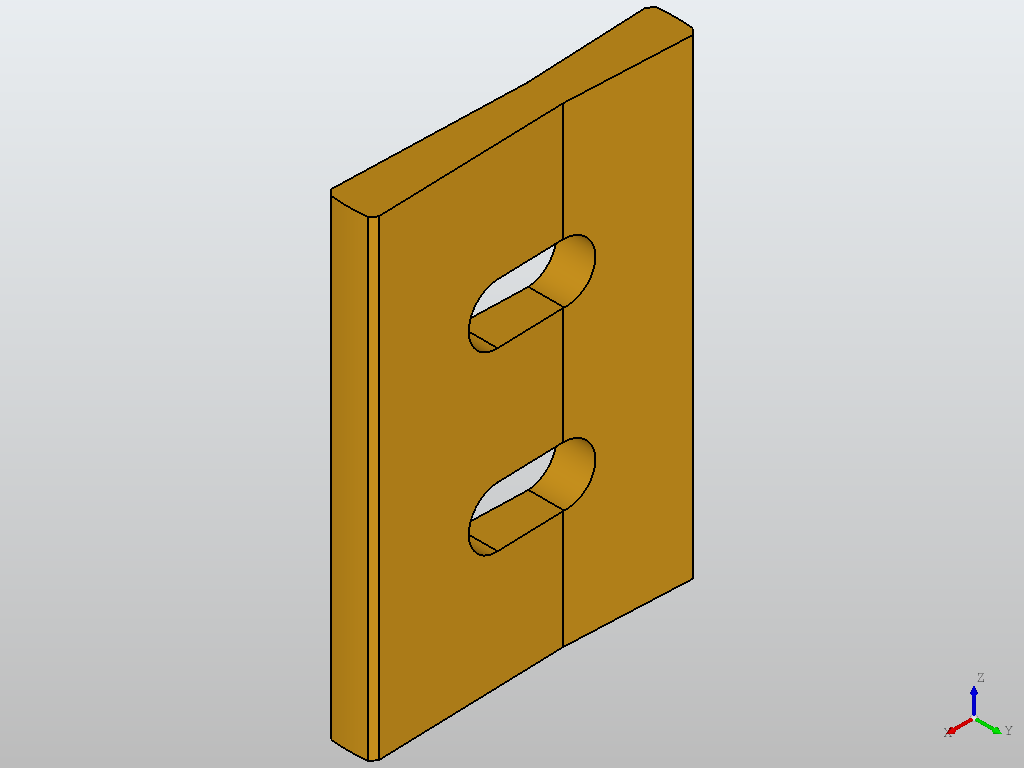

In [30]:
messages = get_message_content_openai(prompt_feature_recognition_1, [single_image_test_case_base64_encoded])
messages

In [31]:
all_messages = [messages]
feature_recognition = get_completion_gpt4o(all_messages)
print (type(feature_recognition))
print(feature_recognition)

gpt-4o-2024-05-13
<class 'str'>
{
    "identified_features": [
        {
            "feature_name": "Hole (Through / Blind Hole)",
            "exists": false,
            "quantity": 0
        },
        {
            "feature_name": "Slot (Through / Blind / T-Slot / Dovetail)",
            "exists": true,
            "quantity": 2
        },
        {
            "feature_name": "Step (Through / Blind Step)",
            "exists": false,
            "quantity": 0
        },
        {
            "feature_name": "Pocket (Blind / Through / Circular End Pocket)",
            "exists": false,
            "quantity": 0
        },
        {
            "feature_name": "Chamfer / Bevel (Sharp Edge)",
            "exists": false,
            "quantity": 0
        },
        {
            "feature_name": "Fillet / Round (Concave / Convex)",
            "exists": false,
            "quantity": 0
        },
        {
            "feature_name": "Threaded Feature",
            "exists": false,


### Testing Feature Recognition for all test cases

In [33]:
output_dir = os.path.join(Result_dir, "LLM_AFR", "Exp_1_Basic_Prompts", "GPT-4o")
os.makedirs(output_dir, exist_ok=True)

In [34]:
# Iterate through all test cases and generate responses
for test_case, encoded_image in base64_encoded_images.items():
    print(f"Processing {test_case}...")
    messages = get_message_content_openai(prompt_feature_recognition_1, [encoded_image])
    all_messages = [messages]
    feature_recognition = get_completion_gpt4o(all_messages)
    print(feature_recognition)  # Optionally print the response

    # Post-process response to filter out non-existent features
    consolidated_response = post_process_response(feature_recognition)
    print(consolidated_response)  # Optionally print the response
    
    # Save consolidated response to JSON file
    json_filename = os.path.join(output_dir, f"GPT-4o_{test_case}_features.json")
    save_response_to_json(consolidated_response, json_filename)

Processing easy_2...
gpt-4o-2024-05-13
{
    "identified_features": [
        {
            "feature_name": "Hole (Through / Blind Hole)",
            "exists": true,
            "quantity": 1
        },
        {
            "feature_name": "Slot (Through / Blind / T-Slot / Dovetail)",
            "exists": false,
            "quantity": 0
        },
        {
            "feature_name": "Step (Through / Blind Step)",
            "exists": false,
            "quantity": 0
        },
        {
            "feature_name": "Pocket (Blind / Through / Circular End Pocket)",
            "exists": false,
            "quantity": 0
        },
        {
            "feature_name": "Chamfer / Bevel (Sharp Edge)",
            "exists": false,
            "quantity": 0
        },
        {
            "feature_name": "Fillet / Round (Concave / Convex)",
            "exists": true,
            "quantity": 2
        },
        {
            "feature_name": "Threaded Feature",
            "exists": f

### Testing Manufacturing Process Selection

In [34]:
output_dir = os.path.join(Result_dir, "Manufacturing_Process_Selection")
os.makedirs(output_dir, exist_ok=True)

In [35]:
# Iterate through all test cases and generate responses
for test_case, encoded_image in base64_encoded_images.items():
    print(f"Processing {test_case}...")
    messages = get_message_content_openai(prompt_process_selection, [encoded_image])
    all_messages = [messages]
    manufacturing_process = get_completion_gpt4o(all_messages)
    print(manufacturing_process)  # Optionally print the response
    
    # Save response to JSON file
    json_filename = os.path.join(output_dir, f"GPT-4o_opus_{test_case}_processes.json")
    save_response_to_json(manufacturing_process, json_filename)

Processing easy_1...


NameError: name 'prompt_process_selection' is not defined

## Experiment 2 - Single Image Sequential Processing + Zero Shot

In [35]:
output_dir = os.path.join(Result_dir, "LLM_AFR", "Exp_2_Improved_Prompts", "GPT-4o")
os.makedirs(output_dir, exist_ok=True)

In [36]:
# Iterate through all test cases and generate responses
for test_case, images_dict in all_images_base64.items():
    print(f"Processing {test_case}...")
    # Combine images into a list to send to the API
    encoded_images = [images_dict[view] for view in ['view_1']]
    messages = get_message_content_openai(prompt_feature_recognition_2, encoded_images)
    all_messages = [messages]
    # Get completion from GPT-4o
    feature_recognition = get_completion_gpt4o(all_messages)
    print(feature_recognition)  # Optionally print the response

    # Post-process response to filter out non-existent features
    consolidated_response = post_process_response(feature_recognition)
    print(consolidated_response)  # Optionally print the response

    # Save consolidated response to JSON file
    json_filename = os.path.join(output_dir, f"GPT-4o_{test_case}_features.json")
    save_response_to_json(consolidated_response, json_filename)

Processing easy_2...
gpt-4o-2024-05-13
{
    "identified_features": [
        {
            "feature_name": "Hole (Through / Blind Hole)",
            "exists": true,
            "quantity": 1
        },
        {
            "feature_name": "Slot (Through / Blind / T-Slot / Dovetail)",
            "exists": false,
            "quantity": 0
        },
        {
            "feature_name": "Step (Through / Blind Step)",
            "exists": false,
            "quantity": 0
        },
        {
            "feature_name": "Pocket (Blind / Through / Circular End Pocket)",
            "exists": false,
            "quantity": 0
        },
        {
            "feature_name": "Chamfer / Bevel (Sharp Edge)",
            "exists": false,
            "quantity": 0
        },
        {
            "feature_name": "Fillet / Round (Concave / Convex)",
            "exists": true,
            "quantity": 2
        },
        {
            "feature_name": "Threaded Feature",
            "exists": f

## Experiment 3 - Multi-Image Multi-View + Zero-shot

In [37]:
output_dir = os.path.join(Result_dir, "LLM_AFR", "Exp_3_Multi_View", "GPT-4o")
os.makedirs(output_dir, exist_ok=True)

In [38]:
# Iterate through all test cases and generate responses
for test_case, images_dict in all_images_base64.items():
    print(f"Processing {test_case}...")
    # Combine images into a list to send to the API
    encoded_images = [images_dict[view] for view in ['view_1', 'view_2', 'view_3']]
    messages = get_message_content_openai(prompt_feature_recognition_3, encoded_images)
    all_messages = [messages]
    # Get completion from GPT-4o
    feature_recognition = get_completion_gpt4o(all_messages)
    print(feature_recognition)  # Optionally print the response

    # Post-process response to filter out non-existent features
    consolidated_response = post_process_response(feature_recognition)
    print(consolidated_response)  # Optionally print the response

    # Save consolidated response to JSON file
    json_filename = os.path.join(output_dir, f"GPT-4o_{test_case}_features.json")
    save_response_to_json(consolidated_response, json_filename)

Processing easy_2...
gpt-4o-2024-05-13
{
    "identified_features": [
        {
            "feature_name": "Hole (Through / Blind Hole)",
            "exists": true,
            "quantity": 1
        },
        {
            "feature_name": "Slot (Through / Blind / T-Slot / Dovetail)",
            "exists": false,
            "quantity": 0
        },
        {
            "feature_name": "Step (Through / Blind Step)",
            "exists": false,
            "quantity": 0
        },
        {
            "feature_name": "Pocket (Blind / Through / Circular End Pocket)",
            "exists": false,
            "quantity": 0
        },
        {
            "feature_name": "Chamfer / Bevel (Sharp Edge)",
            "exists": false,
            "quantity": 0
        },
        {
            "feature_name": "Fillet / Round (Concave / Convex)",
            "exists": true,
            "quantity": 2
        },
        {
            "feature_name": "Threaded Feature",
            "exists": f

## Experiment 4a - Multi-Image Multi-view Prompts + Few Shot Learning

In [39]:
output_dir = os.path.join(Result_dir, "LLM_AFR", "Exp_4a_Multi_View_Few_Shot", "GPT-4o")
os.makedirs(output_dir, exist_ok=True)

In [40]:
from openai import OpenAI

client_openai = OpenAI(api_key=OPENAI_API_KEY)
MODEL_NAME_GPT = "gpt-4o"

def get_completion_gpt4o(messages):
    response = client_openai.chat.completions.create(
        model=MODEL_NAME_GPT,
        temperature=0,
        messages=messages
    )
    print(response.model)
    return response.choices[0].message.content


In [41]:
def get_message_content_openai(question, encoded_pngs, example_images, example_answer):
    content = [{"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{encoded_png}"}} for encoded_png in encoded_pngs]
    content1 = {"type": "text", "text": question}
    content.append(content1)

    # Adding the example image and its answer
    example_content = [
        {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{example_images}"}},
        {"type": "text", "text": f"The correct answer for the above example image is:"},
        {"type": "text", "text": example_answer}
    ]

    messages = {"role": 'user', "content": content + example_content}

    return messages


### Few-shot learning examples

In [42]:
# Example data
example_answer_json = os.path.join(JSON_FILES_PATH, 'few_shot_prompt_example_2.json')

import json
import os

# Load the JSON file
with open(example_answer_json, 'r') as file:
    example_answer_dict = json.load(file)

# Convert the dictionary to a formatted string
example_answer = json.dumps(example_answer_dict, indent=4)
print (example_answer)

{
    "identified_features": [
        {
            "feature_name": "Hole (Through / Blind Hole)",
            "exists": true,
            "quantity": 2
        },
        {
            "feature_name": "Slot (Through / Blind / T-Slot / Dovetail)",
            "exists": true,
            "quantity": 2
        },
        {
            "feature_name": "Step (Through / Blind Step)",
            "exists": true,
            "quantity": 2
        },
        {
            "feature_name": "Pocket (Blind / Through / Circular End Pocket)",
            "exists": true,
            "quantity": 3
        },
        {
            "feature_name": "Chamfer / Bevel (Sharp Edge)",
            "exists": true,
            "quantity": 2
        },
        {
            "feature_name": "Fillet / Round (Concave / Convex)",
            "exists": true,
            "quantity": 3
        },
        {
            "feature_name": "Thread",
            "exists": true,
            "quantity": 1
        },
        {
 

In [43]:
# Iterate through all test cases and generate responses
for test_case, images_dict in all_images_base64.items():
    print(f"Processing {test_case}...")
    # Combine images into a list to send to the API
    encoded_images = [images_dict[view] for view in ['view_1', 'view_2','view_3']]
    messages = get_message_content_openai(prompt_feature_recognition_4a, encoded_images, few_shot_examples[1], example_answer)
    all_messages = [messages]
    # Get completion from GPT-4o
    feature_recognition = get_completion_gpt4o(all_messages)
    print(feature_recognition)  # Optionally print the response

    # Post-process response to filter out non-existent features
    consolidated_response = post_process_response(feature_recognition)
    print(consolidated_response)  # Optionally print the response

    # Save consolidated response to JSON file
    json_filename = os.path.join(output_dir, f"GPT-4o_{test_case}_features.json")
    save_response_to_json(consolidated_response, json_filename)

Processing easy_2...
gpt-4o-2024-05-13
{
    "identified_features": [
        {
            "feature_name": "Hole (Through / Blind Hole)",
            "exists": true,
            "quantity": 1
        },
        {
            "feature_name": "Slot (Through / Blind / T-Slot / Dovetail)",
            "exists": false,
            "quantity": 0
        },
        {
            "feature_name": "Step (Through / Blind Step)",
            "exists": false,
            "quantity": 0
        },
        {
            "feature_name": "Pocket (Blind / Through / Circular End Pocket)",
            "exists": false,
            "quantity": 0
        },
        {
            "feature_name": "Chamfer / Bevel (Sharp Edge)",
            "exists": false,
            "quantity": 0
        },
        {
            "feature_name": "Fillet / Round (Concave / Convex)",
            "exists": true,
            "quantity": 2
        },
        {
            "feature_name": "Threaded Feature",
            "exists": f

## Experiment 4b - Multi-Image Multi-View + Chain-of-Thoughts

In [44]:
output_dir = os.path.join(Result_dir, "LLM_AFR", "Exp_4b_Multi_View_Chain_of_Thougths", "GPT-4o")
os.makedirs(output_dir, exist_ok=True)

In [45]:
def get_completion_gpt4o(messages):
    response = client_openai.chat.completions.create(
        model=MODEL_NAME_GPT,
        # max_tokens=2048,
        temperature=0,
        messages=messages
    )
    print(response.model)
    return response.choices[0].message.content

def get_message_content_openai(question, encoded_pngs):
  # content = [{"type": "image", "source": {"type": "base64", "media_type": "image/png", "data": encoded_png}} for encoded_png in encoded_pngs]
  content = [{"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{encoded_png}"}} for encoded_png in encoded_pngs]
  content1 = {"type": "text", "text": question}
  content.append(content1)

  messages = {"role": 'user',"content": content}

  return messages

In [46]:
# Iterate through all test cases and generate responses
for test_case, images_dict in all_images_base64.items():
    print(f"Processing {test_case}...")
    # Combine images into a list to send to the API
    encoded_images = [images_dict[view] for view in ['view_1', 'view_2', 'view_3']]
    messages = get_message_content_openai(prompt_feature_recognition_4b, encoded_images)
    all_messages = [messages]
    # Get completion from GPT-4o
    feature_recognition = get_completion_gpt4o(all_messages)
    print(feature_recognition)  # Optionally print the response

    # Post-process response to filter out non-existent features
    consolidated_response = post_process_response(feature_recognition)
    print(consolidated_response)  # Optionally print the response

    # Save consolidated response to JSON file
    json_filename = os.path.join(output_dir, f"GPT-4o_{test_case}_features.json")
    save_response_to_json(consolidated_response, json_filename)

Processing easy_2...
gpt-4o-2024-05-13
{
    "identified_features": [
        {
            "feature_name": "Hole (Through / Blind Hole)",
            "exists": true,
            "quantity": 1,
            "reasoning": "Observed one through hole in the middle of the part."
        },
        {
            "feature_name": "Slot (Through / Blind / T-Slot / Dovetail)",
            "exists": false,
            "quantity": 0,
            "reasoning": "No slots are visible in the part."
        },
        {
            "feature_name": "Step (Through / Blind Step)",
            "exists": false,
            "quantity": 0,
            "reasoning": "No steps are present in the part."
        },
        {
            "feature_name": "Pocket (Blind / Through / Circular End Pocket)",
            "exists": false,
            "quantity": 0,
            "reasoning": "No pockets are visible in the part."
        },
        {
            "feature_name": "Chamfer / Bevel (Sharp Edge)",
            "exist

## Experiment 5 - Multi-Image Multi-view Prompts + Few Shot Learning + Chain of thoughts

In [47]:
output_dir = os.path.join(Result_dir, "LLM_AFR", "Exp_5_MultiView_Few_Shot_Chain_of_thoughts", "GPT-4o")
os.makedirs(output_dir, exist_ok=True)

In [48]:
def get_completion_gpt4o(messages):
    response = client_openai.chat.completions.create(
        model=MODEL_NAME_GPT,
        temperature=0,
        messages=messages
    )
    print(response.model)
    return response.choices[0].message.content

def get_message_content_openai(question, encoded_pngs, example_images, example_answer):
    content = [{"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{encoded_png}"}} for encoded_png in encoded_pngs]
    content1 = {"type": "text", "text": question}
    content.append(content1)

    # Adding the example image and its answer
    example_content = [
        {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{example_images}"}},
        {"type": "text", "text": f"The correct answer for the above example image is:"},
        {"type": "text", "text": example_answer}
    ]

    messages = {"role": 'user', "content": content + example_content}

    return messages

In [49]:
# Iterate through all test cases and generate responses
for test_case, images_dict in all_images_base64.items():
    print(f"Processing {test_case}...")
    # Combine images into a list to send to the API
    encoded_images = [images_dict[view] for view in ['view_1', 'view_2', 'view_3']]
    messages = get_message_content_openai(prompt_feature_recognition_5, encoded_images, few_shot_examples[1], example_answer)
    all_messages = [messages]
    # Get completion from GPT-4o
    feature_recognition = get_completion_gpt4o(all_messages)
    print(feature_recognition)  # Optionally print the response

    # Post-process response to filter out non-existent features
    consolidated_response = post_process_response(feature_recognition)
    print(consolidated_response)  # Optionally print the response

    # Save consolidated response to JSON file
    json_filename = os.path.join(output_dir, f"GPT-4o_{test_case}_features.json")
    save_response_to_json(consolidated_response, json_filename)

Processing easy_2...
gpt-4o-2024-05-13
{
    "identified_features": [
        {
            "feature_name": "Hole (Through / Blind Hole)",
            "exists": true,
            "quantity": 1,
            "reasoning": "Observed one through hole in the middle of the part."
        },
        {
            "feature_name": "Slot (Through / Blind / T-Slot / Dovetail)",
            "exists": false,
            "quantity": 0,
            "reasoning": "No slots are visible in the part."
        },
        {
            "feature_name": "Step (Through / Blind Step)",
            "exists": false,
            "quantity": 0,
            "reasoning": "No steps are present in the part."
        },
        {
            "feature_name": "Pocket (Blind / Through / Circular End Pocket)",
            "exists": false,
            "quantity": 0,
            "reasoning": "No pockets are visible in the part."
        },
        {
            "feature_name": "Chamfer / Bevel (Sharp Edge)",
            "exist

# Claude 3.5

In [44]:
client_claude = anthropic.Anthropic(
    api_key=CLAUDE_API_KEY,
)

MODEL_NAME = "claude-3-5-sonnet-20240620"
def get_completion_claude(messages):
    response = client_claude.messages.create(
        model=MODEL_NAME,
        max_tokens=4096,
        temperature=0,
        messages=messages
    )
    print(response.model)
    return response.content[0].text

In [45]:
def get_message_content_claude(question, encoded_pngs):
  content = [{"type": "image", "source": {"type": "base64", "media_type": "image/png", "data": encoded_png}} for encoded_png in encoded_pngs]
  content1 = {"type": "text", "text": question}
  content.append(content1)

  messages = {"role": 'user',"content": content}

  return messages

## Experiment 1: Single-Image Basic Prompts, Zero-shot
Single file test

In [52]:
messages = get_message_content_claude(prompt_feature_recognition_1, [single_image_test_case_base64_encoded])
messages

{'role': 'user',
 'content': [{'type': 'image',
   'source': {'type': 'base64',
    'media_type': 'image/png',
    'data': 'iVBORw0KGgoAAAANSUhEUgAABAAAAAMACAIAAAA12IJaAAA9PklEQVR42u3dfbBlZX0n+t+z9u7mRRQUtbt5EwHFWBUVpZyaKhFPN9GYWAoqarx5c27VnXtrbl0rZjQREGygxTgRk5o7qanUnUmmxjsjoAHUZCyFPjSNLzEqvtwaX0F8QQ4xiqIxAfqs5/6x9t5n7332OX3e9tl7r/X5lCXnnD4NzWp67+93Pc/vWWnhRz8JAACgGdqRXQQAAGiKwiUAAAAFAAAAUAAAAAAFAAAAmAltlwAAps3uJ5+0/IsL//ATVwbYvOTVBACmMO6vxBs3oAAAQN3S/4fesXv5F19zzYIaAGxJAXjIVQCASUT/J64S91cyWAO8iQMKAADUN/2rAYACAADNiv5qAKAAAMCMRf8tSf9qAKAAAMAMpP8tjP5qALCRAvCA1wgAGKc9Y47+I2uA93dAAQCAmqd/NQBQAACgWdF/eQdQAwAFAABqnv7VAEABAIBmRf+RNcCbPqAAAMDWR/+pSv9qALCsAPzQqwAAbDr9P2Xqbvyv0gEiQgAABQAAqG30H1kDZABQAACAmqd/NQBQAACgWdFfBwAFwJ95ANhI9J/p9K8GQJMLwI9dBQBYc/p/Um2i/6gOIBWAAgAA1Df6qwHQQIVLAADSf/+/Wu9fFqglKwAA0PToP+Q11yyIB1BjVgAAQPpf8V8cqJ+2SwAAoj+gAABA06O/9A8oAADQlPQv+gMKAACI/gCzXwCyawBA450i/S8jIUBtC4BLAIDoL/pXes8CAxQAAJD+RX9AAQAA0b9G0f+Wq/ZExMX7H/BfCNS6ANjiB0Cjov9TnfK5YvQfICFAbQsAADQv/Yv+q0V/QAEAANFf

In [53]:
all_messages = [messages]
feature_recognition = get_completion_claude(all_messages)
print (type(feature_recognition))
print(feature_recognition)

claude-3-5-sonnet-20240620
<class 'str'>
{
    "identified_features": [
        {
            "feature_name": "Hole (Through / Blind Hole)",
            "exists": true,
            "quantity": 2
        },
        {
            "feature_name": "Slot (Through / Blind / T-Slot / Dovetail)",
            "exists": true,
            "quantity": 2
        },
        {
            "feature_name": "Boss (Circular / Obround / Irregular / Rectangular, etc)",
            "exists": true,
            "quantity": 1
        },
        {
            "feature_name": "Chamfer / Bevel (Sharp Edge)",
            "exists": false,
            "quantity": 0
        },
        {
            "feature_name": "Fillet / Round (Concave / Convex)",
            "exists": false,
            "quantity": 0
        }
    ]
}


### Testing Feature Recognition for all test cases

In [54]:
output_dir = os.path.join(Result_dir, "LLM_AFR", "Exp_1_Basic_Prompts", "Claude-3.5")
os.makedirs(output_dir, exist_ok=True)

In [55]:
# Iterate through all test cases and generate responses
for test_case, encoded_image in base64_encoded_images.items():
    print(f"Processing {test_case}...")
    messages = get_message_content_claude(prompt_feature_recognition_1, [encoded_image])
    all_messages = [messages]
    feature_recognition = get_completion_claude(all_messages)
    print(feature_recognition)  # Optionally print the response

    # Post-process response to filter out non-existent features
    consolidated_response = post_process_response(feature_recognition)
    print(consolidated_response)  # Optionally print the response
    
    # Save consolidated response to JSON file
    json_filename = os.path.join(output_dir, f"Claude-3.5_{test_case}_features.json")
    save_response_to_json(consolidated_response, json_filename)

Processing easy_2...
claude-3-5-sonnet-20240620
{
    "identified_features": [
        {
            "feature_name": "Hole (Through / Blind Hole)",
            "exists": true,
            "quantity": 1
        },
        {
            "feature_name": "Slot (Through / Blind / T-Slot / Dovetail)",
            "exists": true,
            "quantity": 2
        },
        {
            "feature_name": "Step (Through / Blind Step)",
            "exists": true,
            "quantity": 2
        },
        {
            "feature_name": "Fillet / Round (Concave / Convex)",
            "exists": true,
            "quantity": 2
        },
        {
            "feature_name": "Boss (Circular / Obround / Irregular / Rectangular, etc)",
            "exists": true,
            "quantity": 1
        }
    ]
}
Successfully decoded JSON
Consolidated Features: [{'feature_name': 'Hole (Through / Blind Hole)', 'exists': True, 'quantity': 1}, {'feature_name': 'Slot (Through / Blind / T-Slot / Dovetail)', '

## Experiment 2 - Single Image Sequential Processing + Zero Shot

In [56]:
output_dir = os.path.join(Result_dir, "LLM_AFR", "Exp_2_Improved_Prompts", "Claude-3.5")
os.makedirs(output_dir, exist_ok=True)

In [57]:
# Iterate through all test cases and generate responses
for test_case, images_dict in all_images_base64.items():
    print(f"Processing {test_case}...")
    # Combine images into a list to send to the API
    encoded_images = [images_dict[view] for view in ['view_1']]
    messages = get_message_content_claude(prompt_feature_recognition_2, encoded_images)
    all_messages = [messages]
    # Get completion from Claude-3.5
    feature_recognition = get_completion_claude(all_messages)
    print(feature_recognition)  # Optionally print the response

    # Post-process response to filter out non-existent features
    consolidated_response = post_process_response(feature_recognition)
    print(consolidated_response)  # Optionally print the response

    # Save consolidated response to JSON file
    json_filename = os.path.join(output_dir, f"Claude-3.5_{test_case}_features.json")
    save_response_to_json(consolidated_response, json_filename)

Processing easy_2...
claude-3-5-sonnet-20240620
{
    "identified_features": [
        {
            "feature_name": "Hole (Through / Blind Hole)",
            "exists": true,
            "quantity": 1
        },
        {
            "feature_name": "Slot (Through / Blind / T-Slot / Dovetail)",
            "exists": true,
            "quantity": 2
        },
        {
            "feature_name": "Step (Through / Blind Step)",
            "exists": false,
            "quantity": 0
        },
        {
            "feature_name": "Pocket (Blind / Through / Circular End Pocket)",
            "exists": false,
            "quantity": 0
        },
        {
            "feature_name": "Chamfer / Bevel (Sharp Edge)",
            "exists": false,
            "quantity": 0
        },
        {
            "feature_name": "Fillet / Round (Concave / Convex)",
            "exists": true,
            "quantity": 2
        },
        {
            "feature_name": "Threaded Feature",
            "ex

## Experiment 3 - Multi-Image Multi-View + Zero-shot


In [58]:
output_dir = os.path.join(Result_dir, "LLM_AFR", "Exp_3_Multi_View", "Claude-3.5")
os.makedirs(output_dir, exist_ok=True)

In [59]:
# Iterate through all test cases and generate responses
for test_case, images_dict in all_images_base64.items():
    print(f"Processing {test_case}...")
    # Combine images into a list to send to the API
    encoded_images = [images_dict[view] for view in ['view_1', 'view_2', 'view_3']]
    messages = get_message_content_claude(prompt_feature_recognition_3, encoded_images)
    all_messages = [messages]
    # Get completion from Claude-3.5
    feature_recognition = get_completion_claude(all_messages)
    print(feature_recognition)  # Optionally print the response

    # Post-process response to filter out non-existent features
    consolidated_response = post_process_response(feature_recognition)
    print(consolidated_response)  # Optionally print the response

    # Save consolidated response to JSON file
    json_filename = os.path.join(output_dir, f"Claude-3.5_{test_case}_features.json")
    save_response_to_json(consolidated_response, json_filename)

Processing easy_2...
claude-3-5-sonnet-20240620
{
    "identified_features": [
        {
            "feature_name": "Hole (Through / Blind Hole)",
            "exists": true,
            "quantity": 1
        },
        {
            "feature_name": "Slot (Through / Blind / T-Slot / Dovetail)",
            "exists": true,
            "quantity": 2
        },
        {
            "feature_name": "Step (Through / Blind Step)",
            "exists": true,
            "quantity": 2
        },
        {
            "feature_name": "Pocket (Blind / Through / Circular End Pocket)",
            "exists": false,
            "quantity": 0
        },
        {
            "feature_name": "Chamfer / Bevel (Sharp Edge)",
            "exists": false,
            "quantity": 0
        },
        {
            "feature_name": "Fillet / Round (Concave / Convex)",
            "exists": true,
            "quantity": 2
        },
        {
            "feature_name": "Threaded Feature",
            "exi

## Experiment 4a - Multi-Image Multi-view Prompts + Few Shot Learning


In [60]:
output_dir = os.path.join(Result_dir, "LLM_AFR", "Exp_4a_Multi_View_Few_Shot", "Claude-3.5")
os.makedirs(output_dir, exist_ok=True)

In [61]:
client_claude = anthropic.Anthropic(
    api_key=CLAUDE_API_KEY,
)

MODEL_NAME = "claude-3-5-sonnet-20240620"
def get_completion_claude(messages):
    response = client_claude.messages.create(
        model=MODEL_NAME,
        max_tokens=4096,
        temperature=0,
        messages=messages
    )
    print(response.model)
    return response.content[0].text

In [62]:
def get_message_content_claude(question, encoded_pngs, example_images, example_answer):
    content = [{"type": "image", "source": {"type": "base64", "media_type": "image/png", "data": encoded_png}} for encoded_png in encoded_pngs]
    content1 = {"type": "text", "text": question}
    content.append(content1)

    # Adding the example image and its answer
    example_content = [
        {"type": "image", "source": {"type": "base64", "media_type": "image/png", "data": example_images}},
        {"type": "text", "text": f"The correct answer for the above example image is:"},
        {"type": "text", "text": example_answer}
    ]

    messages = {"role": 'user', "content": content + example_content}

    return messages

### Few-shot learning examples


In [63]:
# Example data
example_answer_json = os.path.join(JSON_FILES_PATH, 'few_shot_prompt_example_2.json')

import json
import os

# Load the JSON file
with open(example_answer_json, 'r') as file:
    example_answer_dict = json.load(file)

# Convert the dictionary to a formatted string
example_answer = json.dumps(example_answer_dict, indent=4)
print (example_answer)

{
    "identified_features": [
        {
            "feature_name": "Hole (Through / Blind Hole)",
            "exists": true,
            "quantity": 2
        },
        {
            "feature_name": "Slot (Through / Blind / T-Slot / Dovetail)",
            "exists": true,
            "quantity": 2
        },
        {
            "feature_name": "Step (Through / Blind Step)",
            "exists": true,
            "quantity": 2
        },
        {
            "feature_name": "Pocket (Blind / Through / Circular End Pocket)",
            "exists": true,
            "quantity": 3
        },
        {
            "feature_name": "Chamfer / Bevel (Sharp Edge)",
            "exists": true,
            "quantity": 2
        },
        {
            "feature_name": "Fillet / Round (Concave / Convex)",
            "exists": true,
            "quantity": 3
        },
        {
            "feature_name": "Thread",
            "exists": true,
            "quantity": 1
        },
        {
 

In [64]:
# Iterate through all test cases and generate responses
for test_case, images_dict in all_images_base64.items():
    print(f"Processing {test_case}...")
    # Combine images into a list to send to the API
    encoded_images = [images_dict[view] for view in ['view_1', 'view_2','view_3']]
    messages = get_message_content_claude(prompt_feature_recognition_4a, encoded_images, few_shot_examples[2], example_answer)
    all_messages = [messages]
    # Get completion from Claude-3.5
    feature_recognition = get_completion_claude(all_messages)
    print(feature_recognition)  # Optionally print the response

    # Post-process response to filter out non-existent features
    consolidated_response = post_process_response(feature_recognition)
    print(consolidated_response)  # Optionally print the response

    # Save consolidated response to JSON file
    json_filename = os.path.join(output_dir, f"Claude-3.5_{test_case}_features.json")
    save_response_to_json(consolidated_response, json_filename)

Processing easy_2...
claude-3-5-sonnet-20240620
{
    "identified_features": [
        {
            "feature_name": "Hole (Through / Blind Hole)",
            "exists": true,
            "quantity": 1
        },
        {
            "feature_name": "Slot (Through / Blind / T-Slot / Dovetail)",
            "exists": false,
            "quantity": 0
        },
        {
            "feature_name": "Step (Through / Blind Step)",
            "exists": true,
            "quantity": 2
        },
        {
            "feature_name": "Pocket (Blind / Through / Circular End Pocket)",
            "exists": false,
            "quantity": 0
        },
        {
            "feature_name": "Chamfer / Bevel (Sharp Edge)",
            "exists": false,
            "quantity": 0
        },
        {
            "feature_name": "Fillet / Round (Concave / Convex)",
            "exists": true,
            "quantity": 2
        },
        {
            "feature_name": "Threaded Feature",
            "ex

## Experiment 4b - Multi-Image Multi-View + Chain-of-Thoughts

In [46]:
output_dir = os.path.join(Result_dir, "LLM_AFR", "Exp_4b_Multi_View_Chain_of_Thougths", "Claude-3.5")
os.makedirs(output_dir, exist_ok=True)

In [47]:
MODEL_NAME = "claude-3-5-sonnet-20240620"
def get_completion_claude(messages):
    response = client_claude.messages.create(
        model=MODEL_NAME,
        max_tokens=4096,
        temperature=0,
        messages=messages
    )
    print(response.model)
    return response.content[0].text

def get_message_content_claude(question, encoded_pngs):
  content = [{"type": "image", "source": {"type": "base64", "media_type": "image/png", "data": encoded_png}} for encoded_png in encoded_pngs]
  content1 = {"type": "text", "text": question}
  content.append(content1)

  messages = {"role": 'user',"content": content}

  return messages

In [48]:
# Iterate through all test cases and generate responses
for test_case, images_dict in all_images_base64.items():
    print(f"Processing {test_case}...")
    # Combine images into a list to send to the API
    encoded_images = [images_dict[view] for view in ['view_1', 'view_2', 'view_3']]
    messages = get_message_content_claude(prompt_feature_recognition_4b, encoded_images)
    all_messages = [messages]
    # Get completion from Claude-3.5
    feature_recognition = get_completion_claude(all_messages)
    print(feature_recognition)  # Optionally print the response

    # Post-process response to filter out non-existent features
    consolidated_response = post_process_response(feature_recognition)
    print(consolidated_response)  # Optionally print the response

    # Save consolidated response to JSON file
    json_filename = os.path.join(output_dir, f"Claude-3.5_{test_case}_features.json")
    save_response_to_json(consolidated_response, json_filename)

Processing easy_2...
claude-3-5-sonnet-20240620
{
    "identified_features": [
        {
            "feature_name": "Hole (Through / Blind Hole)",
            "exists": true,
            "quantity": 1,
            "reasoning": "There is a single circular hole visible on the main body of the part."
        },
        {
            "feature_name": "Slot (Through / Blind / T-Slot / Dovetail)",
            "exists": true,
            "quantity": 2,
            "reasoning": "Two curved slots are visible at both ends of the part."
        },
        {
            "feature_name": "Step (Through / Blind Step)",
            "exists": true,
            "quantity": 2,
            "reasoning": "Steps are visible at both ends of the part, creating raised sections."
        },
        {
            "feature_name": "Pocket (Blind / Through / Circular End Pocket)",
            "exists": false,
            "quantity": 0,
            "reasoning": "No pockets are visible in the part."
        },
       

## Experiment 5 - Multi-Image Multi-view Prompts + Few Shot Learning + Chain of thoughts


In [70]:
output_dir = os.path.join(Result_dir, "LLM_AFR", "Exp_5_Multi_View_Few_Shot_Chain_of_thoughts", "Claude-3.5")
os.makedirs(output_dir, exist_ok=True)

In [72]:
MODEL_NAME = "claude-3-5-sonnet-20240620"
def get_completion_claude(messages):
    response = client_claude.messages.create(
        model=MODEL_NAME,
        max_tokens=4096,
        temperature=0,
        messages=messages
    )
    print(response.model)
    return response.content[0].text

def get_message_content_claude(question, encoded_pngs, example_images, example_answer):
    content = [{"type": "image", "source": {"type": "base64", "media_type": "image/png", "data": encoded_png}} for encoded_png in encoded_pngs]
    content1 = {"type": "text", "text": question}
    content.append(content1)

    # Adding the example image and its answer
    example_content = [
        {"type": "image", "source": {"type": "base64", "media_type": "image/png", "data": example_images}},
        {"type": "text", "text": f"The correct answer for the above example image is:"},
        {"type": "text", "text": example_answer}
    ]

    messages = {"role": 'user', "content": content + example_content}

    return messages

In [73]:
# Iterate through all test cases and generate responses
for test_case, images_dict in all_images_base64.items():
    print(f"Processing {test_case}...")
    # Combine images into a list to send to the API
    encoded_images = [images_dict[view] for view in ['view_1', 'view_2', 'view_3']]
    messages = get_message_content_claude(prompt_feature_recognition_5, encoded_images, few_shot_examples[2], example_answer)
    all_messages = [messages]
    # Get completion from claude-3.5
    feature_recognition = get_completion_claude(all_messages)
    print(feature_recognition)  # Optionally print the response

    # Post-process response to filter out non-existent features
    consolidated_response = post_process_response(feature_recognition)
    print(consolidated_response)  # Optionally print the response

    # Save consolidated response to JSON file
    json_filename = os.path.join(output_dir, f"Claude-3.5_{test_case}_features.json")
    save_response_to_json(consolidated_response, json_filename)

Processing easy_2...
claude-3-5-sonnet-20240620
{
    "identified_features": [
        {
            "feature_name": "Hole (Through / Blind Hole)",
            "exists": true,
            "quantity": 1,
            "reasoning": "One circular hole visible in the center of the part."
        },
        {
            "feature_name": "Slot (Through / Blind / T-Slot / Dovetail)",
            "exists": true,
            "quantity": 2,
            "reasoning": "Two curved slots visible at both ends of the part."
        },
        {
            "feature_name": "Step (Through / Blind Step)",
            "exists": true,
            "quantity": 2,
            "reasoning": "Steps visible at both ends of the part, creating a change in elevation."
        },
        {
            "feature_name": "Pocket (Blind / Through / Circular End Pocket)",
            "exists": false,
            "quantity": 0,
            "reasoning": "No visible pockets or depressions on the surface of the part."
        },


# Claude 3.0

In [29]:
client_claude = anthropic.Anthropic(
    api_key=CLAUDE_API_KEY,
)

MODEL_NAME = "claude-3-opus-20240229"
def get_completion_claude_3(messages):
    response = client_claude.messages.create(
        model=MODEL_NAME,
        max_tokens=4096,
        temperature=0,
        messages=messages
    )
    print(response.model)
    return response.content[0].text

In [30]:
def get_message_content_claude_3(question, encoded_pngs):
  content = [{"type": "image", "source": {"type": "base64", "media_type": "image/png", "data": encoded_png}} for encoded_png in encoded_pngs]
  content1 = {"type": "text", "text": question}
  content.append(content1)

  messages = {"role": 'user',"content": content}

  return messages

## Experiment 1: Single-Image Basic Prompts, Zero-shot
Single file test

In [82]:
messages = get_message_content_claude_3(prompt_feature_recognition_1, [single_image_test_case_base64_encoded])
messages

{'role': 'user',
 'content': [{'type': 'image',
   'source': {'type': 'base64',
    'media_type': 'image/png',
    'data': 'iVBORw0KGgoAAAANSUhEUgAABAAAAAMACAIAAAA12IJaAAA9PklEQVR42u3dfbBlZX0n+t+z9u7mRRQUtbt5EwHFWBUVpZyaKhFPN9GYWAoqarx5c27VnXtrbl0rZjQREGygxTgRk5o7qanUnUmmxjsjoAHUZCyFPjSNLzEqvtwaX0F8QQ4xiqIxAfqs5/6x9t5n7332OX3e9tl7r/X5lCXnnD4NzWp67+93Pc/vWWnhRz8JAACgGdqRXQQAAGiKwiUAAAAFAAAAUAAAAAAFAAAAmAltlwAAps3uJ5+0/IsL//ATVwbYvOTVBACmMO6vxBs3oAAAQN3S/4fesXv5F19zzYIaAGxJAXjIVQCASUT/J64S91cyWAO8iQMKAADUN/2rAYACAADNiv5qAKAAAMCMRf8tSf9qAKAAAMAMpP8tjP5qALCRAvCA1wgAGKc9Y47+I2uA93dAAQCAmqd/NQBQAACgWdF/eQdQAwAFAABqnv7VAEABAIBmRf+RNcCbPqAAAMDWR/+pSv9qALCsAPzQqwAAbDr9P2Xqbvyv0gEiQgAABQAAqG30H1kDZABQAACAmqd/NQBQAACgWdFfBwAFwJ95ANhI9J/p9K8GQJMLwI9dBQBYc/p/Um2i/6gOIBWAAgAA1Df6qwHQQIVLAADSf/+/Wu9fFqglKwAA0PToP+Q11yyIB1BjVgAAQPpf8V8cqJ+2SwAAoj+gAABA06O/9A8oAADQlPQv+gMKAACI/gCzXwCyawBA450i/S8jIUBtC4BLAIDoL/pXes8CAxQAAJD+RX9AAQAA0b9G0f+Wq/ZExMX7H/BfCNS6ANjiB0Cjov9TnfK5YvQfICFAbQsAADQv/Yv+q0V/QAEAANFf

In [77]:
all_messages = [messages]
feature_recognition = get_completion_claude_3(all_messages)
print (type(feature_recognition))
print(feature_recognition)

claude-3-opus-20240229
<class 'str'>
{
    "identified_features": [
        {
            "feature_name": "Hole (Through / Blind Hole)",
            "exists": true,
            "quantity": 2
        },
        {
            "feature_name": "Slot (Through / Blind / T-Slot / Dovetail)",
            "exists": false,
            "quantity": 0
        },
        {
            "feature_name": "Step (Through / Blind Step)",
            "exists": false,
            "quantity": 0
        },
        {
            "feature_name": "Pocket (Blind / Through / Circular End Pocket)",
            "exists": false,
            "quantity": 0
        },
        {
            "feature_name": "Chamfer / Bevel (Sharp Edge)",
            "exists": false,
            "quantity": 0
        },
        {
            "feature_name": "Fillet / Round (Concave / Convex)",
            "exists": false,
            "quantity": 0
        },
        {
            "feature_name": "Threaded Feature",
            "exists": fa

### Testing Feature Recognition for all test cases

In [83]:
output_dir = os.path.join(Result_dir, "LLM_AFR", "Exp_1_Basic_Prompts", "Claude-3")
os.makedirs(output_dir, exist_ok=True)

In [84]:
# Iterate through all test cases and generate responses
for test_case, encoded_image in base64_encoded_images.items():
    print(f"Processing {test_case}...")
    messages = get_message_content_claude_3(prompt_feature_recognition_1, [encoded_image])
    all_messages = [messages]
    feature_recognition = get_completion_claude_3(all_messages)
    print(feature_recognition)  # Optionally print the response

    # Post-process response to filter out non-existent features
    consolidated_response = post_process_response(feature_recognition)
    print(consolidated_response)  # Optionally print the response
    
    # Save consolidated response to JSON file
    json_filename = os.path.join(output_dir, f"Claude-3_{test_case}_features.json")
    save_response_to_json(consolidated_response, json_filename)

Processing easy_2...
claude-3-opus-20240229
{
    "identified_features": [
        {
            "feature_name": "Hole (Through / Blind Hole)",
            "exists": true,
            "quantity": 1
        },
        {
            "feature_name": "Slot (Through / Blind / T-Slot / Dovetail)",
            "exists": false,
            "quantity": 0
        },
        {
            "feature_name": "Step (Through / Blind Step)",
            "exists": false,
            "quantity": 0
        },
        {
            "feature_name": "Pocket (Blind / Through / Circular End Pocket)",
            "exists": false,
            "quantity": 0
        },
        {
            "feature_name": "Chamfer / Bevel (Sharp Edge)",
            "exists": false,
            "quantity": 0
        },
        {
            "feature_name": "Fillet / Round (Concave / Convex)",
            "exists": true,
            "quantity": 2
        },
        {
            "feature_name": "Threaded Feature",
            "exist

## Experiment 2 - Single Image Sequential Processing + Zero Shot


In [31]:
output_dir = os.path.join(Result_dir, "LLM_AFR", "Exp_2_Improved_Prompts", "Claude-3")
os.makedirs(output_dir, exist_ok=True)

In [32]:
# Iterate through all test cases and generate responses
for test_case, images_dict in all_images_base64.items():
    print(f"Processing {test_case}...")
    # Combine images into a list to send to the API
    encoded_images = [images_dict[view] for view in ['view_1']]
    messages = get_message_content_claude_3(prompt_feature_recognition_2, encoded_images)
    all_messages = [messages]
    # Get completion from claude-3
    feature_recognition = get_completion_claude_3(all_messages)
    print(feature_recognition)  # Optionally print the response

    # Post-process response to filter out non-existent features
    consolidated_response = post_process_response(feature_recognition)
    print(consolidated_response)  # Optionally print the response

    # Save consolidated response to JSON file
    json_filename = os.path.join(output_dir, f"Claude-3_{test_case}_features.json")
    save_response_to_json(consolidated_response, json_filename)

Processing easy_2...
claude-3-opus-20240229
{
    "identified_features": [
        {
            "feature_name": "Hole (Through / Blind Hole)",
            "exists": true,
            "quantity": 1
        },
        {
            "feature_name": "Slot (Through / Blind / T-Slot / Dovetail)",
            "exists": false,
            "quantity": 0
        },
        {
            "feature_name": "Step (Through / Blind Step)",
            "exists": true,
            "quantity": 1
        },
        {
            "feature_name": "Pocket (Blind / Through / Circular End Pocket)",
            "exists": false,
            "quantity": 0
        },
        {
            "feature_name": "Chamfer / Bevel (Sharp Edge)",
            "exists": false,
            "quantity": 0
        },
        {
            "feature_name": "Fillet / Round (Concave / Convex)",
            "exists": true,
            "quantity": 1
        },
        {
            "feature_name": "Threaded Feature",
            "exists

## Experiment 3 - Multi-Image Multi-View + Zero-shot


In [33]:
output_dir = os.path.join(Result_dir, "LLM_AFR", "Exp_3_Multi_View", "Claude-3")
os.makedirs(output_dir, exist_ok=True)

In [34]:
# Iterate through all test cases and generate responses
for test_case, images_dict in all_images_base64.items():
    print(f"Processing {test_case}...")
    # Combine images into a list to send to the API
    encoded_images = [images_dict[view] for view in ['view_1', 'view_2', 'view_3']]
    messages = get_message_content_claude_3(prompt_feature_recognition_3, encoded_images)
    all_messages = [messages]
    # Get completion from Claude-3
    feature_recognition = get_completion_claude_3(all_messages)
    print(feature_recognition)  # Optionally print the response

    # Post-process response to filter out non-existent features
    consolidated_response = post_process_response(feature_recognition)
    print(consolidated_response)  # Optionally print the response

    # Save consolidated response to JSON file
    json_filename = os.path.join(output_dir, f"Claude-3_{test_case}_features.json")
    save_response_to_json(consolidated_response, json_filename)

Processing easy_2...
claude-3-opus-20240229
{
    "identified_features": [
        {
            "feature_name": "Hole (Through / Blind Hole)",
            "exists": true,
            "quantity": 2
        },
        {
            "feature_name": "Slot (Through / Blind / T-Slot / Dovetail)",
            "exists": false,
            "quantity": 0
        },
        {
            "feature_name": "Step (Through / Blind Step)",
            "exists": false,
            "quantity": 0
        },
        {
            "feature_name": "Pocket (Blind / Through / Circular End Pocket)",
            "exists": false,
            "quantity": 0
        },
        {
            "feature_name": "Chamfer / Bevel (Sharp Edge)",
            "exists": false,
            "quantity": 0
        },
        {
            "feature_name": "Fillet / Round (Concave / Convex)",
            "exists": true,
            "quantity": 1
        },
        {
            "feature_name": "Threaded Feature",
            "exist

## Experiment 4b - Multi-Image Multi-View + Chain-of-Thoughts

In [35]:
output_dir = os.path.join(Result_dir, "LLM_AFR", "Exp_4b_Multi_View_Chain_of_Thougths", "Claude-3")
os.makedirs(output_dir, exist_ok=True)

In [36]:
# Iterate through all test cases and generate responses
for test_case, images_dict in all_images_base64.items():
    print(f"Processing {test_case}...")
    # Combine images into a list to send to the API
    encoded_images = [images_dict[view] for view in ['view_1', 'view_2', 'view_3']]
    messages = get_message_content_claude_3(prompt_feature_recognition_4b, encoded_images)
    all_messages = [messages]
    # Get completion from Claude-3
    feature_recognition = get_completion_claude_3(all_messages)
    print(feature_recognition)  # Optionally print the response

    # Post-process response to filter out non-existent features
    consolidated_response = post_process_response(feature_recognition)
    print(consolidated_response)  # Optionally print the response

    # Save consolidated response to JSON file
    json_filename = os.path.join(output_dir, f"Claude-3_{test_case}_features.json")
    save_response_to_json(consolidated_response, json_filename)

Processing easy_2...
claude-3-opus-20240229
{
    "identified_features": [
        {
            "feature_name": "Hole (Through / Blind Hole)",
            "exists": true,
            "quantity": 2,
            "reasoning": "Two circular holes are visible, likely drilled through the part."
        },
        {
            "feature_name": "Slot (Through / Blind / T-Slot / Dovetail)",
            "exists": false,
            "quantity": 0,
            "reasoning": "No slot features are present in the part geometry."
        },
        {
            "feature_name": "Step (Through / Blind Step)",
            "exists": false,
            "quantity": 0,
            "reasoning": "The part does not contain any step features."
        },
        {
            "feature_name": "Pocket (Blind / Through / Circular End Pocket)",
            "exists": false,
            "quantity": 0,
            "reasoning": "No pockets are machined into any of the part surfaces."
        },
        {
            "f

## Experiment 4a - Multi-Image Multi-view Prompts + Few Shot Learning


In [37]:
output_dir = os.path.join(Result_dir, "LLM_AFR", "Exp_4a_Multi_View_Few_Shot", "Claude-3")
os.makedirs(output_dir, exist_ok=True)

In [38]:
client_claude = anthropic.Anthropic(
    api_key=CLAUDE_API_KEY,
)

MODEL_NAME = "claude-3-opus-20240229"
def get_completion_claude_3(messages):
    response = client_claude.messages.create(
        model=MODEL_NAME,
        max_tokens=4096,
        temperature=0,
        messages=messages
    )
    print(response.model)
    return response.content[0].text

In [39]:
def get_message_content_claude_3(question, encoded_pngs, example_images, example_answer):
    content = [{"type": "image", "source": {"type": "base64", "media_type": "image/png", "data": encoded_png}} for encoded_png in encoded_pngs]
    content1 = {"type": "text", "text": question}
    content.append(content1)

    # Adding the example image and its answer
    example_content = [
        {"type": "image", "source": {"type": "base64", "media_type": "image/png", "data": example_images}},
        {"type": "text", "text": f"The correct answer for the above example image is:"},
        {"type": "text", "text": example_answer}
    ]

    messages = {"role": 'user', "content": content + example_content}

    return messages

### Few-shot learning examples


In [40]:
# Example data
example_answer_json = os.path.join(JSON_FILES_PATH, 'few_shot_prompt_example_2.json')

import json
import os

# Load the JSON file
with open(example_answer_json, 'r') as file:
    example_answer_dict = json.load(file)

# Convert the dictionary to a formatted string
example_answer = json.dumps(example_answer_dict, indent=4)
print (example_answer)

{
    "identified_features": [
        {
            "feature_name": "Hole (Through / Blind Hole)",
            "exists": true,
            "quantity": 2
        },
        {
            "feature_name": "Slot (Through / Blind / T-Slot / Dovetail)",
            "exists": true,
            "quantity": 2
        },
        {
            "feature_name": "Step (Through / Blind Step)",
            "exists": true,
            "quantity": 2
        },
        {
            "feature_name": "Pocket (Blind / Through / Circular End Pocket)",
            "exists": true,
            "quantity": 3
        },
        {
            "feature_name": "Chamfer / Bevel (Sharp Edge)",
            "exists": true,
            "quantity": 2
        },
        {
            "feature_name": "Fillet / Round (Concave / Convex)",
            "exists": true,
            "quantity": 3
        },
        {
            "feature_name": "Thread",
            "exists": true,
            "quantity": 1
        },
        {
 

In [41]:
# Iterate through all test cases and generate responses
for test_case, images_dict in all_images_base64.items():
    print(f"Processing {test_case}...")
    # Combine images into a list to send to the API
    encoded_images = [images_dict[view] for view in ['view_1', 'view_2','view_3']]
    messages = get_message_content_claude_3(prompt_feature_recognition_4a, encoded_images, few_shot_examples[2], example_answer)
    all_messages = [messages]
    # Get completion from Claude-3
    feature_recognition = get_completion_claude_3(all_messages)
    print(feature_recognition)  # Optionally print the response

    # Post-process response to filter out non-existent features
    consolidated_response = post_process_response(feature_recognition)
    print(consolidated_response)  # Optionally print the response

    # Save consolidated response to JSON file
    json_filename = os.path.join(output_dir, f"Claude-3_{test_case}_features.json")
    save_response_to_json(consolidated_response, json_filename)

Processing easy_2...
claude-3-opus-20240229
{
    "identified_features": [
        {
            "feature_name": "Hole (Through / Blind Hole)",
            "exists": true,
            "quantity": 2
        },
        {
            "feature_name": "Slot (Through / Blind / T-Slot / Dovetail)",
            "exists": false,
            "quantity": 0
        },
        {
            "feature_name": "Step (Through / Blind Step)",
            "exists": false,
            "quantity": 0
        },
        {
            "feature_name": "Pocket (Blind / Through / Circular End Pocket)",
            "exists": false,
            "quantity": 0
        },
        {
            "feature_name": "Chamfer / Bevel (Sharp Edge)",
            "exists": false,
            "quantity": 0
        },
        {
            "feature_name": "Fillet / Round (Concave / Convex)",
            "exists": true,
            "quantity": 2
        },
        {
            "feature_name": "Threaded Feature",
            "exist

## Experiment 5 - Multi-Image Multi-view Prompts + Few Shot Learning + Chain of thoughts


In [42]:
output_dir = os.path.join(Result_dir, "LLM_AFR", "Exp_5_Multi_View_Few_Shot_Chain_of_thoughts", "Claude-3")
os.makedirs(output_dir, exist_ok=True)

In [43]:
# Iterate through all test cases and generate responses
for test_case, images_dict in all_images_base64.items():
    print(f"Processing {test_case}...")
    # Combine images into a list to send to the API
    encoded_images = [images_dict[view] for view in ['view_1', 'view_2', 'view_3']]
    messages = get_message_content_claude_3(prompt_feature_recognition_5, encoded_images, few_shot_examples[2], example_answer)
    all_messages = [messages]
    # Get completion from Claude-3
    feature_recognition = get_completion_claude_3(all_messages)
    print(feature_recognition)  # Optionally print the response

    # Post-process response to filter out non-existent features
    consolidated_response = post_process_response(feature_recognition)
    print(consolidated_response)  # Optionally print the response

    # Save consolidated response to JSON file
    json_filename = os.path.join(output_dir, f"Claude-3_{test_case}_features.json")
    save_response_to_json(consolidated_response, json_filename)

Processing easy_2...
claude-3-opus-20240229
{
    "identified_features": [
        {
            "feature_name": "Hole (Through / Blind Hole)",
            "exists": true,
            "quantity": 2,
            "reasoning": "Two circular holes are visible on the top surface of the part."
        },
        {
            "feature_name": "Slot (Through / Blind / T-Slot / Dovetail)",
            "exists": false,
            "quantity": 0,
            "reasoning": "No slot features can be seen in any of the provided views."
        },
        {
            "feature_name": "Step (Through / Blind Step)",
            "exists": false,
            "quantity": 0,
            "reasoning": "The part does not appear to have any step features based on the given views."
        },
        {
            "feature_name": "Pocket (Blind / Through / Circular End Pocket)",
            "exists": false,
            "quantity": 0,
            "reasoning": "No pockets are evident in the provided images of the 